In [1]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential, load_model, model_from_json
import keras.utils as ku 
import nltk, re, string, collections
from nltk.util import ngrams # function for making ngrams
import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

tokenizer = Tokenizer(char_level=True)

Using TensorFlow backend.


In [3]:
c_len=22
fname = './data/pdb_seqres.txt'

In [4]:
def dataset_preparation(fname):
    data = open(fname).read()

    # basic cleanup
    #corpus = data.split("\n")
    corpus1 = data.split("\n")
    corpus = corpus1[::44]
    #print(corpus)
    for i in range(len(corpus)):
        if (len(corpus[i])>c_len):
            corpus[i]=corpus[i][:c_len]
        else:
            continue
    # tokenization	
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1

    # create input sequences using list of tokens
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)

    # pad sequences 
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

    # create predictors and label
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = ku.to_categorical(label, num_classes=total_words)

    return predictors, label, max_sequence_len, total_words

def create_model(predictors, label, max_sequence_len, total_words):
    index_train = np.array([True]*len(predictors))
    index_train[ np.arange(5,len(predictors),5)] = False
    index_test = ~index_train
    x_train = predictors[index_train]
    y_train = label[index_train]
    x_test = predictors[index_test]
    y_test = label[index_test]
    
    model = Sequential()
    model.add(Embedding(total_words, 10, input_length=max_sequence_len-1))
    model.add(LSTM(150, return_sequences = True))
    # model.add(Dropout(0.2))
    model.add(LSTM(100))
    model.add(Dense(total_words, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')

    #     model.fit(predictors, label, epochs=100, verbose=1, callbacks=[earlystop])
    history = model.fit(x_train, y_train, epochs=7, verbose=1, validation_data=(x_test, y_test), callbacks=[earlystop])
    print(model.summary())
    return history, model 

def generate_amino(protein, max_sequence_len):
    token_list = tokenizer.texts_to_sequences([protein])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)

    next_amino = ""
    for amino, index in tokenizer.word_index.items():
        if index == predicted:
            next_amino = amino
            break
#     Tokens are the same for lowe nad upper cases
    next_amino = next_amino.upper()   
    new_protein = protein + next_amino
    return new_protein, next_amino

In [5]:
# The full set
# fname = '/home/grzegorz/Desktop/CNN_pr2/data/pdb_seqres.txt'
# The small set only for testing
#fname = '/home/grzegorz/Desktop/CNN_pr2/data/pdb_test.txt'

predictors, label, max_sequence_len, total_words = dataset_preparation(fname=fname)

In [2]:
#print(predictors.shape)
#print(label.shape)
#print(max_sequence_len)
#print(total_words)

In [42]:
history, model = create_model(predictors, label, max_sequence_len, total_words)

Train on 163455 samples, validate on 40863 samples
Epoch 1/7
163455/163455 [==============================] - 612s 4ms/step - loss: 2.7628 - acc: 0.1278 - val_loss: 2.7032 - val_acc: 0.1501
Epoch 2/7
163455/163455 [==============================] - 598s 4ms/step - loss: 2.6612 - acc: 0.1647 - val_loss: 2.6144 - val_acc: 0.1839
Epoch 3/7
163455/163455 [==============================] - 599s 4ms/step - loss: 2.5730 - acc: 0.1973 - val_loss: 2.5486 - val_acc: 0.2114
Epoch 4/7
163455/163455 [==============================] - 599s 4ms/step - loss: 2.4879 - acc: 0.2291 - val_loss: 2.4758 - val_acc: 0.2348
Epoch 5/7
163455/163455 [==============================] - 597s 4ms/step - loss: 2.3929 - acc: 0.2627 - val_loss: 2.4129 - val_acc: 0.2629
Epoch 6/7
163455/163455 [==============================] - 596s 4ms/step - loss: 2.3005 - acc: 0.2958 - val_loss: 2.3679 - val_acc: 0.2827
Epoch 7/7
163455/163455 [==============================] - 596s 4ms/step - loss: 2.2200 - acc: 0.3231 - val_loss: 2

In [46]:
#model_json = model.to_json()
#with open("model_updated.json", "w") as json_file:
#    json_file.write(model_json)
# # serialize weights to HDF5
#model.save_weights("model_updated.h5")
#model = load_model('model_updated.h5')
#model = model_from_json('model_updated.json')
#print("Saved model to disk")

In [7]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


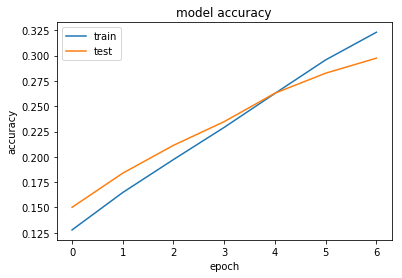

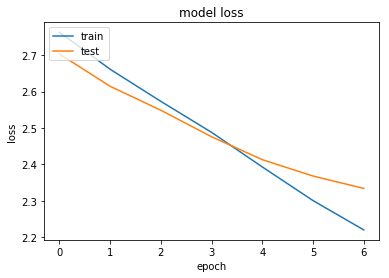

In [68]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('accuracy_updated.jpg')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('loss_updated.jpg')
plt.show()

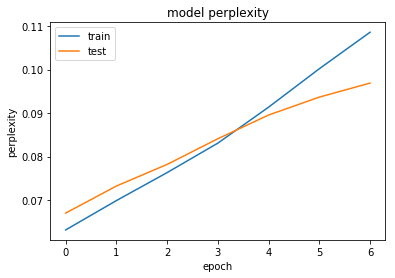

In [69]:
#print(history.history['loss'])
exp_negative_loss_train=list(np.exp(np.negative(history.history['loss'])))
#print(exp_negative_loss_train)
#print(history.history['val_loss'])
exp_negative_loss_test=list(np.exp(np.negative(history.history['val_loss'])))
#print(exp_negative_loss_test)

plt.plot(exp_negative_loss_train)
plt.plot(exp_negative_loss_test)
plt.title('model perplexity')
plt.ylabel('perplexity')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('perplexity.jpg')
plt.show()

In [8]:
# perplexity = (step * 1.0 / model.input.epoch_size, np.exp(costs / iters)
# index_train = np.array([True]*len(predictors))
# index_train[ np.arange(5,len(predictors),5)] = False
# index_test = ~index_train
# x_train = predictors[index_train]
# y_train = label[index_train]
# x_test = predictors[index_test]
# y_test = label[index_test]


#data = open(fname).read()
#proteins = data.split("\n")
data = open(fname).read()
corpus1 = data.split("\n")
proteins = corpus1[::44]
#print(corpus)
for i in range(len(proteins)):
    if (len(proteins[i])>c_len):
        proteins[i]=proteins[i][:c_len]
    else:
        continue
print(proteins[:5])

['MVLSEGEWQLVLHVWAKVEADV', 'MNIFEMLRIDEGLRLKIYKDTE', 'MNIFEILRIDEGLRLKIYKDTE', 'MNIFEMLRIDEGLRLKIYKDTE', 'MKAERKRMRNRIAASKSRKRKL']


In [9]:
# Task III – Sequence Generation Techniques
# EXAMPLE 1
i = 0
new_protein = proteins[i][:5]
print(proteins[i][:19])
while len(new_protein)<19:
    new_protein, next_amino = generate_amino(new_protein, max_sequence_len)
    print(new_protein)
    #print(next_amino)

MVLSEGEWQLVLHVWAKVE
MVLSES
MVLSESE
MVLSESES
MVLSESESH
MVLSESESHA
MVLSESESHAH
MVLSESESHAHA
MVLSESESHAHAT
MVLSESESHAHATT
MVLSESESHAHATTA
MVLSESESHAHATTAV
MVLSESESHAHATTAVS
MVLSESESHAHATTAVSG
MVLSESESHAHATTAVSGA


In [80]:
# EXAMPLE 2
i = 10
new_protein = proteins[i][:5]
print(proteins[i][:19])
while len(new_protein)<19:
    new_protein, next_amino = generate_amino(new_protein, max_sequence_len)
    print(new_protein)

SKSHSEAGSAFIQTQQLHA
SKSHSH
SKSHSHH
SKSHSHHH
SKSHSHHHH
SKSHSHHHHH
SKSHSHHHHHH
SKSHSHHHHHHA
SKSHSHHHHHHAE
SKSHSHHHHHHAEE
SKSHSHHHHHHAEEE
SKSHSHHHHHHAEEEE
SKSHSHHHHHHAEEEEE
SKSHSHHHHHHAEEEEEF
SKSHSHHHHHHAEEEEEFV


In [81]:
# EXAMPLE 3
i = 20
new_protein = proteins[i][:5]
print(proteins[i][:19])
while len(new_protein)<19:
    new_protein, next_amino = generate_amino(new_protein, max_sequence_len)
    print(new_protein)

FPRGGGGGNGDFEEIPEEY
FPRGGK
FPRGGKR
FPRGGKRP
FPRGGKRPV
FPRGGKRPVI
FPRGGKRPVIV
FPRGGKRPVIVG
FPRGGKRPVIVGG
FPRGGKRPVIVGGG
FPRGGKRPVIVGGGG
FPRGGKRPVIVGGGGG
FPRGGKRPVIVGGGGGG
FPRGGKRPVIVGGGGGGG
FPRGGKRPVIVGGGGGGGG


In [82]:
# EXAMPLE 4
i = 40
new_protein = proteins[i][:5]
print(proteins[i][:19])
while len(new_protein)<19:
    new_protein, next_amino = generate_amino(new_protein, max_sequence_len)
    print(new_protein)

GCTLSAEDKAAVERSKMID
GCTLSL
GCTLSLL
GCTLSLLA
GCTLSLLAV
GCTLSLLAVG
GCTLSLLAVGL
GCTLSLLAVGLG
GCTLSLLAVGLGG
GCTLSLLAVGLGGG
GCTLSLLAVGLGGGG
GCTLSLLAVGLGGGGG
GCTLSLLAVGLGGGGGA
GCTLSLLAVGLGGGGGAG
GCTLSLLAVGLGGGGGAGV


In [83]:
# EXAMPLE 5
i = 50
new_protein = proteins[i][:5]
print(proteins[i][:19])
while len(new_protein)<19:
    new_protein, next_amino = generate_amino(new_protein, max_sequence_len)
    print(new_protein)

LFLAQEIIRKKRDGHALSD
LFLAQA
LFLAQAG
LFLAQAGG
LFLAQAGGQ
LFLAQAGGQL
LFLAQAGGQLG
LFLAQAGGQLGR
LFLAQAGGQLGRR
LFLAQAGGQLGRRG
LFLAQAGGQLGRRGS
LFLAQAGGQLGRRGSM
LFLAQAGGQLGRRGSMD
LFLAQAGGQLGRRGSMDV
LFLAQAGGQLGRRGSMDVV


In [10]:
index_train = np.array([True]*len(proteins))
index_train[ np.arange(5,len(proteins),5)] = False
index_test = ~index_train
proteins = np.array(proteins)
protein_test = proteins[index_test]

In [3]:
#print(index_train)
#print(index_test)

In [90]:
def compare_proteins(correct_protein,new_protein, i):
    pred_cor = list()
    for x, y in zip(seq_cor,new_protein):
        if x == y:
            pred_cor.append(1)
        else:
            pred_cor.append(0)
    pred_cor = np.array(pred_cor)        
    pred_cor[:i]=0
    pred = list()
    s = 0
    for i in pred_cor:
        s = s + i
        pred.append(s)
    pred = np.array(pred)
    return pred

In [91]:
res_mat_glob = list()
for pr in protein_test:
    res_mat_loc = list()
    for i in range(1,20):
        seq_cor = pr[:19]
        seq = pr[:i]
        new_protein = seq
        while len(new_protein)<19:
            new_protein, next_amino = generate_amino(new_protein, max_sequence_len)
        res = compare_proteins(seq_cor,new_protein, i)
        res_mat_loc.append(res)
    res_mat_loc = np.array(res_mat_loc)
    res_mat_glob.append(res_mat_loc)
    print(res_mat_loc.shape)
    print(res_mat_loc)
    

(19, 19)
[[0 1 2 3 3 3 3 3 3 3 3 3 4 4 5 6 7 8 8]
 [0 0 1 2 2 2 2 2 2 2 2 2 3 3 4 5 6 7 7]
 [0 0 0 1 1 1 1 1 1 1 1 1 2 2 3 4 5 6 6]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 3 4 5 5]
 [0 0 0 0 0 1 1 1 1 1 1 1 2 3 4 4 4 5 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 3 3 4 4]
 [0 0 0 0 0 0 0 1 2 3 4 5 6 7 8 9 9 9 9]
 [0 0 0 0 0 0 0 0 1 2 3 4 5 6 7 8 8 8 8]
 [0 0 0 0 0 0 0 0 0 1 2 3 4 5 6 7 7 7 7]
 [0 0 0 0 0 0 0 0 0 0 1 2 3 4 5 6 6 6 6]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 5 5 5 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 4 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 1 2 2 2 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 

(19, 19)
[[ 0  1  1  2  2  2  3  4  5  5  6  7  7  8  8  8  8  8  8]
 [ 0  0  0  1  1  1  2  3  4  4  5  6  6  7  7  7  7  7  7]
 [ 0  0  0  1  2  3  4  5  5  6  7  8  9 10 10 10 10 11 11]
 [ 0  0  0  0  1  2  3  4  4  5  6  7  8  9  9  9  9 10 10]
 [ 0  0  0  0  0  1  2  3  3  4  5  6  7  8  8  8  8  9  9]
 [ 0  0  0  0  0  0  1  2  2  3  4  5  6  7  7  7  7  8  8]
 [ 0  0  0  0  0  0  0  1  1  2  3  4  5  6  6  6  6  7  7]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  5  5  5  6  6]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 0 0 0 0 1 2 2 3 4 4 4 4 4 4 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 2 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 

(19, 19)
[[0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 

(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3

(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 3 3]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 4 5 6 7]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 3 4 5 6]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 3 4 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 3 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 1 2 2 2 3 4 4 5 5 5 5 5 5]
 [0 0 0 0 0 0 0 1 1 1 2 3 3 4 4 4 4 4 4]
 [0 0 0 0 0 0 0 0 0 0 1 2 2 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 1 2 2 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 1 2 2 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 1 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 

(19, 19)
[[ 0  1  2  2  3  4  5  6  6  6  7  8  9  9  9 10 10 10 11]
 [ 0  0  1  1  2  3  4  5  5  5  6  7  8  8  8  9  9  9 10]
 [ 0  0  0  0  1  2  3  4  4  4  5  6  7  7  7  8  8  8  9]
 [ 0  0  0  0  1  2  3  4  5  5  6  7  8  8  9 10 10 10 11]
 [ 0  0  0  0  0  1  2  3  4  4  5  6  7  7  8  9  9  9 10]
 [ 0  0  0  0  0  0  1  2  3  3  4  5  6  6  7  8  8  8  9]
 [ 0  0  0  0  0  0  0  1  2  2  3  4  5  5  6  7  7  7  8]
 [ 0  0  0  0  0  0  0  0  1  1  2  3  4  4  5  6  6  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  3  4  5  5  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  3  4  5  5  5  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  2  3  4  4  4  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  1  2  3  3  3  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  2  2  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  2  2  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 1 2 3 4 5 6 6 7 8 8 8 9 9 9 9 9 9]
 [0 0 0 1 2 3 4 5 5 6 7 7 7 8 8 8 8 8 8]
 [0 0 0 0 1 2 3 4 4 5 6 6 6 7 7 7 7 7 7]
 [0 0 0 0 0 1 2 3 3 4 5 5 5 6 6 6 6 6 6]
 [0 0 0 0 0 0 1 2 2 3 4 4 4 5 5 5 5 5 5]
 [0 0 0 0 0 0 0 1 1 2 3 3 3 4 4 4 4 4 4]
 [0 0 0 0 0 0 0 0 0 1 2 2 2 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 2 2 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2 

(19, 19)
[[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 1 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 2 3]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 2 2 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 1 1 2 2 2 2 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 2 2 3 3 3 3 4 5 5 5 5 5 5 6]
 [0 0 0 0 0 1 1 2 2 2 2 3 4 4 4 4 4 4 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 2 2 3 3 3 3 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 

(19, 19)
[[0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 3 3]
 [0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 1 2 3 3 3 4 4 5 6 7 8 9]
 [0 0 0 0 0 0 0 0 1 2 2 2 3 3 4 5 6 7 8]
 [0 0 0 0 0 0 0 0 0 1 1 1 2 2 3 4 5 6 7]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 3 4 5 6]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 3 4 5 6]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 

(19, 19)
[[0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  2  3

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 2 3 4 4 4 4 5 6 6 6]
 [0 0 0 0 0 0 0 0 0 1 2 3 3 3 3 4 5 5 5]
 [0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 3 4 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 1 1 1 1 1 1 1 1 2 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 2 3 4 5 5 5 5 5 5 5 5 5 5 6 7 7]
 [0 0 0 1 2 3 4 4 4 4 4 4 4 4 4 4 5 6 6]
 [0 0 0 0 1 2 3 3 3 3 3 3 3 3 3 3 4 5 5]
 [0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 3 4 4]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 1 2 3 3 3 3 3 3 3 3 4 4 5 5 5 5 5]
 [0 0 0 1 2 2 2 2 2 2 2 2 3 3 4 4 4 4 4]
 [0 0 0 0 1 1 1 1 1 1 1 1 2 2 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 2 2 2 2 2 2 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2 3 3]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 3 3 3]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 

(19, 19)
[[0 0 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 

(19, 19)
[[0 0 0 0 1 2 3 4 4 4 5 5 5 5 5 6 6 6 7]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 

(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 1 2 3 4 5 5 5 5 5 5 5 5 5 5 5 5]
 [0 0 0 0 1 2 3 4 4 4 4 4 4 4 4 4 4 4 4]
 [0 0 0 0 0 1 2 3 3 3 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 3 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 2 2 2 3 3 3 3 3 3 

(19, 19)
[[ 0  0  1  1  1  1  1  1  2  2  3  4  4  4  4  4  4  4  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  1  2  2  2  2  2]
 [ 0  0  0  0  1  2  3  4  4  5  6  7  8  9 10 11 11 12 13]
 [ 0  0  0  0  0  1  2  3  3  4  5  6  7  8  9 10 10 11 12]
 [ 0  0  0  0  0  0  1  2  2  3  4  5  6  7  8  9  9 10 11]
 [ 0  0  0  0  0  0  0  1  1  2  3  4  5  6  7  8  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 1 1 2 3 3 3 3 3 3 4 4 4 4 4 5]
 [0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 3 3 3 3]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 2 3 4 5 6 7 7 8 9 9 9]
 [0 0 0 0 0 0 0 0 1 2 3 4 5 6 6 7 8 8 8]
 [0 0 0 0 0 0 0 0 0 1 2 3 4 5 5 6 7 7 7]
 [0 0 0 0 0 0 0 0 0 0 1 2 3 4 4 5 6 6 6]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 3 3 4 5 5 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 3 4 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 2 2 2 2 2 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 2 2 2 2 2 2 2 2 2 2 2 3 4 5 5 6 6]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 2 3 4 4 5 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 3 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 

(19, 19)
[[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 1 2 2 2 2 2 2 2 2 3 3 3 3 3 3]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2 

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  2  3  4  5  6  7  8  9 10 10 10 10 10 10 10 10]
 [ 0  0  0  1  2  3  4  5  6  7  8  9  9  9  9  9  9  9  9]
 [ 0  0  0  0  1  2  3  4  5  6  7  8  8  8  8  8  8  8  8]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  7  7  7  7  7  7  7]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  6  6  6  6  6  6  6]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  5  5  5  5  5  5  5]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  4  4  4  4  4  4  4]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  3  3  3  3  3  3  3]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  2  2  2  2  2  2  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  4  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  3  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  2  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 2 3 4 4 5 5 5 5 5 5 5 5 5 5]
 [0 0 0 1 2 3 4 5 5 6 6 6 6 6 6 6 6 6 6]
 [0 0 0 0 1 2 3 4 4 5 5 5 5 5 5 5 5 5 5]
 [0 0 0 0 0 1 2 3 3 4 4 4 4 4 4 4 4 4 4]
 [0 0 0 0 0 0 1 2 2 3 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2 3 3]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 1 1 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3]
 [0 0 1 2 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4]
 [0 0 0 1 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 1 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 2 3 3 4 5 5 5 5 5 5 5 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 2 3 4 5 5 6 6 6 6 6 6 6 6 6 6 6]
 [0 0 0 1 2 3 4 4 5 5 5 5 5 5 5 5 5 5 5]
 [0 0 0 0 1 2 3 3 4 4 4 4 4 4 4 4 4 4 4]
 [0 0 0 0 0 1 2 2 3 3 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1]
 [ 0  0  1  2  3  4  5  6  7  8  9  9  9  9  9 10 10 10 10]
 [ 0  0  0  1  2  3  4  5  6  7  8  8  8  8  8  9  9  9  9]
 [ 0  0  0  0  1  2  3  4  5  6  7  7  7  7  7  8  8  8  8]
 [ 0  0  0  0  0  1  2  3  4  5  6  6  6  6  6  7  7  7  7]
 [ 0  0  0  0  0  0  1  2  3  4  5  5  5  5  5  6  6  6  6]
 [ 0  0  0  0  0  0  0  1  2  3  4  4  4  4  4  5  5  5  5]
 [ 0  0  0  0  0  0  0  0  1  2  3  3  3  3  3  4  4  4  4]
 [ 0  0  0  0  0  0  0  0  0  1  2  2  2  2  2  3  3  3  3]
 [ 0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  2  2  2  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  2  2  2  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 

(19, 19)
[[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 1 1 1 1 1 2 2 2 2 2 2 2 2 3 3 4]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2 3]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1]
 [ 0  0  0  0  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  2  2  3]
 [ 0  0  0  0  0  1  2  2  3  3  3  3  3  3  3  3  3  3  3]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 2 2 2 2 2 3 3 3 3 3]
 [0 0 0 0 0 0 1 1 1 1 1 2 2 3 4 4 4 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  0  1  1  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3]
 [ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  2  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1]
 [ 0  0  0  0  1  2  3

(19, 19)
[[0 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 1 2 3 3 3 4 4 4 4 4 4 4 4 4 4 4 5]
 [0 0 0 1 2 2 2 3 3 3 3 3 3 3 3 3 3 3 4]
 [0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 

(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 3 3]
 [0 0 0 0 0 0 1 2 2 2 2 2 3 3 3 3 3 4 4]
 [0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 1 2 2 2 2 2 3 3 3 3 3 3 3 4 4 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 2 3 4 4 4 4 4 4 4 4 4 4 4 4 5 5 6]
 [0 0 1 2 3 3 3 3 3 3 3 3 3 3 3 3 4 4 5]
 [0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 3 3 4]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 

(19, 19)
[[0 1 2 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4]
 [0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 

(19, 19)
[[0 1 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 2 2 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2]
 [0 0 1 2 2 2 3 3 3 4 4 5 5 5 5 5 5 5 5]
 [0 0 0 1 1 1 2 2 2 3 3 4 4 4 4 4 4 4 4]
 [0 0 0 0 0 0 1 1 1 2 2 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 3 3 3]
 [0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 1 2 2 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 1 2 2 2 2 2 2 3 3 4 4 4 4 4 4 4 4 4]
 [0 0 1 1 1 1 1 1 2 2 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 3 4 4 4]
 [0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 3 3 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 1 2 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
 [0 0 0 1 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  2  3  4  5  6  6  7  8  9 10 10 11 11 12 12]
 [ 0  0  0  0  1  2  3  4  5  5  6  7  8  9  9 10 10 11 11]
 [ 0  0  0  0  0  1  2  3  4  4  5  6  7  8  8  9  9 10 10]
 [ 0  0  0  0  0  0  1  2  3  3  4  5  6  7  7  8  8  9  9]
 [ 0  0  0  0  0  0  0  1  2  2  3  4  5  6  6  7  7  8  8]
 [ 0  0  0  0  0  0  0  0  1  1  2  3  4  5  5  6  6  7  7]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  4  5  5  6  6]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 1 2 2 2 2 2 2 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 1 1 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3]
 [0 0 1 2 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4]
 [0 0 0 1 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 

(19, 19)
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
 [ 0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
 [ 0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[ 0  0  0  0  0  1  2  2  3  3  3  3  3  3  4  4  5  5  5]
 [ 0  0  0  0  1  1  1  1  1  1  1  2  2  2  2  2  2  2  3]
 [ 0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  0  0  1  1  1  2  3  4  4  5  6  7  8  8  9 10 10]
 [ 0  0  0  0  0  0  0  1  2  3  3  4  5  6  7  7  8  9  9]
 [ 0  0  0  0  0  0  0  1  2  3  3  4  5  6  6  6  6  6  6]
 [ 0  0  0  0  0  0  0  1  2  3  3  4  4  5  6  6  6  6  7]
 [ 0  0  0  0  0  0  0  0  1  2  2  3  3  4  5  5  5  5  6]
 [ 0  0  0  0  0  0  0  0  0  1  1  2  2  3  4  4  4  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  1  2  3  3  3  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  4  5  6  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  3  4  5  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  2  3  4  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  2  3  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  2]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  2  3  4  5  6  7  8  9 10 11 11 11 11 11 11 11]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 10 10 10 10 10 10]
 [ 0  0  0  0  1  2  3  4  5  6  7  8  9  9  9  9  9  9  9]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  8  8  8  8  8  8]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  7  7  7  7  7  7]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  6  6  6  6  6  6]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  5  5  5  5  5  5]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  4  4  4  4  4  4]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  3  3  3  3  3  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  2  2  2  2  2  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 2 3 3 4 4 4 4 5 5 5 5]
 [0 0 0 0 0 0 1 1 2 3 3 4 4 4 4 5 5 5 5]
 [0 0 0 0 0 0 0 0 1 2 2 3 3 3 3 4 4 4 4]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 1 1 1 2 2 2 2 3 3 3 3 3 4 4 4]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 

(19, 19)
[[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 1 1 1 1 1 2 2 2 2 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 2 3 4 5 6 7 8 8 8 8 8 8 8 8]
 [0 0 0 0 0 1 2 3 4 5 6 7 7 7 7 7 7 7 

(19, 19)
[[ 0  0  0  0  1  1  2  2  2  3  3  3  3  3  3  3  3  3  4]
 [ 0  0  0  1  1  1  2  2  2  3  3  3  3  3  3  3  3  3  3]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 2 2 2 3 3 3 3 3 3 3 

(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2]
 [0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 

(19, 19)
[[0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 2 3 3 4]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 

(19, 19)
[[0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 1 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 2 3 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6]
 [0 0 1 2 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5]
 [0 0 0 1 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4]
 [0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 

(19, 19)
[[ 0  0  0  0  0  1  1  1  1  1  1  1  1  2  2  2  2  2  2]
 [ 0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  0  0  1  1  1  1  2  3  3  3  3  3  3  3  4  4  4]
 [ 0  0  0  0  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3

(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 2 3 3 3 4 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 3 3 3 3]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 

(19, 19)
[[0 1 1 1 2 2 3 3 3 3 4 4 4 4 4 4 4 4 4]
 [0 0 0 0 1 1 2 2 2 2 3 3 3 3 3 3 3 3 3]
 [0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 3 4 5 5]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 3 3 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 1 2 2 2 2 2 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2 2 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 3]
 [0 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3

(19, 19)
[[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 3 3 3]
 [0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 2 2 2 3 4 4 4 4 4 4]
 [0 0 0 0 0 0 0 0 0 1 1 1 2 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  2  2  2]
 [ 0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 3 3]
 [0 0 0 1 2 3 4 4 4 4 4 4 4 5 5 5 5 5 5]
 [0 0 0 0 1 2 3 3 3 3 3 3 3 4 4 4 4 4 4]
 [0 0 0 0 0 1 2 2 2 2 2 2 2 3 3 3 3 3 3]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 3 3 3]
 [0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 3 3 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 0 0 0 0 0 0 1 1 1 1 2 3 3 3 3 3 3]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  2  3

(19, 19)
[[0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 3 3 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 3 4 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 1 1 1 1 1 2 2 2 2 3 3 3 4 4 4 4 4]
 [0 0 0 0 0 0 0 1 1 1 1 2 2 2 3 3 3 3 3]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 3 3 3]
 [0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 1 2 2 2 2 2 2 2 2 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 1 2 2 2 2 2 2 2 2 3 3 3 3 3 3 4]
 [0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  1  1  1  1  2  2  2  2  2]
 [ 0  0  1  2  3  4  4  5  6  7  8  9 10 10 11 12 13 14 15]
 [ 0  0  0  1  2  3  3  4  5  6  7  8  9  9 10 11 12 13 14]
 [ 0  0  0  0  1  2  2

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 2 2 2 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 2 3 4 4 4 4 4 4 4 4 4 4]
 [0 0 0 0 0 0 0 1 2 3 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 5 6 7]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 5 6]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3

(19, 19)
[[0 1 2 3 4 4 4 4 4 4 4 4 4 5 5 5 5 5 6]
 [0 0 1 2 3 3 3 3 3 3 3 3 3 4 4 4 4 4 5]
 [0 0 0 1 2 2 2 2 2 2 2 2 2 3 3 3 3 3 4]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 1 1 2 2 3 3 3 3 3 3 4 4 4 5 5 5]
 [0 0 0 0 0 1 1 2 2 2 2 2 2 3 3 3 4 4 4]
 [0 0 0 0 0 1 2 3 4 5 5 6 7 8 8 8 9 9 9]
 [0 0 0 0 0 0 1 2 3 4 4 5 6 7 7 7 8 8 8]
 [0 0 0 0 0 0 0 1 2 3 3 4 5 6 6 6 7 7 7]
 [0 0 0 0 0 0 0 0 1 2 2 3 4 5 5 5 6 6 6]
 [0 0 0 0 0 0 0 0 0 1 1 2 3 4 4 4 5 5 5]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 3 3 3 4 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 3 3 3 4 5 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 3 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 2 3 4 5 5 5 5 5 6 6 6 6]
 [0 0 0 0 0 0 0 1 2 3 4 4 4 4 4 5 5 5 5]
 [0 0 0 0 0 0 0 0 1 2 3 3 3 3 3 4 4 4 4]
 [0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 5 6 7]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 5 6]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 3 4 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 2 2 2 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 1 2 3 4 5 6 6 7 8 8 8 9 9 9 9 9 9]
 [0 0 0 1 2 3 4 5 5 6 7 7 7 8 8 8 8 8 8]
 [0 0 0 0 1 2 3 4 4 5 6 6 6 7 7 7 7 7 7]
 [0 0 0 0 0 1 2 3 3 4 5 5 5 6 6 6 6 6 6]
 [0 0 0 0 0 0 1 2 2 3 4 4 4 5 5 5 5 5 5]
 [0 0 0 0 0 0 0 1 1 2 3 3 3 4 4 4 4 4 4]
 [0 0 0 0 0 0 0 0 0 1 2 2 2 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 2 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  1  1  1  1  2  2  2  2  2]
 [ 0  0  0  0  1  2  3

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 

(19, 19)
[[0 1 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 1 2 3 4 4 4 5 5 5 5 5 5 5 5 5 5]
 [0 0 0 1 2 3 4 4 4 5 5 5 6 6 7 7 7 7 7]
 [0 0 0 0 1 2 3 3 3 4 4 4 5 5 6 6 6 6 6]
 [0 0 0 0 0 1 2 2 2 3 3 3 4 4 5 5 5 5 5]
 [0 0 0 0 0 0 1 1 1 2 2 2 3 3 4 4 4 4 4]
 [0 0 0 0 0 0 0 0 0 1 1 1 2 2 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1]
 [ 0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 1 1 1 1 1 2 2 2 3 3 3 4 4 4 4 4 4 4]
 [0 0 0 0 0 0 1 1 1 2 2 2 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 2 2 2 3 3 3 3 3 4 5 5]
 [0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 3 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 2 3 4 4 5 6 7 8 9 9 9 9 9 9 9 9]
 [0 0 0 1 2 3 3 4 5 6 7 8 8 8 8 8 8 8 8]
 [0 0 0 0 1 2 2 3 4 5 6 7 7 7 7 7 7 7 7]
 [0 0 0 0 0 1 1 2 3 4 5 6 6 6 6 6 6 6 6]
 [0 0 0 0 0 0 0 1 2 3 4 5 5 5 5 5 5 5 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 2 2 2 2 2 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  1  1  1  2  3  3  3  3  3]
 [ 0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 3 3 3 4]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 3]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 3 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 2 3 3 4 5 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 3 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 1 1 2 2 2 2 2 2 3 3 3 3 3 4]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 

(19, 19)
[[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  1  2  3  3  4  5  6  7  8  9 10 11 12 13 13 13 14 14]
 [ 0  0  1  2  2  3  4  5  6  7  8  9 10 11 12 12 12 13 13]
 [ 0  0  0  1  1  2  3  4  5  6  7  8  9 10 11 11 11 12 12]
 [ 0  0  0  0  0  1  2

(19, 19)
[[ 0  1  1  2  2  2  2  2  3  3  4  5  5  5  5  5  5  5  5]
 [ 0  0  0  1  1  1  1  1  2  2  3  4  4  4  4  4  4  4  4]
 [ 0  0  0  1  1  1  1  1  2  3  4  5  5  5  5  5  6  6  6]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  4  4  4  4  5  5  5]
 [ 0  0  0  0  0  1  2  3  4  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  1  2  3  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  1  2  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  1  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 2 3 4 5 5 6 6 6 7 7 7 8]
 [0 0 0 0 0 0 0 1 2 3 4 4 5 5 5 6 6 6 7]
 [0 0 0 0 0 0 0 0 1 2 3 3 4 4 4 5 5 5 6]
 [0 0 0 0 0 0 0 0 0 1 2 2 3 3 3 4 4 4 5]
 [0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 3 3 3 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 5 6 7]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 5 6]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 3 3]
 [0 0 0 1 2 3 4 5 6 7 7 8 8 8 8 9 9 9 9]
 [0 0 0 0 1 2 3 4 5 6 6 7 7 7 7 8 8 8 8]
 [0 0 0 0 0 1 2 3 4 5 5 6 6 6 6 7 7 7 7]
 [0 0 0 0 0 0 1 2 3 4 4 5 5 5 5 6 6 6 6]
 [0 0 0 0 0 0 0 1 2 3 3 4 4 4 4 5 5 5 5]
 [0 0 0 0 0 0 0 0 1 2 2 3 3 3 3 4 4 4 4]
 [0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 5 6 7 7]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 5 6 6]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 5 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  1  1  1  2  3  3  3  3  3]
 [ 0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3

(19, 19)
[[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 2 2 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  0  0  0  1  1  1  1  1  1  1  2  2  2  2  2  2  2]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  1  1  1  2  2  2  2  2  2  2  2  2  3  3  4]
 [ 0  0  0  1  2  2  2  3  3  3  3  4  4  4  4  4  4  4  4]
 [ 0  0  0  0  1  1  1  2  2  2  2  3  3  3  3  3  3  3  3]
 [ 0  0  0  0  0  0  0  1  1  1  1  2  2  2  2  2  2  2  2]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 3 3 

(19, 19)
[[ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  2  3  4  5  6  7  7  8  9 10 10 10 11 11]
 [ 0  0  0  0  0  1  2  3  4  5  6  6  7  8  9  9  9 10 10]
 [ 0  0  0  0  0  0  1  2  3  4  5  5  6  7  8  8  8  9  9]
 [ 0  0  0  0  0  0  0  1  2  3  4  4  5  6  7  7  7  8  8]
 [ 0  0  0  0  0  0  0  0  1  2  3  3  4  5  6  6  6  7  7]
 [ 0  0  0  0  0  0  0  0  0  1  2  2  3  4  5  5  5  6  6]
 [ 0  0  0  0  0  0  0  0  0  0  1  1  2  3  4  4  4  5  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  3  3  4  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  3  3  3  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  2  2  2  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 13 13 13 13]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 12 12 12 12]
 [ 0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 11 11 11 11]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 10 10 10 10]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9  9  9  9  9]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  8  8  8  8]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  7  7  7  7]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  6  6  6  6]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  5  5  5  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  4  4  4  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  3  3  3  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  2  2  2  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  2]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  1  2  3  4  5  5  6  6  7  8  9 10 10 10 11 11 11 11]
 [ 0  0  1  2  3  4  4  5  5  6  7  8  9  9  9 10 10 10 10]
 [ 0  0  0  1  2  3  3  4  4  5  6  7  8  8  8  9  9  9  9]
 [ 0  0  0  0  1  2  2

(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 2 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  2  2  2  3  3]
 [ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  2  2  2  2]
 [ 0  0  0  0  0  0  0

(19, 19)
[[0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 1 1 1 1 1 1 2 3 3 3 4 4 4 5 5 5 6]
 [0 0 0 0 0 0 0 0 1 2 2 2 3 3 3 4 4 4 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2 

(19, 19)
[[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 

(19, 19)
[[0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 2 2 2 2 3 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 2 2 3 3 3 3 4 4 4 4 4 4 

(19, 19)
[[0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 1 2 3 3 3 4 4 5 5 5 5 5 5 5 6 6 6]
 [0 0 0 1 2 2 2 3 3 4 4 4 4 4 4 4 5 5 5]
 [0 0 0 0 1 1 1 2 2 3 3 3 3 3 3 3 4 4 4]
 [0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 3 3 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 1 1 1 1 1 1 1 2 2 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  2  2  2]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 1 2 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 1 1 2 2 2 2 2 3 3 3 3 3 3 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 2 3 4 5 5 5 5 5 5 5 5 5 5 5 5 5]
 [0 0 0 1 2 3 4 4 4 4 4 4 4 4 4 4 4 4 4]
 [0 0 0 0 1 2 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3

(19, 19)
[[ 0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[ 0  1  2  3  4  4  5  6  6  6  7  8  8  9 10 10 11 11 11]
 [ 0  0  1  2  3  3  4  5  5  5  6  7  7  8  9  9 10 10 10]
 [ 0  0  0  1  2  2  3  4  4  4  5  6  6  7  8  8  9  9  9]
 [ 0  0  0  0  1  1  2  3  3  3  4  5  5  6  7  7  8  8  8]
 [ 0  0  0  0  0  0  1  2  2  2  3  4  4  5  6  6  7  7  7]
 [ 0  0  0  0  0  0  1  2  2  3  4  5  5  6  6  6  6  7  7]
 [ 0  0  0  0  0  0  0  1  1  2  3  4  4  5  5  5  5  6  6]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  3  4  4  4  4  5  5]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3 3 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 1 1 1 2 2 3 3 3 3 3 3 4]
 [0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 1 1 1 1 1 1 2 2 3 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  0  1  2  3  4  5  6  7  8  8  9 10 11 12 13 13 13]
 [ 0  0  0  0  1  2  3

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 1 2 2 2 2 2 2 3 3 3 4 4 4 4 4 4]
 [0 0 0 0 1 1 1 1 1 1 2 2 2 3 3 3 3 3 3]
 [0 0 0 0 0 1 1 1 1 1 2 2 2 2 3 3 3 3 3]
 [0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 1 1 2 3 3 4 5 5 5 5 5 5 

(19, 19)
[[ 0  1  2  3  3  4  5  6  7  7  8  9  9 10 10 10 11 11 11]
 [ 0  0  1  2  2  3  4  5  6  6  7  8  8  9  9  9 10 10 10]
 [ 0  0  0  1  1  2  3  4  5  5  6  7  7  8  8  8  9  9  9]
 [ 0  0  0  0  0  1  2  3  4  4  5  6  6  7  7  7  8  8  8]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  6  7  8  9  9 10 11]
 [ 0  0  0  0  0  0  0  1  2  2  3  4  4  5  5  5  6  6  6]
 [ 0  0  0  0  0  0  0  1  2  2  3  4  4  5  5  5  6  6  6]
 [ 0  0  0  0  0  0  0  0  1  1  2  3  3  4  4  4  5  5  5]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  2  3  3  3  4  4  4]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  2  2  2  3  3]
 [ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  2  2  2  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  8  9 10 10 10 10]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  7  8  9  9  9  9]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  6  7  8  8  8  8]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  5  6  7  7  7  7]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  4  5  6  6  6  6]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  3  4  5  5  5  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  2  3  4  4  4  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  1  2  3  3  3  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  2  2  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  2]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 

(19, 19)
[[ 0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  1  1  1  1  2  2  2  2  2  3  3  3  3  4  4  4  4]
 [ 0  0  0  0  0  0  1  1  1  1  1  2  2  2  2  3  3  3  3]
 [ 0  0  0  0  1  1  2  2  2  2  2  3  3  3  3  3  3  3  3]
 [ 0  0  0  0  0  0  1  1  1  1  1  2  2  2  2  2  2  2  2]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  2  2  2  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1]
 [ 0  0  0  0  0  0  0

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 

(19, 19)
[[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 1 1 2 2 3 3 4 4 4 4 4 5]
 [0 0 0 0 0 0 0 1 2 3 3 4 4 5 5 5 5 5 5]
 [0 0 0 0 0 0 0 1 2 3 3 3 3 4 4 4 4 4 4]
 [0 0 0 0 0 0 0 0 1 2 2 2 2 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 3 3 3 3 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  0  1  2  3  4  5  6  7  8  8  9 10 11 12 13 13 13]
 [ 0  0  0  0  1  2  3

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 2 2 2 

(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  2  3

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 1 2 3 4 5 6 7 8 9 9 9 9 9 9 9 9]
 [0 0 0 0 1 2 3 4 5 6 7 8 8 8 8 8 8 8 8]
 [0 0 0 0 0 1 2 3 4 5 6 7 7 7 7 7 7 7 7]
 [0 0 0 0 0 0 1 2 3 4 5 6 6 6 6 6 6 6 6]
 [0 0 0 0 0 0 0 1 2 3 4 5 5 5 5 5 5 5 5]
 [0 0 0 0 0 0 0 0 1 2 3 4 4 4 4 4 4 4 4]
 [0 0 0 0 0 0 0 0 0 1 2 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 5 5 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 2 3 4 5 5 5 5 6 6 6 6 6 6 6 6 6]
 [0 0 0 1 2 3 4 4 4 4 5 5 5 5 5 5 5 5 5]
 [0 0 0 0 1 2 3 3 3 3 4 4 4 4 4 4 4 4 4]
 [0 0 0 0 0 1 2 2 2 2 3 3 3 3 3 3 3 3 

(19, 19)
[[0 0 1 2 2 2 3 4 4 4 4 4 4 4 4 4 4 4 4]
 [0 0 0 0 0 0 1 1 1 1 1 1 2 3 4 4 4 4 4]
 [0 0 0 1 1 1 2 3 3 3 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 2 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 2 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 2 3 3 3 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 3 

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 1 2 2 3 3 3 3 3 3 3 3 3 3 3 4 4]
 [0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 2 2 2 2 3 3 4 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 2 2 3 4 4 5 5 5]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 2 3 3 4 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 2 3 3 4 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 3 4 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 3 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 

(19, 19)
[[0 1 2 2 2 2 2 2 2 2 3 3 3 3 3 4 4 5 5]
 [0 0 1 1 1 1 1 1 1 1 2 2 2 2 2 3 3 4 4]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 1 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4]
 [0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1]
 [ 0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 1 1 2 2 2 2 2 2 3 3 4 4 4 4 4 4]
 [0 0 0 0 0 1 1 1 1 1 1 2 2 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2]
 [0 0 0 0 1 1 1 1 1 1 1 2 2 2 3 3 3 3 3]
 [0 0 0 1 2 3 3 3 3 3 4 4 4 4 4 4 4 4 4]
 [0 0 0 0 1 2 2 2 2 2 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 1 2 3 4 5 5 6 7 8 9 9]
 [0 0 0 0 0 0 0 0 0 1 2 3 4 4 5 6 7 8 8]
 [0 0 0 0 0 0 0 0 0 0 1 2 3 3 4 5 6 7 7]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 2 3 4 5 6 6]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 3 4 5 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 3 3 4 5]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 

(19, 19)
[[0 1 2 2 2 2 2 2 2 2 2 2 2 3 3 4 4 4 4]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 2 3 4 4 4 4 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 1 2 2 3 3 3 3 4 4 4 4 5 5 5 5 5 5]
 [0 0 0 1 1 2 2 2 2 3 3 3 3 4 4 4 4 4 4]
 [0 0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 3 3 4 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 3 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 

(19, 19)
[[0 1 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 2 2 2 2 2 2 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 5 5 5]
 [0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 4 4 4]
 [0 0 0 1 1 1 1 1 1 1 1 1 2 2 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2]
 [0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 3 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 3]
 [0 0 0 0 1 1 1 2 3 3 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 3 4 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 3 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 3 4 4 4]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 2 3 3 3 4 4 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 

(19, 19)
[[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 1 1 2 2 2 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  1  2  3  4  5  6  6  7  8  9 10 10 11 11 12 12 13 13]
 [ 0  0  1  2  3  4  5  5  6  7  8  9  9 10 10 11 11 12 12]
 [ 0  0  0  1  2  3  4  4  5  6  7  8  8  9  9 10 10 11 11]
 [ 0  0  0  0  1  2  3

(19, 19)
[[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 3 4 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 3 4 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 3 4 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 1 2 3 4 5 6 7 8 9 9 9 9 9 9 9 9]
 [0 0 0 0 1 2 3 4 5 6 7 8 8 8 8 8 8 8 8]
 [0 0 0 0 0 1 2 3 4 5 6 7 7 7 7 7 7 7 7]
 [0 0 0 0 0 0 1 2 3 4 5 6 6 6 6 6 6 6 6]
 [0 0 0 0 0 0 0 1 2 3 4 5 5 5 5 5 5 5 5]
 [0 0 0 0 0 0 0 0 1 2 3 4 4 4 4 4 4 4 4]
 [0 0 0 0 0 0 0 0 0 1 2 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  2  3

(19, 19)
[[0 0 0 0 1 1 1 1 1 1 1 1 2 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 3 3]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 9)
[[0 0 1 1 1 1 1 1 1]
 [0 0 1 1 1 2 2 2 2]
 [0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 

(19, 11)
[[0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]]
(19, 4)
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
(19, 16)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 

(19, 14)
[[ 0  0  0  0  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  1  2  3  4  5  6  7  8  8  9 10 11]
 [ 0  0  0  1  2  3  4  5  6  7  7  8  9 10]
 [ 0  0  0  0  1  2  3  4  5  6  6  7  8  9]
 [ 0  0  0  0  0  1  2  3  4  5  5  6  7  8]
 [ 0  0  0  0  0  0  1  2  3  4  4  5  6  7]
 [ 0  0  0  0  0  0  0  1  2  3  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  1  2  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  1  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]]
(19, 12)
[[0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 

(19, 19)
[[0 1 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 4 5]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 3 4]
 [0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 1 2 2 2 2 2 3 3 3 4 5]
 [0 0 0 0 0 0 0 0 1 2 2 2 2 2 3 3 3 4 5]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 3 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 8)
[[0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1]
 [0 0 0 0 1 1 1 1]
 [0 0 0 0 1 1 2 3]
 [0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0

(19, 9)
[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 2 3 4]
 [0 0 0 0 0 1 1 1 2]
 [0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 1 2 2 2]
 [0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]
(19, 6)
[[0 0 0 1 1 2]
 [0 0 0 1 1 2]
 [0 0 0 1 1 1]
 [0 0 0 0 0 0]
 [0 0 0 0 0 1]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]
(19, 19)
[[0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 1 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5]
 [0 0 0 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4]
 [0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3]
 [0 0 0 0 0 1 2 2 2 2 3 3 4 4 4 4 4 4 4]
 [0 0 0 0 0 0 1 1 1 1 2 2 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2]
 [

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  2  3  4  5  6  6  7  8  9 10 11 12 13 13 13 14]
 [ 0  0  0  1  2  3  4  5  5  6  7  8  9 10 11 12 12 12 13]
 [ 0  0  0  0  1  2  3  4  4  5  6  7  8  9 10 11 11 11 12]
 [ 0  0  0  0  0  1  2  3  3  4  5  6  7  8  9 10 10 10 11]
 [ 0  0  0  0  0  0  1  2  2  3  4  5  6  7  8  9  9  9 10]
 [ 0  0  0  0  0  0  0  1  1  2  3  4  5  6  7  8  8  8  9]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  7  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  1  1  1  2  3  4  4  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  1  1  2  3  3  3  3  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  2  2  2  2  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  3  3  3  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  2  2  2  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 5)
[[0 0 0 0 0]
 [0 0 1 2 3]
 [0 0 0 1 2]
 [0 0 0 0 1]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
(19, 16)
[[0 1 2 2 2 2 3 4 5 5 5 5 5 5 6 6]
 [0 0 1 1 1 1 2 3 4 4 4 4 4 4 5 5]
 [0 0 0 0 0 0 1 2 3 3 3 3 3 3 4 4]
 [0 0 0 0 1 1 1 1 1 1 1 1 2 2 3 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 1 2 3 3 3 3 3 4 5]
 [0 0 0 0 0 0 0 0 1 2 2 2 2 2 3 4]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 6)
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 1 2]
 

(19, 12)
[[ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0  1  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]]
(19, 16)
[[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 1 1 1 1 1 1 1 1 2 2 3 3]
 [0 0 0 0 1 2 2 2 2 2 2 3 3 3 3 3]
 [0 0 0 0 0 0 1 1 1 1 1 2 3 3 4 4]
 [0 0 0 0 0 1 1 1 1 1 1 2 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 2 3 3 

In [99]:
sum_res = np.zeros([19,19])
for i in res_mat_glob:
    if(i.shape==(19,19)):
        sum_res = sum_res +i
    else:
        continue

In [98]:
print(sum_res.astype(int))

[[   0  389  628  855 1051 1215 1390 1588 1737 1881 2060 2232 2360 2533
  2692 2838 2979 3115 3285]
 [   0    0  467  884 1245 1563 1875 2207 2481 2780 3069 3341 3589 3832
  4091 4327 4560 4803 5063]
 [   0    0    0  565 1037 1471 1862 2257 2588 2945 3290 3598 3900 4201
  4501 4792 5072 5343 5626]
 [   0    0    0    0  577 1124 1581 2031 2416 2810 3167 3524 3862 4225
  4565 4899 5228 5548 5860]
 [   0    0    0    0    0  637 1194 1731 2188 2615 3035 3458 3852 4243
  4597 4963 5281 5601 5930]
 [   0    0    0    0    0    0  667 1265 1777 2253 2711 3167 3593 4013
  4393 4812 5179 5539 5886]
 [   0    0    0    0    0    0    0  675 1260 1807 2311 2815 3258 3705
  4100 4499 4873 5256 5629]
 [   0    0    0    0    0    0    0    0  664 1237 1770 2277 2750 3207
  3622 4037 4425 4811 5193]
 [   0    0    0    0    0    0    0    0    0  635 1224 1775 2271 2728
  3154 3613 4021 4410 4801]
 [   0    0    0    0    0    0    0    0    0    0  650 1239 1764 2273
  2726 3189 3615 4016 4410]


In [11]:
#Task 3 Part 2 (5-gram model)
#5grams generation
contain_g = 0
ngram_max_word_length = 16

five_grams=list()
def fivegrams_word(line, word_length):
    if contain_g == 1: 
        list_amino = ["<"] 
        list_amino.extend(line) 
        list_amino.append(">")
    else:
        list_amino = line
    for i in range(0,len(list_amino)-word_length+1):
        word = "".join(list_amino[i:i+word_length])
        if (len(word)==5):
            #count+=1
            print (word)
            five_grams.append(word)

def ngrams_word(line):
    for word_length in range(1,ngram_max_word_length+1):
        fivegrams_word(line, word_length)

print('The 5-grams are:')
for line in proteins:
    line = line.strip()
    #print(line,' ',count)
    ngrams_word(line)

The 5-grams are:
MVLSE
VLSEG
LSEGE
SEGEW
EGEWQ
GEWQL
EWQLV
WQLVL
QLVLH
LVLHV
VLHVW
LHVWA
HVWAK
VWAKV
WAKVE
AKVEA
KVEAD
VEADV
MNIFE
NIFEM
IFEML
FEMLR
EMLRI
MLRID
LRIDE
RIDEG
IDEGL
DEGLR
EGLRL
GLRLK
LRLKI
RLKIY
LKIYK
KIYKD
IYKDT
YKDTE
MNIFE
NIFEI
IFEIL
FEILR
EILRI
ILRID
LRIDE
RIDEG
IDEGL
DEGLR
EGLRL
GLRLK
LRLKI
RLKIY
LKIYK
KIYKD
IYKDT
YKDTE
MNIFE
NIFEM
IFEML
FEMLR
EMLRI
MLRID
LRIDE
RIDEG
IDEGL
DEGLR
EGLRL
GLRLK
LRLKI
RLKIY
LKIYK
KIYKD
IYKDT
YKDTE
MKAER
KAERK
AERKR
ERKRM
RKRMR
KRMRN
RMRNR
MRNRI
RNRIA
NRIAA
RIAAS
IAASK
AASKS
ASKSR
SKSRK
KSRKR
SRKRK
RKRKL
IVGGQ
VGGQE
GGQEA
GQEAP
QEAPR
EAPRS
APRSK
PRSKW
RSKWP
SKWPW
KWPWQ
WPWQV
PWQVS
WQVSL
QVSLR
VSLRV
SLRVH
LRVHG
MDSIQ
DSIQA
SIQAE
IQAEE
QAEEW
AEEWY
EEWYF
EWYFG
WYFGK
YFGKI
FGKIT
GKITR
KITRR
ITRRE
TRRES
RRESE
RESER
ESERL
ALTVS
LTVSA
TVSAG
VSAGT
SAGTK
AGTKS
GTKSK
TKSKL
KSKLA
SKLAK
KLAKP
LAKPI
AKPIQ
KPIQD
PIQDL
IQDLI
QDLIK
DLIKM
PARPA
ARPAH
RPAHP
PAHPL
AHPLD
HPLDP
PLDPL
LDPLS
DPLST
PLSTA
LSTAE
STAEI
TAEIK
AEIKA
EIKAA
IKAAT
KAATN
AATNT
TTKKA
TKKAD

NIFEM
IFEML
FEMLR
EMLRI
MLRID
LRIDE
RIDEG
IDEGL
DEGLR
EGLRL
GLRLK
LRLKI
RLKIY
LKIYK
KIYKD
IYKDT
YKDTE
VVTLG
VTLGY
TLGYW
LGYWD
GYWDI
YWDIR
WDIRG
DIRGL
IRGLA
RGLAH
GLAHA
LAHAI
AHAIR
HAIRL
AIRLL
IRLLL
RLLLE
LLLEY
MIYDF
IYDFT
YDFTT
DFTTK
FTTKI
TTKIS
TKISR
KISRK
ISRKN
SRKNL
RKNLG
KNLGS
NLGSL
LGSLK
GSLKW
SLKWD
LKWDL
KWDLM
GLPVY
LPVYV
PVYVT
VYVTP
YVTPG
VTPGS
TPGSG
PGSGQ
GSGQF
SGQFM
GQFMT
QFMTT
FMTTD
MTTDD
TTDDM
TDDMQ
DDMQS
DMQSP
KMGLL
MGLLV
GLLVM
LLVMA
LVMAY
VMAYG
MAYGT
AYGTP
YGTPY
GTPYK
TPYKE
PYKEE
YKEED
KEEDI
EEDIE
EDIER
DIERY
IERYY
IVGGY
VGGYT
GGYTC
GYTCG
YTCGA
TCGAN
CGANT
GANTV
ANTVP
NTVPY
TVPYQ
VPYQV
PYQVS
YQVSL
QVSLN
VSLNS
SLNSG
LNSGY
PPGPP
PGPPG
GPPGP
PPGPP
PGPPG
GPPGP
PPGPP
PGPPG
GPPGP
PPGPP
PGPPA
GPPAP
PPAPP
PAPPG
APPGP
PPGPP
PGPPG
GPPGP
PNFAG
NFAGT
FAGTW
AGTWK
GTWKM
TWKMR
WKMRS
KMRSS
MRSSE
RSSEN
SSENF
SENFD
ENFDE
NFDEL
FDELL
DELLK
ELLKA
LLKAL
MAEIK
AEIKH
EIKHY
IKHYQ
KHYQF
HYQFN
YQFNV
QFNVV
FNVVM
NVVMT
VVMTC
VMTCS
MTCSG
TCSGC
CSGCS
SGCSG
GCSGA
CSGAV
AGYPP
GYPPA
YPPAS
PPASP
PASPS
ASPS

TLPSL
LPSLP
PSLPY
SLPYA
LPYAY
PYAYD
YAYDA
AYDAL
YDALE
DALEP
ALEPH
LEPHF
EPHFD
PHFDK
HFDKQ
FDKQT
QVQLQ
VQLQQ
QLQQS
LQQSG
QQSGA
QSGAE
SGAEL
GAELM
AELMK
ELMKP
LMKPG
MKPGP
KPGPS
PGPSV
GPSVK
PSVKI
SVKIS
VKISC
SQLQE
QLQEM
LQEMM
QEMMT
EMMTV
MMTVV
MTVVS
TVVSQ
VVSQR
VSQRE
SQREV
QREVA
REVAY
EVAYN
VAYNI
AYNIF
YNIFE
NIFEM
PVTIN
VTINN
TINNF
INNFN
NNFNY
NFNYN
FNYND
NYNDP
YNDPI
NDPID
DPIDN
PIDNN
IDNNN
DNNNI
NNNII
NNIIM
NIIMM
IIMME
MSKKP
SKKPV
KKPVA
KPVAL
PVALI
VALII
ALIIL
LIILD
IILDG
ILDGF
LDGFA
DGFAL
GFALR
FALRD
ALRDE
LRDET
RDETY
DETYG
SKKNS
KKNSL
KNSLA
NSLAL
SLALS
LALSL
ALSLT
LSLTA
SLTAD
LTADQ
TADQM
ADQMV
DQMVS
QMVSA
MVSAL
VSALL
SALLD
ALLDA
SEKSE
EKSEE
KSEEI
SEEIN
EEINE
EINEK
INEKD
NEKDL
EKDLR
KDLRK
DLRKK
LRKKS
RKKSE
KKSEL
KSELQ
SELQG
ELQGT
LQGTA
TQDCS
QDCSF
DCSFQ
CSFQH
SFQHS
FQHSP
QHSPI
HSPIS
SPISS
PISSD
ISSDF
SSDFA
SDFAV
DFAVK
FAVKI
AVKIR
VKIRE
KIREL
GLEVD
LEVDN
EVDNN
VDNNS
DNNSL
NNSLL
NSLLR
SLLRN
LLRNI
LRNIY
RNIYS
NIYST
IYSTI
YSTIV
STIVY
TIVYE
IVYEY
VYEYS
EVKPE
VKPEV
KPEVK
PEVKP
EVKPE
VKPET
KPET

FAFEL
AFELR
FELRK
ELRKA
LRKAQ
RKAQD
KAQDT
AQDTG
QDTGK
DTGKI
TGKIV
GKIVM
KIVMG
IVMGA
MYSFP
YSFPN
SFPNS
FPNSF
PNSFR
NSFRF
SFRFG
FRFGW
RFGWS
FGWSQ
GWSQA
WSQAG
SQAGF
QAGFQ
AGFQS
GFQSE
FQSEM
QSEMG
DDHSE
DHSEL
HSELL
SELLV
ELLVN
LLVNT
LVNTK
VNTKS
NTKSG
TKSGK
KSGKV
SGKVM
GKVMG
KVMGT
VMGTR
MGTRV
GTRVP
TRVPV
GMLPR
MLPRL
LPRLC
PRLCC
RLCCL
LCCLE
CCLEK
CLEKG
LEKGP
EKGPN
KGPNG
GPNGY
PNGYG
NGYGF
GYGFH
YGFHL
GFHLH
FHLHG
TKLEE
KLEEH
LEEHL
EEHLE
EHLEG
HLEGI
LEGIV
EGIVN
GIVNI
IVNIF
VNIFH
NIFHQ
IFHQY
FHQYS
HQYSV
QYSVR
YSVRK
SVRKG
MKHSH
KHSHE
HSHEE
SHEEI
HEEIR
EEIRK
EIRKI
IRKII
RKIIP
KIIPE
IIPEM
IPEMR
PEMRR
EMRRV
MRRVQ
RRVQQ
RVQQI
VQQIH
LPNQQ
PNQQF
NQQFG
QQFGV
QFGVS
FGVSL
GVSLQ
VSLQH
SLQHL
LQHLQ
QHLQE
HLQEK
LQEKN
QEKNP
EKNPE
KNPEQ
NPEQE
PEQEP
PMILG
MILGY
ILGYW
LGYWN
GYWNV
YWNVR
WNVRG
NVRGL
VRGLT
RGLTH
GLTHP
LTHPI
THPIR
HPIRL
PIRLL
IRLLL
RLLLE
LLLEY
AQEEE
QEEEA
EEEAE
EEAEQ
EAEQN
AEQNL
EQNLS
QNLSE
NLSEL
LSELS
SELSG
ELSGP
LSGPW
SGPWR
GPWRT
PWRTV
WRTVY
RTVYI
MYTNS
YTNSD
TNSDF
NSDFV
SDFVV
DFVVI
FVVIK
VVIKA
VIKA

LACQE
ACQEI
CQEIT
QEITV
EITVP
ITVPL
TVPLC
VPLCK
PLCKG
LCKGI
CKGIG
SSSST
SSSTA
SSTAS
STASA
TASAS
ASASA
SASAK
ASAKK
SAKKI
AKKII
KKIIV
KIIVK
IIVKH
IVKHV
VKHVT
KHVTV
HVTVI
VTVIG
AECSV
ECSVD
CSVDI
SVDIQ
VDIQG
DIQGN
IQGND
QGNDQ
GNDQM
NDQMQ
DQMQF
QMQFN
MQFNT
QFNTN
FNTNA
NTNAI
TNAIT
NAITV
PKCPK
KCPKC
CPKCD
PKCDK
KCDKE
CDKEV
DKEVY
KEVYF
EVYFA
VYFAE
YFAER
FAERV
AERVT
ERVTS
RVTSL
VTSLG
TSLGK
SLGKD
GSSRM
SSRMS
SRMST
RMSTS
MSTSS
STSSL
TSSLR
SSLRR
SLRRQ
LRRQM
RRQMK
RQMKN
QMKNI
MKNIV
KNIVH
NIVHN
IVHNY
VHNYS
MAAKE
AAKEV
AKEVK
KEVKF
EVKFN
VKFNS
KFNSD
FNSDA
NSDAR
SDARD
DARDR
ARDRM
RDRML
DRMLK
RMLKG
MLKGV
LKGVN
KGVNI
LKVRE
KVRED
VREDE
REDEN
EDENN
DENNP
ENNPF
NNPFY
NPFYL
PFYLR
FYLRS
YLRSS
LRSSN
RSSNS
SSNSF
SNSFQ
NSFQT
SFQTL
IVGGQ
VGGQE
GGQEC
GQECK
QECKD
ECKDG
CKDGE
KDGEC
DGECP
GECPW
ECPWQ
CPWQA
PWQAL
WQALL
QALLI
ALLIN
LLINE
LINEE
MVPQT
VPQTE
PQTET
QTETK
TETKA
ETKAG
TKAGA
KAGAG
AGAGF
GAGFK
AGFKA
GFKAG
FKAGV
KAGVK
AGVKD
GVKDY
VKDYR
KDYRL
EFHGP
FHGPS
HGPSW
GPSWC
PSWCL
SWCLT
WCLTP
CLTPA
LTPAD
TPADR
PADRG
ADRG

TIRIG
IRIGG
RIGGQ
IGGQL
GGQLK
GQLKE
QLKEA
MGPNP
GPNPM
PNPMK
NPMKM
PMKMY
MKMYP
KMYPI
MYPIE
YPIEG
PIEGN
IEGNK
EGNKS
GNKSV
NKSVQ
KSVQF
SVQFI
VQFIK
QFIKP
TADLK
ADLKS
DLKSL
LKSLA
KSLAK
SLAKR
LAKRI
AKRIY
KRIYE
RIYEA
IYEAY
YEAYL
EAYLK
AYLKN
YLKNF
LKNFN
KNFNM
NFNMN
GVALG
VALGA
ALGAT
LGATR
GATRV
ATRVI
TRVIY
RVIYP
VIYPA
IYPAG
YPAGQ
PAGQK
AGQKQ
GQKQV
QKQVQ
KQVQL
QVQLA
VQLAV
MRSRR
RSRRV
SRRVD
RRVDV
RVDVM
VDVMD
DVMDV
VMDVM
MDVMN
DVMNR
VMNRL
MNRLI
NRLIL
RLILA
LILAM
ILAMD
LAMDL
AMDLM
MSGTE
SGTEE
GTEEA
TEEAI
EEAIL
EAILG
AILGG
ILGGR
LGGRD
GGRDS
GRDSH
RDSHP
DSHPA
SHPAA
HPAAG
PAAGG
AAGGG
AGGGS
MSTTN
STTNH
TTNHD
TNHDH
NHDHH
HDHHI
DHHIY
HHIYV
HIYVL
IYVLM
YVLMG
VLMGV
LMGVS
MGVSG
GVSGS
VSGSG
SGSGK
GSGKS
MRGSH
RGSHH
GSHHH
SHHHH
HHHHH
HHHHH
HHHHG
HHHGS
HHGSK
HGSKV
GSKVR
SKVRG
KVRGK
VRGKY
RGKYD
GKYDG
KYDGP
YDGPK
TGSRH
GSRHH
SRHHH
RHHHH
HHHHH
HHHHH
HHHHS
HHHSR
HHSRK
HSRKG
SRKGE
RKGEE
KGEEL
GEELF
EELFT
ELFTG
LFTGV
FTGVV
GSHSL
SHSLK
HSLKY
SLKYF
LKYFH
KYFHT
YFHTS
FHTSV
HTSVS
TSVSR
SVSRP
VSRPG
SRPGR
RPGRG
PGRGE
GRGE

QWATR
WATRI
ATRID
TRIDE
KIEEG
IEEGK
EEGKL
EGKLV
GKLVI
KLVIW
LVIWI
VIWIN
IWING
WINGD
INGDK
NGDKG
GDKGY
DKGYN
KGYNG
GYNGL
YNGLA
NGLAE
MNKGV
NKGVM
KGVMR
GVMRP
VMRPG
MRPGH
RPGHV
PGHVQ
GHVQL
HVQLR
VQLRV
QLRVL
LRVLD
RVLDM
VLDMS
LDMSK
DMSKA
MSKAL
QDLPG
DLPGN
LPGND
PGNDN
GNDNS
NDNST
DNSTA
NSTAT
STATL
TATLC
ATLCL
TLCLG
LCLGH
CLGHH
LGHHA
GHHAV
HHAVP
HAVPN
MGPNP
GPNPM
PNPMK
NPMKM
PMKMY
MKMYP
KMYPI
MYPIE
YPIEG
PIEGN
IEGNK
EGNKS
GNKSV
NKSVQ
KSVQF
SVQFI
VQFIK
QFIKP
MVVSI
VVSIG
VSIGV
SIGVF
IGVFD
GVFDG
VFDGV
FDGVH
DGVHI
GVHIG
VHIGH
HIGHQ
IGHQK
GHQKV
HQKVL
QKVLR
KVLRT
VLRTM
FVNQH
VNQHL
NQHLC
QHLCG
HLCGS
LCGSH
CGSHL
GSHLV
SHLVE
HLVEA
LVEAL
VEALY
EALYL
ALYLV
LYLVC
YLVCG
LVCGE
VCGER
PQITL
QITLW
ITLWQ
TLWQR
LWQRP
WQRPL
QRPLV
RPLVT
PLVTI
LVTIR
VTIRI
TIRIG
IRIGG
RIGGQ
IGGQL
GGQLK
GQLKE
QLKEA
TFGSG
FGSGE
GSGEA
SGEAD
GEADC
EADCG
ADCGL
DCGLR
CGLRP
GLRPL
LRPLF
RPLFE
PLFEK
LFEKK
FEKKS
EKKSL
KKSLE
KSLED
GRLDL
RLDLP
LDLPP
DLPPG
LPPGF
PPGFM
PGFMF
GFMFK
FMFKV
MFKVQ
FKVQA
KVQAQ
VQAQH
QAQHD
AQHDY
QHDYT
HDYTA
DYTAT
LAMT

DVPNA
VPNAQ
PNAQP
NAQPA
AQPAL
QPALE
PALEG
ALEGR
LEGRT
EGRTS
MKFTV
KFTVE
FTVER
TVERE
VEREH
EREHL
REHLL
EHLLK
HLLKP
LLKPL
LKPLQ
KPLQQ
PLQQV
LQQVS
QQVSG
QVSGP
VSGPL
SGPLG
MDGTA
DGTAA
GTAAE
TAAEP
AAEPR
AEPRP
EPRPG
PRPGA
RPGAG
PGAGS
GAGSL
AGSLQ
GSLQH
SLQHA
LQHAQ
QHAQP
HAQPP
AQPPP
VAHFT
AHFTF
HFTFQ
FTFQP
TFQPD
FQPDP
QPDPE
PDPEP
DPEPR
PEPRE
EPREY
PREYG
REYGQ
EYGQT
YGQTQ
GQTQK
QTQKM
TQKMN
TNLLP
NLLPN
LLPNI
LPNIK
PNIKE
NIKED
IKEDK
KEDKM
EDKML
DKMLT
KMLTL
MLTLR
LTLRR
TLRRE
LRREI
RREIK
REIKS
EIKSP
GSSSL
SSSLI
SSLIR
SLIRR
LIRRV
IRRVI
RRVIS
RVIST
VISTA
ISTAK
STAKA
TAKAP
AKAPG
KAPGA
APGAI
PGAIG
GAIGP
AIGPY
MDIIS
DIISV
IISVA
ISVAL
SVALK
VALKR
ALKRH
LKRHS
KRHST
RHSTK
HSTKA
STKAF
TKAFD
KAFDA
AFDAS
FDASK
DASKK
ASKKL
EVQLV
VQLVE
QLVES
LVESG
VESGG
ESGGG
SGGGL
GGGLV
GGLVK
GLVKA
LVKAG
VKAGG
KAGGS
AGGSL
GGSLI
GSLIL
SLILS
LILSC
TPDVS
PDVSS
DVSSA
VSSAL
SSALD
SALDK
ALDKL
LDKLK
DKLKE
KLKEF
LKEFG
KEFGN
EFGNT
FGNTL
GNTLE
NTLED
TLEDK
LEDKA
VTQDC
TQDCL
QDCLQ
DCLQL
CLQLI
LQLIA
QLIAD
LIADS
IADSE
ADSET
DSETP
SETPT
ETPT

DALEA
ALEAL
LEALE
EALEV
QYVRI
YVRIK
VRIKN
RIKNW
IKNWG
KNWGS
NWGSG
WGSGE
GSGEI
SGEIL
GEILH
EILHD
ILHDT
LHDTL
HDTLH
DTLHH
TLHHK
LHHKA
MYQLQ
YQLQF
QLQFI
LQFIN
QFINL
FINLV
INLVY
NLVYD
LVYDT
VYDTT
YDTTK
DTTKL
TTKLT
TKLTH
KLTHL
LTHLE
THLEQ
HLEQT
GSHHH
SHHHH
HHHHH
HHHHH
HHHHH
HHHHH
HHHHH
HHHHH
HHHHR
HHHRS
HHRSM
HRSMS
RSMSQ
SMSQT
MSQTN
SQTNA
QTNAN
TNAND
LREKS
REKSE
EKSEK
KSEKF
SEKFA
EKFAF
KFAFQ
FAFQA
AFQAE
FQAEV
QAEVN
AEVNR
EVNRM
VNRMM
NRMMK
RMMKL
MMKLI
MKLII
MSEKN
SEKNV
EKNVS
KNVSI
NVSIV
VSIVV
SIVVA
IVVAA
VVAAS
VAASV
AASVL
ASVLS
SVLSS
VLSSG
LSSGI
SSGIG
SGIGI
GIGIN
GLPTT
LPTTT
PTTTL
TTTLP
TTLPG
TLPGS
LPGSG
PGSGQ
GSGQF
SGQFL
GQFLT
QFLTT
FLTTD
LTTDD
TTDDR
TDDRQ
DDRQS
DRQSP
MSQPR
SQPRT
QPRTV
PRTVT
RTVTV
TVTVL
VTVLG
TVLGA
VLGAT
LGATG
GATGS
ATGSI
TGSIG
GSIGH
SIGHS
IGHST
GHSTL
HSTLD
IVPTR
VPTRE
PTREL
TRELE
RELEN
ELENV
LENVF
ENVFL
NVFLG
VFLGR
FLGRC
LGRCK
GRCKD
RCKDY
CKDYE
KDYEI
DYEIT
YEITR
DITVY
ITVYN
TVYNG
VYNGQ
YNGQH
NGQHK
GQHKE
QHKEA
HKEAA
KEAAQ
EAAQA
AAQAV
AQAVA
QAVAD
AVADA
VADAF
ADAFT
DAFTR
GSHM

MSMLK
SMLKR
MLKRE
LKRED
KREDW
REDWY
EDWYD
DWYDL
WYDLT
YDLTR
DLTRT
LTRTT
TRTTN
RTTNW
TTNWT
TNWTP
NWTPK
WTPKY
GIVEQ
IVEQC
VEQCC
EQCCT
QCCTS
CCTSI
CTSIC
TSICS
SICSL
ICSLY
CSLYQ
SLYQL
LYQLE
YQLEN
QLENY
LENYC
ENYCN
MAPKA
APKAK
PKAKI
KAKIV
AKIVL
KIVLV
IVLVG
VLVGS
LVGSG
VGSGM
GSGMI
SGMIG
GMIGG
MIGGV
IGGVM
GGVMA
GVMAT
VMATL
MNIPT
NIPTT
IPTTT
PTTTT
TTTTK
TTTKG
TTKGE
TKGEQ
KGEQA
GEQAK
EQAKS
QAKSQ
AKSQL
KSQLI
SQLIA
QLIAA
LIAAA
IAAAL
GSSHH
SSHHH
SHHHH
HHHHH
HHHHH
HHHHS
HHHSS
HHSSG
HSSGL
SSGLV
SGLVP
GLVPR
LVPRG
VPRGS
PRGSH
RGSHM
GSHMF
SHMFT
MYKVK
YKVKV
KVKVY
VKVYV
KVYVS
VYVSL
YVSLK
VSLKE
SLKES
LKESV
KESVL
ESVLD
SVLDP
VLDPQ
LDPQG
DPQGS
PQGSA
QGSAV
MGSSH
GSSHH
SSHHH
SHHHH
HHHHH
HHHHH
HHHHS
HHHSS
HHSSG
HSSGL
SSGLV
SGLVP
GLVPR
LVPRG
VPRGS
PRGSH
RGSHM
GSHME
MERPQ
ERPQP
RPQPD
PQPDS
QPDSM
PDSMP
DSMPQ
SMPQD
MPQDL
PQDLS
QDLSE
DLSEA
LSEAL
SEALK
EALKE
ALKEA
LKEAT
KEATK
ISIGY
SIGYL
IGYLL
GYLLV
YLLVK
LLVKH
LVKHS
VKHSQ
KHSQT
HSQTD
SQTDQ
QTDQE
TDQEP
DQEPM
QEPMC
EPMCP
PMCPV
MCPVG
GSDVK
SDVKG
DVKGS
VKGSY
KGSYV
GSYV

EVLCT
VLCTN
LCTNP
CTNPL
TNPLD
NPLDI
PLDIG
LDIGE
DIGEL
IGELR
GELRS
ELRSF
LRSFK
RSFKS
SFKSK
FKSKQ
KSKQC
SKQCV
MDLAP
DLAPQ
LAPQM
APQML
PQMLR
QMLRE
MLREL
LRELQ
RELQE
ELQET
LQETN
QETNA
ETNAA
TNAAL
NAALQ
AALQD
ALQDV
LQDVR
MRGKV
RGKVY
GKVYL
KVYLV
VYLVG
YLVGA
LVGAG
VGAGF
GAGFG
AGFGG
GFGGP
FGGPE
GGPEH
GPEHL
PEHLT
EHLTL
HLTLK
LTLKA
MTSFT
TSFTI
SFTIP
FTIPG
TIPGL
IPGLS
PGLSD
GLSDK
LSDKK
SDKKA
DKKAS
KKASD
KASDV
ASDVA
SDVAD
DVADL
VADLL
ADLLQ
MVEPL
VEPLL
EPLLD
PLLDG
LLDGL
LDGLV
DGLVL
GLVLG
LVLGL
VLGLV
LGLVF
GLVFA
LVFAT
VFATL
FATLG
ATLGG
TLGGL
LGGLF
MEAAH
EAAHS
AAHSK
AHSKS
HSKST
SKSTE
KSTEE
STEEC
TEECL
EECLA
ECLAY
CLAYF
LAYFG
AYFGV
YFGVS
FGVSE
GVSET
VSETT
ELVMT
LVMTQ
VMTQS
MTQSP
TQSPS
QSPSS
SPSSL
PSSLS
SSLSA
SLSAS
LSASV
SASVG
ASVGD
SVGDR
VGDRV
GDRVN
DRVNI
RVNIA
MPDMA
PDMAN
DMANV
MANVE
ANVES
NVESF
VESFD
ESFDL
SFDLD
FDLDH
DLDHT
LDHTK
DHTKV
HTKVK
TKVKA
KVKAP
VKAPY
KAPYV
MSLSY
SLSYT
LSYTT
SYTTQ
YTTQQ
TTQQI
TQQII
QQIIE
QIIEK
IIEKL
IEKLR
EKLRE
KLREL
LRELK
RELKI
ELKIV
LKIVP
KIVPV
MSLAT
SLATP
LATPH
ATPHI
TPHI

GQSIT
QSITD
SITDY
ITDYN
TDYNY
DYNYK
YNYKK
NYKKP
YKKPL
KKPLH
KPLHN
PLHND
LHNDY
HNDYQ
NDYQI
DYQIL
YQILD
QILDK
GSHMS
SHMST
HMSTN
MSTNL
STNLP
TNLPR
NLPRN
LPRNP
PRNPS
RNPSM
NPSMT
PSMTG
SMTGY
MTGYE
TGYEA
GYEAR
YEARL
EARLI
MEMEK
EMEKE
MEKEF
EKEFE
KEFEQ
EFEQI
FEQID
EQIDK
QIDKS
IDKSG
DKSGS
KSGSW
SGSWA
GSWAA
SWAAI
WAAIY
AAIYQ
AIYQD
ETMKF
TMKFM
MKFMA
KFMAE
FMAEN
MAENR
AENRL
ENRLT
NRLTL
RLTLT
LTLTK
TLTKG
LTKGT
TKGTA
KGTAK
GTAKD
TAKDI
AKDII
QNWQH
NWQHT
WQHTV
QHTVG
HTVGK
TVGKD
VGKDV
GKDVV
KDVVA
DVVAG
VVAGL
VAGLT
AGLTQ
GLTQR
LTQRE
TQREI
QREID
REIDR
MNIKF
NIKFA
IKFAG
KFAGK
FAGKE
AGKEK
GKEKT
KEKTP
EKTPE
KTPEE
TPEEP
PEEPK
EEPKE
EPKEE
PKEEV
KEEVT
EEVTI
EVTIK
FVNQH
VNQHL
NQHLC
QHLCG
HLCGS
LCGSH
CGSHL
GSHLV
SHLVE
HLVEA
LVEAL
VEALY
EALYL
ALYLV
LYLVC
YLVCG
LVCGE
VCGER
DLLSW
LLSWF
LSWFK
SWFKG
WFKGN
FKGND
KGNDR
GNDRP
NDRPP
DRPPA
RPPAP
PPAPA
PAPAG
APAGK
PAGKA
AGKAL
GKALE
KALEF
SSNDN
SNDNI
NDNIE
DNIEL
NIELV
IELVD
ELVDF
LVDFQ
VDFQN
DFQNI
FQNIM
QNIMF
NIMFY
IMFYG
MFYGD
FYGDA
YGDAE
GDAEV
GIDPN
IDPNY
DPNYR
PNYRT
NYRT

HVYNF
VYNFV
YNFVS
MRSSK
RSSKN
SSKNV
SKNVI
KNVIK
NVIKE
VIKEF
IKEFM
KEFMR
EFMRF
FMRFK
MRFKV
RFKVR
FKVRM
KVRME
VRMEG
RMEGT
MEGTV
MFHEF
FHEFR
HEFRD
EFRDE
FRDEI
RDEIS
DEISV
EISVL
ISVLK
SVLKA
VLKAN
LKANN
KANNP
ANNPH
NNPHF
NPHFD
PHFDK
HFDKI
TQEDV
QEDVV
EDVVV
DVVVT
VVVTL
VVTLS
VTLSH
TLSHQ
LSHQG
SHQGY
HQGYV
QGYVK
GYVKY
YVKYQ
VKYQP
KYQPL
YQPLS
QPLSE
FMVSL
MVSLP
VSLPR
SLPRM
LPRMV
PRMVY
RMVYP
MVYPQ
VYPQP
YPQPK
PQPKV
QPKVL
PKVLT
KVLTP
VLTPC
LTPCR
TPCRK
PCRKD
SNRLD
NRLDG
RLDGK
LDGKV
DGKVA
GKVAI
KVAII
VAIIT
AIITG
IITGG
ITGGT
TGGTL
GGTLG
GTLGI
TLGIG
LGIGL
GIGLA
IGLAI
MHHHH
HHHHH
HHHHH
HHHHS
HHHSS
HHSSG
HSSGV
SSGVD
SGVDL
GVDLG
VDLGT
DLGTE
LGTEN
GTENL
TENLY
ENLYF
NLYFQ
LYFQS
PKINS
KINSF
INSFN
NSFNY
SFNYN
FNYND
NYNDP
YNDPV
NDPVN
DPVND
PVNDR
VNDRT
NDRTI
DRTIL
RTILY
TILYI
ILYIK
LYIKP
MAPPN
APPNG
PPNGT
PNGTT
NGTTN
GTTNG
TTNGE
TNGET
NGETE
GETEV
ETEVA
TEVAT
EVATQ
VATQG
ATQGS
TQGSY
QGSYT
GSYTA
EFLGD
FLGDG
LGDGG
GDGGD
DGGDV
GGDVS
GDVSF
DVSFS
VSFST
SFSTR
FSTRG
STRGT
TRGTQ
RGTQN
GTQNW
TQNWT
QNWTV
NWTVE
CYCRI
YCRI

DDVFK
DVFKL
VFKLA
FKLAK
MRRYE
RRYEV
RYEVN
YEVNI
EVNIV
VNIVL
NIVLN
IVLNP
VLNPN
LNPNL
NPNLD
PNLDQ
NLDQS
LDQSQ
DQSQL
QSQLA
SQLAL
QLALE
GILDP
ILDPE
LDPEE
DPEER
PEERY
EERYE
ERYEH
RYEHQ
YEHQL
EHQLR
HQLRQ
QLRQL
LRQLN
RQLND
QLNDM
LNDMG
NDMGF
DMGFF
MDYNL
DYNLA
YNLAL
NLALD
LALDK
ALDKA
LDKAI
DKAIQ
KAIQK
AIQKL
IQKLH
QKLHD
KLHDE
LHDEG
HDEGR
DEGRY
EGRYR
GRYRT
MVIAT
VIATD
IATDD
ATDDL
TDDLE
DDLEV
DLEVA
LEVAC
EVACP
VACPK
ACPKC
CPKCE
PKCER
KCERA
CERAG
ERAGE
RAGEI
AGEIE
MTQTQ
TQTQP
QTQPV
TQPVT
QPVTP
PVTPT
VTPTP
TPTPP
PTPPA
TPPAS
PPASF
PASFQ
ASFQT
SFQTQ
FQTQH
QTQHD
TQHDP
QHDPR
DDDDK
DDDKL
DDKLH
DKLHS
KLHSQ
LHSQA
HSQAN
SQANL
QANLM
ANLMR
NLMRL
LMRLK
MRLKS
RLKSD
LKSDL
KSDLF
SDLFN
DLFNR
MRGSH
RGSHH
GSHHH
SHHHH
HHHHH
HHHHH
HHHHG
HHHGS
HHGSM
HGSMK
GSMKR
SMKRV
MKRVV
KRVVI
RVVIT
VVITG
VITGL
ITGLG
GSTEV
STEVQ
TEVQK
EVQKN
VQKNQ
QKNQV
KNQVL
NQVLT
QVLTL
VLTLE
LTLEE
TLEEW
LEEWQ
EEWQD
EWQDK
WQDKW
QDKWV
DKWVN
EGTKL
GTKLD
TKLDD
KLDDD
LDDDF
DDDFK
DDFKE
DFKEM
FKEME
KEMER
EMERK
MERKV
ERKVD
RKVDV
KVDVT
VDVTS
DVTSR
VTSRA
AEGD

DKHTH
KHTHT
HTHTL
THTLI
HTLIA
TLIAQ
LIAQR
IAQRL
AQRLD
QRLDQ
RLDQA
LDQAE
DQAEK
QAEKQ
AEKQR
EKQRE
GLRQL
LRQLA
RQLAN
QLANE
LANET
ANETT
NETTQ
ETTQA
TTQAL
TQALQ
QALQL
ALQLF
LQLFL
QLFLR
LFLRA
FLRAT
LRATT
RATTE
MRIIL
RIILL
IILLG
ILLGA
LLGAP
LGAPG
GAPGA
APGAG
PGAGK
GAGKG
AGKGT
GKGTQ
KGTQA
GTQAQ
TQAQF
QAQFI
AQFIM
QFIME
GSSGS
SSGSS
SGSSG
GSSGP
SSGPE
SGPEN
GPEND
PENDL
ENDLD
NDLDE
DLDES
LDESQ
DESQV
ESQVP
SQVPD
QVPDQ
VPDQP
PDQPS
IVGGY
VGGYE
GGYEC
GYECT
YECTK
ECTKH
CTKHS
TKHSQ
KHSQA
HSQAH
SQAHQ
QAHQV
AHQVS
HQVSL
QVSLN
VSLNS
SLNSG
LNSGY
SWEVG
WEVGC
EVGCG
VGCGA
GCGAP
CGAPV
GAPVP
APVPL
PVPLV
VPLVT
PLVTC
LVTCD
VTCDE
TCDEQ
CDEQS
DEQSP
EQSPY
QSPYR
MKEEK
KEEKR
EEKRS
EKRSS
KRSST
RSSTG
SSTGF
STGFL
TGFLV
GFLVK
FLVKQ
LVKQR
VKQRA
KQRAF
QRAFL
RAFLK
AFLKL
FLKLY
MPFIY
PFIYR
FIYRR
IYRRR
YRRRV
RRRVQ
RRVQF
RVQFY
VQFYE
QFYET
FYETD
YETDA
ETDAQ
TDAQG
DAQGI
AQGIV
QGIVH
GIVHH
MVLYF
VLYFI
LYFIG
YFIGL
FIGLG
IGLGL
GLGLY
LGLYD
GLYDE
LYDER
YDERD
DERDI
ERDIT
RDITV
DITVK
ITVKG
TVKGL
VKGLE
MTVEP
TVEPF
VEPFR
EPFRN
PFRNE
FRNEP
RNEP

IALRE
ALREA
LREAG
MGSSH
GSSHH
SSHHH
SHHHH
HHHHH
HHHHH
HHHHS
HHHSS
HHSSG
HSSGL
SSGLV
SGLVP
GLVPR
LVPRG
VPRGS
PRGSH
RGSHM
GSHMR
STHFD
THFDV
HFDVI
FDVIV
DVIVV
VIVVG
IVVGA
VVGAG
VGAGS
GAGSM
AGSMG
GSMGM
SMGMA
MGMAA
GMAAG
MAAGY
AAGYQ
AGYQL
VSKLI
SKLIN
KLINN
LINNG
INNGL
NNGLL
NGLLL
GLLLV
LLLVG
LLVGQ
LVGQG
VGQGA
GQGAY
QGAYQ
GAYQD
AYQDL
YQDLA
QDLAS
GSSGS
SSGSS
SGSSG
GSSGL
SSGLV
SGLVK
GLVKE
LVKEI
VKEID
KEIDM
EIDML
IDMLL
DMLLK
MLLKE
LLKEY
LKEYL
KEYLL
EYLLS
AMADI
MADIG
ADIGS
DIGSD
IGSDV
GSDVA
SDVAS
DVASL
VASLR
ASLRQ
SLRQQ
LRQQV
RQQVE
QQVEA
QVEAL
VEALQ
EALQG
ALQGQ
RPTFY
PTFYR
TFYRQ
FYRQE
YRQEL
RQELN
QELNK
ELNKT
LNKTI
NKTIW
KTIWE
TIWEV
IWEVP
WEVPE
EVPER
VPERY
PERYQ
ERYQN
SANVT
ANVTQ
NVTQA
VTQAF
TQAFG
QAFGR
AFGRR
FGRRG
GRRGP
RRGPE
RGPEQ
GPEQT
PEQTQ
EQTQG
QTQGN
TQGNF
QGNFG
GNFGD
MHHHH
HHHHH
HHHHH
HHHHM
HHHMS
HHMSY
HMSYT
MSYTW
SYTWT
YTWTG
TWTGA
WTGAL
TGALI
GALIT
ALITP
LITPC
ITPCA
TPCAA
MSSLC
SSLCL
SLCLQ
LCLQR
CLQRL
LQRLQ
QRLQE
RLQEE
LQEER
QEERK
EERKK
ERKKW
RKKWR
KKWRK
KWRKD
WRKDH
RKDHP
KDHPF
AKPGP
KPGP

DLADA
LADAI
ADAIL
DAILL
AILLS
ILLSK
MIQSQ
IQSQI
QSQIN
SQINR
QINRN
INRNI
NRNIR
RNIRL
NIRLD
IRLDL
RLDLA
LDLAD
DLADA
LADAI
ADAIL
DAILL
AILLS
ILLSK
MIQSQ
IQSQI
QSQIN
SQINR
QINRN
INRNI
NRNIR
RNIRL
NIRLD
IRLDL
RLDLA
LDLAD
DLADA
LADAI
ADAIL
DAILL
AILLS
ILLSK
GSAAA
SAAAT
AAATG
AATGP
ATGPS
TGPSF
GPSFW
PSFWL
SFWLG
FWLGN
WLGNE
LGNET
GNETL
NETLK
ETLKV
TLKVP
LKVPL
KVPLA
MLGSS
LGSSS
GSSSL
SSSLS
SSLSI
SLSIR
LSIRT
SIRTT
IRTTD
RTTDD
TTDDK
TDDKS
DDKSL
DKSLF
KSLFA
SLFAR
LFART
FARTM
DQLTE
QLTEE
LTEEQ
TEEQI
EEQIA
EQIAE
QIAEF
IAEFK
AEFKE
EFKEA
FKEAF
KEAFS
EAFSL
AFSLF
FSLFD
SLFDK
LFDKD
FDKDG
MTNSN
TNSND
NSNDI
SNDID
NDIDE
DIDET
IDETA
DETAA
ETAAT
TAATI
AATID
ATIDT
TIDTA
IDTAR
DTARA
TARAL
ARALL
RALLK
SKTIT
KTITL
TITLY
ITLYL
TLYLD
LYLDP
YLDPA
LDPAS
DPASL
PASLP
ASLPA
SLPAL
LPALN
PALNQ
ALNQL
LNQLM
NQLMD
QLMDF
MAPKA
APKAV
PKAVL
KAVLV
AVLVG
VLVGL
LVGLP
VGLPG
GLPGS
LPGSG
PGSGK
GSGKS
SGKST
GKSTI
KSTIG
STIGR
TIGRR
IGRRL
ASNFT
SNFTQ
NFTQF
FTQFV
TQFVL
QFVLV
FVLVD
VLVDN
LVDNG
VDNGG
DNGGT
NGGTG
GGTGD
GTGDV
TGDVT
GDVTV
DVTV

SLQAS
LQASA
QASAT
ASATE
SATEY
ATEYI
HAWYS
AWYSH
WYSHY
YSHYV
SHYVL
HYVLK
YVLKF
VLKFF
LKFFL
KFFLL
FFLLV
FLLVF
LLVFG
LVFGE
VFGEN
FGENG
GENGV
ENGVF
FREMP
REMPG
EMPGG
MPGGP
PGGPV
GGPVW
GPVWR
PVWRK
VWRKH
WRKHY
RKHYI
KHYIT
HYITY
YITYR
ITYRI
TYRIN
YRINN
RINNY
GHMSV
HMSVT
MSVTV
SVTVP
VTVPD
TVPDK
VPDKD
PDKDW
DKDWT
KDWTL
DWTLS
WTLSS
TLSSL
LSSLS
SSLSE
SLSET
LSETF
SETFD
AVDLY
VDLYV
DLYVC
LYVCL
YVCLL
VCLLC
CLLCG
LLCGS
LCGSG
CGSGN
GSGND
SGNDE
GNDED
NDEDR
DEDRL
EDRLL
DRLLL
RLLLC
NRSGD
RSGDT
SGDTC
GDTCF
DTCFR
TCFRC
CFRCG
FRCGG
RCGGM
CGGMG
GGMGH
GMGHW
MGHWA
GHWAS
HWASQ
WASQC
ASQCP
SQCPG
GSHMP
SHMPV
HMPVL
MPVLI
PVLIT
VLITR
LITRP
ITRPL
TRPLE
RPLED
PLEDQ
LEDQL
EDQLV
DQLVM
QLVMV
LVMVG
VMVGQ
MVGQR
FKNDF
KNDFN
NDFNS
DFNSF
FNSFY
NSFYY
SFYYT
FYYTS
YYTSL
YTSLL
TSLLY
SLLYL
LLYLS
LYLST
YLSTL
LSTLE
STLEP
TLEPS
GSMPF
SMPFA
MPFAE
PFAED
FAEDK
AEDKT
EDKTY
DKTYK
KTYKY
TYKYI
YKYIC
KYICR
YICRN
ICRNF
CRNFS
RNFSN
NFSNF
FSNFC
CEAIY
EAIYA
AIYAA
IYAAP
YAAPK
AAPKC
APKCR
PKCRR
KCRRD
CRRDS
RRDSD
RDSDC
DSDCP
SDCPG
DCPGA
CPGAC
PGAC

AGKTT
GKTTV
KTTVS
MAQPS
AQPSS
QPSSQ
PSSQK
SSQKA
SQKAT
QKATN
KATNH
ATNHN
TNHNL
NHNLH
HNLHI
NLHIT
LHITE
HITEK
ITEKL
TEKLE
EKLEV
MAKKT
AKKTS
KKTSS
KTSSK
TSSKG
SSKGK
SKGKL
KGKLP
GKLPP
KLPPG
LPPGP
PPGPT
PGPTP
GPTPL
PTPLP
TPLPF
PLPFI
LPFIG
MPPYT
PPYTV
PYTVV
YTVVY
TVVYF
VVYFP
VYFPV
YFPVR
FPVRG
PVRGR
VRGRC
RGRCA
GRCAA
RCAAL
CAALR
AALRM
ALRML
LRMLL
AMFQI
MFQIG
FQIGK
QIGKM
IGKMR
GKMRY
KMRYV
MRYVS
RYVSV
YVSVR
VSVRD
SVRDF
VRDFK
RDFKG
DFKGK
FKGKV
KGKVL
GKVLI
MGHHH
GHHHH
HHHHH
HHHHH
HHHHH
HHHHH
HHHHH
HHHHH
HHHHS
HHHSS
HHSSG
HSSGH
SSGHI
SGHIE
GHIEG
HIEGR
IEGRH
EGRHM
TTGHS
TGHSY
GHSYE
HSYEK
SYEKY
YEKYN
EKYNN
KYNNW
YNNWE
NNWET
NWETI
WETIE
ETIEA
TIEAW
IEAWT
EAWTK
AWTKQ
WTKQV
MIFPK
IFPKQ
FPKQY
PKQYP
KQYPI
QYPII
YPIIN
PIINF
IINFT
INFTT
NFTTA
FTTAG
TTAGA
TAGAT
AGATV
GATVQ
ATVQS
TVQSY
AHHHH
HHHHH
HHHHH
HHHHG
HHHGS
HHGSS
HGSST
GSSTR
SSTRG
STRGD
TRGDL
RGDLI
GDLIR
DLIRI
LIRIL
IRILG
RILGE
ILGEI
KLKVA
LKVAI
KVAIN
VAING
AINGF
INGFG
NGFGR
GFGRI
FGRIG
GRIGR
RIGRN
IGRNF
GRNFL
RNFLR
NFLRC
FLRCW
LRCWH
RCWHG
GSPGI
SPGI

AGSQK
GSQKE
SQKEG
GSSGS
SSGSS
SGSSG
GSSGN
SSGNR
SGNRA
GNRAN
NRANP
RANPD
ANPDP
NPDPN
PDPNC
DPNCC
PNCCL
NCCLG
CCLGV
CLGVF
LGVFG
MVSVK
VSVKP
SVKPL
VKPLP
KPLPD
PLPDI
LPDID
PDIDS
DIDSN
IDSNE
DSNEG
SNEGE
NEGET
EGETD
GETDA
ETDAD
TDADV
DADVY
DPSKD
PSKDS
SKDSK
KDSKA
DSKAQ
SKAQV
KAQVS
AQVSA
QVSAA
VSAAE
SAAEA
AAEAG
AEAGI
EAGIT
AGITG
GITGT
ITGTW
TGTWY
GSSGS
SSGSS
SGSSG
GSSGI
SSGIK
SGIKQ
GIKQH
IKQHC
KQHCR
QHCRF
HCRFC
CRFCK
RFCKK
FCKKK
CKKKY
KKKYS
KKYSD
KYSDV
IAGGE
AGGEA
GGEAI
GEAIY
EAIYA
AIYAA
IYAAG
YAAGG
AAGGG
AGGGR
GGGRC
GGRCS
GRCSL
RCSLG
CSLGF
SLGFN
LGFNV
GFNVR
VDNKF
DNKFN
NKFNK
KFNKE
FNKEQ
NKEQQ
KEQQN
EQQNA
QQNAF
QNAFY
NAFYE
AFYEI
FYEIL
YEILH
EILHL
ILHLP
LHLPN
HLPNL
RPDFC
PDFCL
DFCLE
FCLEP
CLEPP
LEPPY
EPPYT
PPYTG
PYTGP
YTGPC
TGPCK
GPCKA
PCKAR
CKARI
KARII
ARIIR
RIIRY
IIRYF
HHGIR
HGIRM
GIRMT
IRMTR
RMTRI
MTRIS
TRISR
RISRE
ISREM
SREMM
REMMK
EMMKE
MMKEL
MKELL
KELLS
ELLSV
LLSVY
LSVYF
AHKLF
HKLFI
KLFIG
LFIGG
FIGGL
IGGLP
GGLPN
GLPNY
LPNYL
PNYLN
NYLND
YLNDD
LNDDQ
NDDQV
DDQVK
DQVKE
QVKEL
VKELL
MPRSL
PRSL

LQNDF
QNDFK
NDFKP
DFKPE
FKPES
KPESV
NVPEL
VPELI
PELIG
ELIGA
LIGAQ
IGAQA
GAQAH
AQAHA
QAHAV
AHAVN
HAVNV
AVNVI
VNVIL
NVILD
VILDA
ILDAE
LDAET
DAETA
MTGGM
TGGMK
GGMKP
GMKPP
MKPPA
KPPAR
PPARK
PARKP
ARKPR
RKPRI
KPRIL
PRILN
RILNS
ILNSD
LNSDG
NSDGS
SDGSS
DGSSN
MHHHH
HHHHH
HHHHH
HHHHS
HHHSS
HHSSG
HSSGV
SSGVD
SGVDL
GVDLG
VDLGT
DLGTE
LGTEN
GTENL
TENLY
ENLYF
NLYFQ
LYFQS
AVSLD
VSLDR
SLDRT
LDRTR
DRTRA
RTRAV
TRAVF
RAVFD
AVFDG
VFDGS
FDGSE
DGSEK
GSEKS
SEKSM
EKSMT
KSMTL
SMTLD
MTLDI
ATYHL
TYHLE
YHLED
HLEDN
LEDNW
EDNWV
DNWVG
NWVGS
WVGSA
VGSAF
GSAFL
SAFLS
AFLST
FLSTF
LSTFT
STFTH
TFTHE
FTHEA
MHHHH
HHHHH
HHHHH
HHHHS
HHHSS
HHSSG
HSSGV
SSGVD
SGVDL
GVDLG
VDLGT
DLGTE
LGTEN
GTENL
TENLY
ENLYF
NLYFQ
LYFQS
MGPVW
GPVWR
PVWRK
VWRKH
WRKHY
RKHYI
KHYIT
HYITY
YITYR
ITYRI
TYRIN
YRINN
RINNY
INNYT
NNYTP
NYTPD
YTPDM
TPDMN
MSFDP
SFDPL
FDPLP
DPLPG
PLPGT
LPGTL
PGTLE
GTLEN
TLENL
LENLL
ENLLE
NLLEQ
LLEQT
LEQTS
EQTSL
QTSLK
TSLKW
SLKWI
MAKDI
AKDIE
KDIEI
DIEIS
IEISA
EISAS
ISASE
SASES
ASESK
SESKF
ESKFI
SKFIL
KFILE
FILEA
ILEAL
LEALR
EALR

LIVTR
IVTRE
VTREF
TREFA
REFAK
EFAKR
SNHTY
NHTYR
HTYRV
TYRVI
YRVIE
RVIEI
VIEIV
IEIVG
EIVGT
IVGTS
VGTSP
GTSPD
TSPDG
SPDGV
PDGVD
DGVDA
GVDAA
VDAAI
MTDTN
TDTNI
DTNIT
TNITT
NITTP
ITTPA
TTPAL
TPALT
PALTA
ALTAD
LTADP
TADPE
ADPEV
DPEVA
PEVAA
EVAAA
VAAAA
AAAAA
MKYDT
KYDTS
YDTSE
DTSEL
TSELC
SELCD
ELCDI
LCDIY
CDIYQ
DIYQE
IYQED
YQEDV
QEDVN
EDVNV
DVNVV
VNVVE
NVVEP
VVEPL
MASLR
ASLRS
SLRSR
LRSRC
RSRCD
SRCDQ
RCDQL
CDQLE
DQLEE
QLEER
LEERV
EERVS
ERVSA
RVSAA
VSAAE
SAAED
AAEDE
AEDEI
MGSSH
GSSHH
SSHHH
SHHHH
HHHHH
HHHHH
HHHHS
HHHSS
HHSSG
HSSGL
SSGLV
SGLVP
GLVPR
LVPRG
VPRGS
PRGSH
RGSHM
GSHMN
MDVKV
DVKVQ
VKVQY
KVQYL
VQYLC
QYLCE
YLCEN
LCENT
CENTQ
ENTQT
NTQTS
TQTSQ
QTSQQ
TSQQE
SQQEI
QQEIK
QEIKG
EIKGK
QANLM
ANLMR
NLMRL
LMRLK
MRLKS
RLKSD
LKSDL
KSDLF
SDLFN
DLFNR
LFNRS
FNRSP
NRSPM
RSPMY
SPMYP
PMYPG
MYPGP
YPGPT
DIQMT
IQMTQ
QMTQS
MTQSP
TQSPA
QSPAS
SPASL
PASLS
ASLSA
SLSAS
LSASV
SASVG
ASVGA
SVGAT
VGATV
GATVT
ATVTI
TVTIT
DYKFW
YKFWY
KFWYT
FWYTQ
WYTQP
YTQPV
TQPVP
QPVPK
PVPKI
VPKIN
PKIND
KINDE
INDEF
NDEFN
DEFNE
EFNES
FNES

ERKVY
RKVYN
KVYND
VYNDG
YNDGY
NDGYD
DGYDD
GYDDD
YDDDN
MADSD
ADSDI
DSDIN
SDINI
DINIK
INIKT
NIKTG
IKTGT
KTGTT
TGTTD
GTTDI
TTDIG
TDIGS
DIGSN
IGSNT
GSNTT
SNTTV
NTTVK
MGSSH
GSSHH
SSHHH
SHHHH
HHHHH
HHHHH
HHHHS
HHHSQ
HHSQD
HSQDP
SQDPN
QDPNS
DPNSM
PNSMK
NSMKS
SMKSE
MKSEP
KSEPL
MAREV
AREVK
REVKL
EVKLT
VKLTK
KLTKA
LTKAG
TKAGY
KAGYE
AGYER
GYERL
YERLM
ERLMQ
RLMQQ
LMQQL
MQQLE
QQLER
QLERE
MMLSL
MLSLN
LSLNN
SLNNL
LNNLQ
NNLQN
NLQNI
LQNII
QNIIY
NIIYN
IIYNP
IYNPV
YNPVI
NPVIP
PVIPF
VIPFV
IPFVG
PFVGT
MLVDS
LVDSM
VDSMG
DSMGD
SMGDI
MGDIV
GDIVI
DIVIT
IVITN
VITND
ITNDG
TNDGA
NDGAT
DGATI
GATIL
ATILK
TILKE
ILKEM
MYTNS
YTNSD
TNSDF
NSDFV
SDFVV
DFVVI
FVVIK
VVIKA
VIKAL
IKALE
KALED
ALEDG
LEDGV
EDGVN
DGVNV
GVNVI
VNVIG
NVIGL
HHHHH
HHHHH
HHHHS
HHHSS
HHSSG
HSSGL
SSGLV
SGLVP
GLVPR
LVPRG
VPRGS
PRGSH
RGSHM
GSHMP
SHMPT
HMPTP
MPTPS
PTPSQ
APTAP
PTAPS
TAPSI
APSID
PSIDM
SIDMY
IDMYG
DMYGS
MYGSN
YGSNN
GSNNL
SNNLQ
NNLQF
NLQFS
LQFSK
QFSKI
FSKIE
SKIEL
FENRV
ENRVA
NRVAE
RVAEK
VAEKQ
AEKQK
EKQKL
KQKLF
QKLFQ
KLFQE
LFQED
FQEDN
QEDNG
EDNG

GYGSN
YGSNP
GSNPP
SNPPH
NPPHP
PPHPH
PHPHW
HPHWP
MSKIL
SKILV
KILVI
ILVIA
LVIAE
VIAEH
IAEHR
AEHRR
EHRRN
HRRND
RRNDL
RNDLR
NDLRP
DLRPV
LRPVS
RPVSL
PVSLE
VSLEL
MASMT
ASMTG
SMTGG
MTGGQ
TGGQQ
GGQQM
GQQMG
QQMGR
QMGRG
MGRGS
GRGSS
RGSSD
GSSDA
SSDAV
SDAVS
DAVSS
AVSSD
VSSDR
MGSDK
GSDKI
SDKIH
DKIHH
KIHHH
IHHHH
HHHHH
HHHHH
HHHHE
HHHEN
HHENL
HENLY
ENLYF
NLYFQ
LYFQG
YFQGM
FQGMF
QGMFR
AAGEI
AGEID
GEIDE
EIDES
IDESL
DESLY
ESLYS
SLYSR
LYSRQ
YSRQL
SRQLY
RQLYV
QLYVL
LYVLG
YVLGK
VLGKE
LGKEA
GKEAM
MSHHH
SHHHH
HHHHH
HHHHH
HHHHS
HHHSS
HHSSG
HSSGL
SSGLV
SGLVP
GLVPR
LVPRG
VPRGS
PRGSH
RGSHM
GSHML
SHMLE
HMLED
MNTVS
NTVSP
TVSPA
VSPAK
SPAKK
PAKKK
AKKKV
KKKVI
KKVII
KVIII
VIIIG
IIIGA
IIGAG
IGAGI
GAGIA
AGIAG
GIAGL
IAGLK
QAQIT
AQITG
QITGR
ITGRP
TGRPE
GRPEW
RPEWI
PEWIW
EWIWL
WIWLA
IWLAL
WLALG
LALGT
ALGTA
LGTAL
GTALM
TALMG
ALMGL
AMAIP
MAIPA
AIPAF
IPAFH
PAFHP
AFHPG
FHPGE
HPGEL
PGELN
GELNV
ELNVY
LNVYS
NVYSA
VYSAP
YSAPG
SAPGD
APGDV
PGDVA
MNLPT
NLPTA
LPTAQ
PTAQE
TAQEV
AQEVQ
QEVQG
EVQGL
VQGLM
QGLMA
GLMAR
LMARY
MARYI
ARYIE
RYIE

LVTIR
VTIRI
TIRIG
IRIGG
RIGGQ
IGGQL
GGQLK
GQLKE
QLKEA
MSISI
SISIS
ISISY
SISYS
ISYST
SYSTT
YSTTY
STTYS
TTYSG
TYSGW
YSGWT
SGWTV
GWTVA
WTVAD
TVADY
VADYL
ADYLA
DYLAD
SMFIK
MFIKK
FIKKI
IKKIK
KKIKA
KIKAK
IKAKA
KAKAN
AKANN
KANNN
ANNNE
NNNEI
NNEIN
NEINV
EINVI
INVII
NVIIE
VIIEI
AINRL
INRLQ
NRLQL
RLQLV
LQLVA
QLVAT
LVATL
VATLV
ATLVE
TLVER
LVERE
VEREV
EREVM
REVMR
EVMRY
VMRYT
MRYTP
RYTPA
GAMDP
AMDPM
MDPMK
DPMKA
PMKAK
MKAKR
KAKRV
AKRVQ
KRVQA
RVQAK
VQAKI
QAKIE
AKIEM
KIEME
IEMEF
EMEFP
MEFPS
EFPSE
SNANC
NANCK
ANCKK
NCKKI
CKKIG
KKIGE
KIGED
IGEDS
GEDSK
EDSKI
DSKII
SKIII
KIIIR
IIIRQ
IIRQI
IRQIT
RQITD
QITDN
GPGSM
PGSMT
GSMTD
SMTDF
MTDFY
TDFYS
DFYSL
FYSLI
YSLIP
SLIPS
LIPSA
IPSAP
PSAPK
SAPKG
APKGR
PKGRF
KGRFD
GRFDG
GSSVT
SSVTV
SVTVH
VTVHS
TVHSS
VHSSE
HSSEP
SSEPE
SEPEV
EPEVR
PEVRI
EVRIP
VRIPE
RIPEN
IPENN
PENNP
ENNPV
NNPVK
TVVVT
VVVTT
VVTTI
VTTIM
TTIME
TIMES
IMESP
MESPY
ESPYV
SPYVM
PYVMY
YVMYK
VMYKK
MYKKN
YKKNH
KKNHE
KNHEM
NHEMF
IVEGS
VEGSD
EGSDA
GSDAE
SDAEI
DAEIG
AEIGM
EIGMS
IGMSP
GMSPW
MSPWQ
SPWQV
PWQVM
WQVM

MGSQQ
GSQQF
SQQFP
QQFPQ
QFPQF
FPQFH
PQFHV
QFHVK
FHVKS
HVKSG
VKSGL
YKKAG
KKAGL
KAGLQ
AGLQR
GLQRT
LQRTL
QRTLV
RTLVL
TLVLI
LVLIK
VLIKP
LIKPD
IKPDA
KPDAF
PDAFE
DAFER
AFERS
FERSL
GTGYD
TGYDL
GYDLS
YDLSN
DLSNS
LSNSV
SNSVF
NSVFS
SVFSP
VFSPD
FSPDG
SPDGR
PDGRN
DGRNF
GRNFQ
RNFQV
NFQVE
FQVEY
GYDRA
YDRAL
DRALS
RALSI
ALSIF
LSIFS
SIFSP
IFSPD
FSPDG
SPDGH
PDGHI
DGHIF
GHIFQ
HIFQV
IFQVE
FQVEY
QVEYA
VEYAL
SDPSS
DPSSI
PSSIN
SSING
SINGG
INGGI
NGGIV
GGIVV
GIVVA
IVVAM
VVAMT
VAMTG
AMTGK
MTGKD
TGKDC
GKDCV
KDCVA
DCVAI
MGSSH
GSSHH
SSHHH
SHHHH
HHHHH
HHHHH
HHHHS
HHHSS
HHSSG
HSSGL
SSGLM
SGLMI
GLMIT
LMITP
MITPI
ITPII
TPIIS
PIISS
GSHMA
SHMAA
HMAAE
MAAEL
AAELD
AELDS
ELDSL
LDSLL
DSLLG
SLLGQ
LLGQE
LGQEK
GQEKE
QEKER
EKERF
KERFQ
ERFQV
RFQVL
GMPKA
MPKAN
PKANL
KANLE
ANLEI
NLEII
LEIIR
EIIRS
IIRST
IRSTY
RSTYE
STYEG
TYEGS
YEGSA
EGSAS
GSASS
SASSN
ASSNA
ASEIE
SEIEL
EIELV
IELVF
ELVFR
LVFRP
VFRPH
FRPHP
RPHPT
PHPTL
HPTLM
PTLME
TLMEK
LMEKD
MEKDD
EKDDS
KDDSA
DDSAQ
PPYTV
PYTVV
YTVVY
TVVYF
VVYFP
VYFPV
YFPVR
FPVRG
PVRGR
VRGRC
RGRCA
GRCA

KVEQV
VEQVL
EQVLS
QVLSL
VLSLE
LSLEP
SLEPQ
LEPQH
EPQHE
PQHEL
QHELK
HELKF
ELKFR
LKFRG
MLVFI
LVFID
VFIDD
FIDDG
IDDGS
DDGST
DGSTN
GSTNI
STNIK
TNIKL
NIKLQ
IKLQW
KLQWQ
LQWQE
QWQES
WQESD
QESDG
ESDGT
DEVQF
EVQFL
VQFLR
QFLRT
FLRTD
LRTDD
RTDDE
TDDEV
DDEVV
DEVVL
EVVLQ
VVLQC
VLQCS
LQCSA
QCSAT
CSATV
SATVL
ATVLK
MAHHH
AHHHH
HHHHH
HHHHH
HHHHM
HHHMG
HHMGT
HMGTL
MGTLE
GTLEA
TLEAQ
LEAQT
EAQTQ
AQTQG
QTQGP
TQGPG
QGPGS
GPGSM
GPGSM
PGSMA
GSMAN
SMAND
MANDY
ANDYL
NDYLF
DYLFT
YLFTS
LFTSE
FTSES
TSESV
SESVS
ESVSE
SVSEG
VSEGH
SEGHP
EGHPD
AECSV
ECSVD
CSVDI
SVDIQ
VDIQG
DIQGN
IQGND
QGNDQ
GNDQM
NDQMQ
DQMQF
QMQFN
MQFNT
QFNTN
FNTNA
NTNAI
TNAIT
NAITV
SAAAT
AAATQ
AATQA
ATQAV
TQAVP
QAVPA
AVPAP
VPAPN
PAPNQ
APNQQ
PNQQP
NQQPE
QQPEV
QPEVF
PEVFC
EVFCN
VFCNQ
FCNQI
MDLEL
DLELE
LELEP
ELEPT
LEPTL
EPTLE
PTLES
TLESI
LESIV
ESIVQ
SIVQH
IVQHD
VQHDS
QHDSL
HDSLK
DSLKW
SLKWI
LKWIF
KIEEG
IEEGK
EEGKL
EGKLV
GKLVI
KLVIW
LVIWI
VIWIN
IWING
WINGD
INGDK
NGDKG
GDKGY
DKGYN
KGYNG
GYNGL
YNGLA
NGLAE
GSHMD
SHMDS
HMDSS
MDSSI
DSSIS
SSISK
SISKQ
ISKQA
SKQA

QQNKP
QNKPT
NKPTR
KPTRS
PTRSK
TRSKR
RSKRG
SKRGM
KRGMR
RGMRR
GMRRS
MRRSH
RRSHD
RSHDA
SHDAL
MCDED
CDEDE
DEDET
EDETT
DETTA
ETTAL
TTALV
TALVC
ALVCD
LVCDN
VCDNG
CDNGS
DNGSG
NGSGL
GSGLV
SGLVK
GLVKA
LVKAG
DIVMT
IVMTQ
VMTQS
MTQSP
TQSPS
QSPSS
SPSSL
PSSLA
SSLAM
SLAMS
LAMSA
AMSAG
MSAGQ
SAGQK
AGQKV
GQKVT
QKVTM
KVTMS
MPRED
PREDR
REDRA
EDRAT
DRATW
RATWK
ATWKS
TWKSN
WKSNY
KSNYF
SNYFL
NYFLK
YFLKI
FLKII
LKIIQ
KIIQL
IIQLL
IQLLD
GAHMA
AHMAG
HMAGR
MAGRS
AGRSM
GRSMQ
RSMQA
SMQAA
MQAAR
QAARC
AARCP
ARCPT
RCPTD
CPTDE
PTDEL
TDELS
DELSL
ELSLS
SKEGS
KEGSV
EGSVA
GSVAP
SVAPK
VAPKE
APKER
PKERI
KERIN
ERINI
RINIK
INIKY
NIKYI
IKYIP
KYIPA
YIPAT
IPATG
PATGD
NKSLV
KSLVD
SLVDQ
LVDQM
VDQML
DQMLV
QMLVE
MLVEL
LVELD
VELDK
ELDKK
LDKKI
DKKIS
KKISA
KISAQ
ISAQM
SAQMD
AQMDE
LYDRR
YDRRS
DRRSI
RRSIF
RSIFD
SIFDA
IFDAV
FDAVA
DAVAQ
AVAQS
VAQSN
AQSNC
QSNCQ
SNCQE
NCQEL
CQELE
QELES
ELESL
MTASV
TASVL
ASVLR
SVLRS
VLRSI
LRSIS
RSISL
SISLA
ISLAL
SLALR
LALRP
ALRPT
LRPTS
RPTSG
PTSGL
TSGLL
SGLLG
GLLGT
MAASI
AASIV
ASIVR
SIVRR
IVRRG
VRRGM
RRGML
RGML

MRVVI
RVVIQ
VVIQR
VIQRV
IQRVK
QRVKG
RVKGA
VKGAI
KGAIL
GAILS
AILSV
ILSVR
LSVRK
SVRKE
VRKEN
RKENI
KENIG
ENIGE
MKRAD
KRADD
RADDF
ADDFQ
DDFQQ
DFQQR
FQQRR
QQRRA
QRRAH
RRAHL
RAHLA
AHLAN
HLANL
LANLS
ANLSD
NLSDE
LSDEE
SDEEL
MVRRI
VRRIE
RRIED
RIEDH
IEDHI
EDHIS
DHISF
HISFL
ISFLE
SFLEK
FLEKF
LEKFI
EKFIN
KFIND
FINDV
INDVN
NDVNT
DVNTL
GSHSM
SHSMR
HSMRY
SMRYF
MRYFY
RYFYT
YFYTA
FYTAM
YTAMS
TAMSR
AMSRP
MSRPG
SRPGR
RPGRG
PGRGE
GRGEP
RGEPR
GEPRF
KLCSL
LCSLD
CSLDN
SLDNG
LDNGD
DNGDC
NGDCD
GDCDQ
DCDQF
CDQFC
DQFCH
QFCHE
FCHEE
CHEEQ
HEEQN
EEQNS
EQNSV
QNSVV
MSGAD
SGADR
GADRS
ADRSP
DRSPN
RSPNA
SPNAG
PNAGA
NAGAA
AGAAP
GAAPD
AAPDS
APDSA
PDSAP
DSAPG
SAPGQ
APGQA
PGQAA
EVQLL
VQLLE
QLLES
LLESG
LESGG
ESGGG
SGGGL
GGGLV
GGLVQ
GLVQP
LVQPG
VQPGG
QPGGS
PGGSL
GGSLR
GSLRL
SLRLS
LRLSC
MSFPY
SFPYF
FPYFI
PYFIS
YFISP
FISPE
ISPEQ
SPEQA
PEQAM
EQAMR
QAMRE
AMRER
MRERS
RERSE
ERSEL
RSELA
SELAR
ELARK
MFDFD
FDFDG
DFDGY
FDGYM
DGYML
GYMLR
YMLRK
MLRKA
LRKAK
RKAKS
KAKSV
AKSVN
KSVNK
SVNKA
VNKAL
NKALE
KALEA
ALEAA
GSTGS
STGSS
TGSSI
GSSIS
SSIS

RAIAD
AIADA
MNIIK
NIIKA
IIKAN
IKANV
KANVA
ANVAA
NVAAP
VAAPD
AAPDA
APDAR
PDARV
DARVA
ARVAI
RVAIT
VAITI
AITIA
ITIAR
TIARF
MSTFW
STFWS
TFWSG
FWSGY
WSGYI
SGYIA
GYIAL
YIALL
IALLT
ALLTL
LLTLG
LTLGT
TLGTI
LGTIV
GTIVA
TIVAL
IVALF
VALFW
MAIDF
AIDFH
IDFHL
DFHLS
FHLSA
HLSAS
LSASQ
SASQK
ASQKG
SQKGT
QKGTY
KGTYQ
GTYQA
TYQAA
YQAAR
QAARS
AARSL
ARSLA
MSLTT
SLTTF
LTTFL
TTFLF
TFLFR
FLFRN
LFRNG
FRNGA
RNGAL
NGALL
GALLD
ALLDP
LLDPD
LDPDH
DPDHP
PDHPD
DHPDL
HPDLL
MGSSH
GSSHH
SSHHH
SHHHH
HHHHH
HHHHH
HHHHS
HHHSS
HHSSG
HSSGR
SSGRE
SGREN
GRENL
RENLY
ENLYF
NLYFQ
LYFQG
YFQGH
SYDLT
YDLTQ
DLTQP
LTQPP
TQPPS
QPPSV
PPSVS
PSVSV
SVSVS
VSVSP
SVSPG
VSPGQ
SPGQT
PGQTA
GQTAS
QTASI
TASIS
ASISC
NNTKK
NTKKS
TKKSI
KKSIK
KSIKI
SIKIR
IKIRP
KIRPR
IRPRQ
RPRQA
PRQAF
RQAFY
QAFYA
AFYAT
FYATN
YATNG
ATNGI
TNGII
MVVEG
VVEGV
VEGVK
EGVKT
GVKTD
VKTDF
KTDFG
TDFGP
DFGPP
FGPPY
GPPYF
PPYFR
PYFRD
YFRDL
FRDLL
RDLLH
DLLHP
LLHPV
GPGSM
PGSMN
GSMNE
SMNER
MNERL
NERLE
ERLED
RLEDI
LEDIA
EDIAL
DIALT
IALTL
ALTLV
LTLVG
TLVGA
LVGAG
VGAGK
GAGKG
MSLET
SLETE
LETE

HCTNI
CTNIL
TNILL
NILLG
GMVED
MVEDS
VEDSR
EDSRV
DSRVR
SRVRD
RVRDA
VRDAL
RDALK
DALKG
ALKGG
LKGGD
KGGDQ
GGDQK
GDQKA
DQKAL
QKALP
KALPA
GSHMQ
SHMQI
HMQIF
MQIFV
QIFVK
IFVKT
FVKTL
VKTLT
KTLTG
TLTGK
LTGKT
TGKTI
GKTIT
KTITL
TITLE
ITLEV
TLEVE
LEVEP
GPGSM
PGSMA
GSMAD
SMADS
MADSC
ADSCI
DSCIF
SCIFC
CIFCK
IFCKI
FCKIA
CKIAQ
KIAQK
IAQKQ
AQKQI
QKQIP
KQIPS
QIPST
MSNEI
SNEIP
NEIPK
EIPKP
IPKPV
PKPVA
KPVAP
PVAPA
VAPAP
APAPD
PAPDI
APDIL
PDILR
DILRC
ILRCA
LRCAY
RCAYA
CAYAE
TQQPI
QQPIV
QPIVT
PIVTG
IVTGT
VTGTS
TGTSV
GTSVI
TSVIS
SVISM
VISMK
ISMKY
SMKYD
MKYDN
KYDNG
YDNGV
DNGVI
NGVII
GHMDA
HMDAT
MDATD
DATDD
ATDDI
TDDIR
DDIRA
DIRAG
IRAGE
RAGEL
AGELA
GELAS
ELASD
LASDW
ASDWS
SDWSG
DWSGS
WSGSP
GSHME
SHMEL
HMELT
MELTP
ELTPD
LTPDQ
TPDQQ
PDQQT
DQQTL
QQTLL
QTLLH
TLLHF
LLHFI
LHFIM
HFIMD
FIMDS
IMDSY
MDSYN
FTRWF
TRWFM
RWFMS
WFMST
FMSTN
MSTNH
STNHK
TNHKD
NHKDI
HKDIG
KDIGV
DIGVL
IGVLY
GVLYL
VLYLF
LYLFT
YLFTG
LFTGG
HHHHH
HHHHH
HHHHS
HHHSS
HHSSG
HSSGL
SSGLV
SGLVP
GLVPR
LVPRG
VPRGS
PRGSH
RGSHM
GSHMA
SHMAS
HMASM
MASMD
ASMDQ
MPKI

LRRER
RRERV
RERVP
ERVPV
MTIKE
TIKEM
IKEMP
KEMPQ
EMPQP
MPQPK
PQPKT
QPKTF
PKTFG
KTFGE
TFGEL
FGELK
GELKN
ELKNL
LKNLP
KNLPL
NLPLL
LPLLN
MGSSH
GSSHH
SSHHH
SHHHH
HHHHH
HHHHH
HHHHS
HHHSS
HHSSG
HSSGL
SSGLV
SGLVP
GLVPR
LVPRG
VPRGS
PRGSH
RGSHM
GSHMW
SMTPY
MTPYE
TPYED
PYEDL
YEDLL
EDLLR
DLLRF
LLRFV
LRFVL
RFVLE
FVLET
VLETG
LETGT
ETGTP
TGTPK
GTPKS
TPKSD
PKSDR
HHHHM
HHHMR
HHMRI
HMRIE
MRIEV
RIEVK
IEVKL
EVKLL
VKLLP
KLLPL
LLPLK
LPLKD
PLKDN
LKDNP
KDNPI
DNPIL
NPILP
PILPF
MHHHH
HHHHH
HHHHH
HHHHG
HHHGS
HHGSE
HGSEE
GSEEQ
SEEQE
EEQEK
EQEKA
QEKAL
EKALN
KALNF
ALNFG
LNFGI
NFGII
FGIIS
GAMAR
AMARV
MARVT
ARVTM
RVTMN
VTMNE
TMNEF
MNEFE
NEFEY
EFEYL
FEYLK
EYLKL
YLKLL
LKLLG
KLLGK
LLGKG
LGKGT
GKGTF
MSLQT
SLQTC
LQTCV
QTCVL
TCVLH
CVLHR
VLHRL
LHRLS
HRLSL
RLSLP
LSLPL
SLPLK
LPLKF
PLKFP
LKFPM
KFPMR
FPMRT
PMRTA
VLSSL
LSSLR
SSLRM
SLRMA
LRMAA
RMAAI
MAAIL
AAILD
AILDD
ILDDQ
LDDQT
DDQTV
DQTVC
QTVCG
TVCGR
VCGRG
CGRGE
GRGER
AEHNP
EHNPV
HNPVV
NPVVM
PVVMV
VVMVH
VMVHG
MVHGI
VHGIG
HGIGG
GIGGS
IGGSS
GGSSS
GSSSN
SSSNF
SSNFE
SNFEG
NFEGI
SNAL

STWLG
TWLGD
WLGDR
LGDRV
GDRVI
DRVIT
RVITT
GPLGS
PLGSS
LGSSS
GSSSE
SSSEN
SSENK
SENKI
ENKID
NKIDF
KIDFN
IDFND
DFNDF
FNDFI
NDFIK
DFIKR
FIKRL
IKRLK
KRLKT
MASVV
ASVVP
SVVPI
VVPIA
VPIAF
PIAFD
IAFDQ
AFDQV
FDQVD
DQVDN
QVDNN
VDNNT
DNNTN
NNTNA
NTNAT
TNATQ
NATQL
ATQLF
MGPSL
GPSLD
PSLDF
SLDFA
LDFAL
DFALS
FALSL
ALSLL
LSLLR
SLLRR
LLRRN
LRRNI
RRNIR
RNIRQ
NIRQV
IRQVQ
RQVQT
QVQTD
GSHMT
SHMTT
HMTTN
MTTNI
TTNIT
TNITK
NITKK
ITKKQ
TKKQK
KKQKW
KQKWT
QKWTV
KWTVE
WTVEE
TVEES
VEESE
EESEW
ESEWV
GSHMT
SHMTD
HMTDL
MTDLA
TDLAG
DLAGP
LAGPT
AGPTI
GPTIT
PTITP
TITPN
ITPNL
TPNLQ
PNLQL
NLQLV
LQLVY
QLVYV
LVYVS
APEHH
PEHHH
EHHHH
HHHHH
HHHHH
HHHHD
HHHDY
HHDYD
HDYDI
DYDIP
YDIPT
DIPTT
IPTTE
PTTEN
TTENL
TENLY
ENLYF
NLYFQ
IPRFG
PRFGV
RFGVK
FGVKT
GVKTE
VKTEQ
KTEQE
TEQED
EQEDV
QEDVL
EDVLA
DVLAK
VLAKE
LAKEL
AKELE
KELED
ELEDV
LEDVN
ADAPA
DAPAG
APAGT
PAGTD
AGTDP
GTDPR
TDPRA
DPRAK
PRAKW
RAKWV
AKWVP
KWVPQ
WVPQD
VPQDN
PQDND
QDNDI
DNDIQ
NDIQA
GPGSG
PGSGG
GSGGS
SGGSG
GGSGV
GSGVQ
SGVQT
GVQTA
VQTAY
QTAYW
TAYWV
AYWVQ
YWVQE
WVQEA
VQEAV
QEAV

GVDLG
VDLGT
DLGTE
LGTEN
GTENL
TENLY
ENLYF
NLYFQ
LYFQS
MGSSH
GSSHH
SSHHH
SHHHH
HHHHH
HHHHH
HHHHS
HHHSS
HHSSG
HSSGL
SSGLV
SGLVP
GLVPR
LVPRG
VPRGS
PRGSH
RGSHM
GSHMG
KDRPD
DRPDF
RPDFC
PDFCE
DFCEL
FCELP
CELPA
ELPAD
LPADT
PADTG
ADTGP
DTGPC
TGPCR
GPCRV
PCRVR
CRVRF
RVRFP
VRFPS
SIEKI
IEKIW
EKIWA
KIWAR
IWARE
WAREI
AREIL
REILD
EILDS
ILDSR
LDSRG
DSRGN
SRGNP
RGNPT
GNPTV
NPTVE
PTVEV
TVEVD
GPGSM
PGSMK
GSMKV
SMKVI
MKVIS
KVISS
VISSI
ISSIQ
SSIQE
SIQEL
IQELR
QELRD
ELRDQ
LRDQL
RDQLR
DQLRG
QLRGQ
LRGQN
THPDI
HPDIS
PDISV
DISVD
ISVDV
SVDVL
VDVLV
DVLVI
VLVIG
LVIGA
VIGAG
IGAGP
GAGPT
AGPTG
GPTGL
PTGLG
TGLGA
GLGAA
THPDI
HPDIS
PDISV
DISVD
ISVDV
SVDVL
VDVLV
DVLVI
VLVIG
LVIGA
VIGAG
IGAGP
GAGPT
AGPTG
GPTGL
PTGLG
TGLGA
GLGAA
MGSSH
GSSHH
SSHHH
SHHHH
HHHHH
HHHHH
HHHHS
HHHSS
HHSSG
HSSGL
SSGLV
SGLVP
GLVPR
LVPRG
VPRGS
PRGSH
RGSHM
GSHMA
MGSSH
GSSHH
SSHHH
SHHHH
HHHHH
HHHHH
HHHHS
HHHSS
HHSSG
HSSGL
SSGLV
SGLVP
GLVPR
LVPRG
VPRGS
PRGSH
RGSHM
GSHMS
MTTAP
TTAPQ
TAPQE
APQEP
PQEPP
QEPPA
EPPAR
PPARP
PARPL
ARPLQ
RPLQA
PLQAG
LQAGS
QAGS

EYSKD
YSKDL
SKDLI
KDLIR
DLIRK
LIRKG
IRKGI
RKGIS
KGIST
GISTI
ISTIS
STISQ
DYVLY
YVLYK
VLYKD
LYKDA
YKDAT
KDATK
DATKP
ATKPV
TKPVE
KPVED
PVEDR
VEDRV
EDRVA
DRVAD
RVADL
VADLL
ADLLG
DLLGR
MSPAQ
SPAQQ
PAQQL
AQQLT
QQLTL
QLTLP
LTLPA
TLPAV
LPAVI
PAVIV
AVIVV
VIVVA
IVVAS
VVASV
VASVM
ASVML
SVMLL
VMLLG
MNHKV
NHKVH
HKVHH
KVHHH
VHHHH
HHHHH
HHHHH
HHHHI
HHHIE
HHIEG
HIEGR
IEGRH
EGRHM
GRHMS
RHMSK
HMSKP
MSKPP
SKPPS
SSPGI
SPGIW
PGIWQ
GIWQL
IWQLD
WQLDC
QLDCT
LDCTH
DCTHL
CTHLE
THLEG
HLEGK
LEGKV
EGKVI
GKVIL
KVILV
VILVA
ILVAV
MNHKV
NHKVH
HKVHM
KVHMD
VHMDG
HMDGV
MDGVG
DGVGG
GVGGD
VGGDP
GGDPA
GDPAV
DPAVA
PAVAL
AVALP
VALPH
ALPHR
LPHRR
GSGQM
SGQMF
GQMFG
QMFGN
MFGNG
FGNGK
GNGKG
NGKGS
GKGSY
KGSYF
GSYFI
SYFIT
YFITS
FITSK
ITSKD
TSKDN
SKDNE
KDNET
GEGMW
EGMWV
GMWVP
MWVPQ
WVPQQ
VPQQL
PQQLP
QQLPE
QLPEI
LPEIA
PEIAG
EIAGP
IAGPL
AGPLK
GPLKK
PLKKA
LKKAG
KKAGL
RSPWL
SPWLG
PWLGT
WLGTL
LGTLP
GTLPA
TLPAF
LPAFL
PAFLP
AFLPC
FLPCE
LPCEL
PCELK
CELKP
ELKPH
LKPHG
KPHGL
PHGLV
MSKKK
SKKKF
KKKFV
KKFVI
KFVIV
FVIVS
VIVSI
IVSIL
VSILT
SILTI
ILTI

KAVPL
AVPLI
VPLIH
PLIHQ
LIHQE
IHQEG
HQEGN
QEGNR
EGNRL
GNRLY
NRLYR
RLYRE
LYREG
FVNQH
VNQHL
NQHLC
QHLCG
HLCGS
LCGSH
CGSHL
GSHLV
SHLVE
HLVEA
LVEAL
VEALY
EALYL
ALYLV
LYLVC
YLVCG
LVCGE
VCGER
MASSD
ASSDL
SSDLE
SDLEQ
DLEQL
LEQLC
EQLCS
QLCSH
LCSHV
CSHVN
SHVNE
HVNEK
VNEKI
NEKIG
EKIGN
KIGNI
IGNIK
GNIKK
AALKD
ALKDQ
LKDQL
KDQLI
DQLIV
QLIVN
LIVNL
IVNLL
VNLLK
NLLKE
LLKEE
LKEEQ
KEEQV
EEQVP
EQVPQ
QVPQN
VPQNK
PQNKI
MDVFL
DVFLM
VFLMI
FLMIR
LMIRR
MIRRH
IRRHK
RRHKT
RHKTT
HKTTI
KTTIF
TTIFT
TIFTD
IFTDA
FTDAK
TDAKE
DAKES
AKESS
GKAFD
KAFDD
AFDDG
FDDGA
DDGAF
DGAFT
GAFTG
AFTGI
FTGIR
TGIRE
GIREI
IREIN
REINL
EINLS
INLSY
NLSYN
LSYNK
SYNKE
MDHHH
DHHHH
HHHHH
HHHHH
HHHHH
HHHHH
HHHHT
HHHTS
HHTSE
HTSET
TSETG
SETGY
ETGYV
TGYVQ
GYVQG
YVQGT
VQGTE
QGTEK
KGMSY
GMSYA
MSYAM
SYAMC
YAMCL
AMCLN
MCLNT
CLNTF
LNTFV
NTFVL
TFVLK
FVLKK
VLKKE
LKKEV
KKEVS
KEVSE
EVSET
VSETQ
MKHHH
KHHHH
HHHHH
HHHHH
HHHHP
HHHPM
HHPMS
HPMSD
PMSDY
MSDYD
SDYDI
DYDIP
YDIPT
DIPTT
IPTTE
PTTEN
TTENL
TENLY
DVQLV
VQLVE
QLVEP
LVEPG
VEPGA
EPGAE
PGAEL
GAELV
AELVQ
ELVQ

SNAQV
NAQVK
AQVKT
QVKTP
VKTPL
KTPLP
TPLPP
PLPPA
LPPAP
PPAPA
PAPAP
APAPK
PAPKK
APKKE
PKKES
KKESN
ETGGT
TGGTN
GGTNP
GTNPI
TNPIC
NPICK
PICKG
ICKGC
CKGCL
KGCLS
GCLSC
CLSCS
LSCSK
SCSKD
CSKDN
SKDNG
KDNGC
DNGCL
MISSY
ISSYK
SSYKY
SYKYN
YKYNP
KYNPK
YNPKL
NPKLY
PKLYF
KLYFL
LYFLS
YFLST
FLSTF
LSTFV
STFVV
TFVVT
FVVTY
VVTYI
MKRSR
KRSRK
RSRKE
SRKES
RKESY
KESYS
ESYSI
SYSIY
YSIYV
SIYVY
IYVYK
YVYKV
VYKVL
YKVLK
KVLKQ
VLKQV
LKQVH
KQVHP
MASHH
ASHHH
SHHHH
HHHHH
HHHHH
HHHHH
HHHHE
HHHEN
HHENL
HENLY
ENLYF
NLYFQ
LYFQG
YFQGM
FQGMS
QGMSG
GMSGI
MSGIQ
MASHK
ASHKL
SHKLL
HKLLV
KLLVT
LLVTP
LVTPP
VTPPK
TPPKA
PPKAL
PKALL
KALLK
ALLKP
LLKPL
LKPLS
KPLSI
PLSIP
LSIPN
GPEGN
PEGNQ
EGNQV
GNQVY
NQVYF
QVYFA
VYFAV
YFAVY
FAVYT
AVYTF
VYTFK
YTFKA
TFKAR
FKARN
KARNP
ARNPN
RNPNE
NPNEL
MSPLR
SPLRR
PLRRV
LRRVL
RRVLA
RVLAE
VLAEL
LAELN
AELNR
ELNRI
LNRIP
NRIPS
RIPSS
IPSSR
PSSRR
SSRRR
SRRRA
RRRAA
HLPTS
LPTSW
PTSWD
TSWDW
SWDWR
WDWRN
DWRNV
WRNVH
RNVHG
NVHGI
VHGIN
HGINF
GINFV
INFVS
NFVSP
FVSPV
VSPVR
SPVRN
MNLPT
NLPTA
LPTAQ
PTAQE
TAQEV
AQEVQ
QEVQ

PVCRL
VCRLC
CRLCR
RLCRR
LCRRE
CRREG
RREGV
REGVK
EGVKL
GVKLY
VKLYL
KLYLK
MPKIR
PKIRI
KIRIK
IRIKL
RIKLR
IKLRG
KLRGF
LRGFD
RGFDH
GFDHK
FDHKT
DHKTL
HKTLD
KTLDA
TLDAS
LDASA
DASAQ
ASAQK
MPKKV
PKKVL
KKVLT
KVLTG
VLTGV
LTGVV
TGVVV
GVVVS
VVVSD
VVSDK
VSDKM
SDKMQ
DKMQK
KMQKT
MQKTV
QKTVT
KTVTV
TVTVL
MGNKI
GNKIH
NKIHP
KIHPI
IHPIG
HPIGF
PIGFR
IGFRL
GFRLG
FRLGI
RLGIT
LGITR
GITRD
ITRDW
TRDWE
RDWES
DWESR
WESRW
QGTIL
GTILL
TILLD
ILLDL
LLDLA
LDLAP
DLAPE
LAPED
APEDK
PEDKE
EDKEY
DKEYQ
KEYQS
EYQSV
YQSVE
QSVEE
SVEEE
VEEEM
RSENI
SENIT
ENITQ
NITQW
ITQWN
TQWNL
QWNLQ
WNLQD
NLQDN
LQDNG
QDNGT
DNGTE
NGTEG
GTEGI
TEGIQ
EGIQR
GIQRA
IQRAM
MGSSH
GSSHH
SSHHH
SHHHH
HHHHH
HHHHH
HHHHS
HHHSS
HHSSG
HSSGL
SSGLV
SGLVP
GLVPR
LVPRG
VPRGS
PRGSH
RGSHM
GSHML
MPNFF
PNFFI
NFFID
FFIDR
FIDRP
IDRPI
DRPIF
RPIFA
PIFAW
IFAWV
FAWVI
AWVIA
WVIAI
VIAII
IAIII
AIIIM
IIIML
IIMLA
GSPEF
SPEFE
PEFEK
EFEKV
FEKVR
EKVRI
KVRIY
VRIYR
RIYRM
IYRMD
YRMDG
RMDGS
MDGSY
DGSYR
GSYRS
SYRSV
YRSVE
RSVEL
YTRVV
TRVVW
RVVWC
VVWCA
VWCAV
WCAVG
CAVGP
AVGPE
VGPEE
GPEEQ
PEEQ

PESLQ
ESLQE
SLQEQ
LQEQI
QEQIQ
EQIQS
QIQSN
IQSNF
QSNFI
SNFII
NFIIV
FIIVI
IIVIH
IVIHP
MIAAQ
IAAQL
AAQLL
AQLLA
QLLAY
LLAYY
LAYYF
AYYFT
YYFTE
YFTEL
FTELK
TELKD
ELKDD
LKDDQ
KDDQV
DDQVK
DQVKK
QVKKI
MVMYS
VMYSL
MYSLP
YSLPP
SLPPE
LPPEV
PPEVL
PEVLA
EVLAA
VLAAL
LAALE
AALER
ALERV
LERVK
ERVKA
RVKAR
VKARL
KARLN
MLYLV
LYLVR
YLVRM
LVRMT
VRMTV
RMTVN
MTVNL
TVNLP
VNLPR
NLPRN
LPRNL
PRNLD
RNLDS
NLDSR
LDSRE
DSREE
SREEE
REEER
MNKRG
NKRGL
KRGLY
RGLYS
GLYSK
LYSKL
YSKLG
SKLGI
KLGIS
LGISV
GISVV
ISVVG
SVVGI
VVGIS
VGISL
GISLL
ISLLM
SLLMG
QSALT
SALTQ
ALTQP
LTQPP
TQPPA
QPPAV
PPAVS
PAVSG
AVSGT
VSGTP
SGTPG
GTPGQ
TPGQR
PGQRV
GQRVT
QRVTI
RVTIS
VTISC
ADPGA
DPGAT
PGATL
GATLC
ATLCL
TLCLG
LCLGH
CLGHH
LGHHA
GHHAV
HHAVP
HAVPN
AVPNG
VPNGT
PNGTL
NGTLV
GTLVK
TLVKT
MTPYE
TPYED
PYEDL
YEDLL
EDLLR
DLLRF
LLRFV
LRFVL
RFVLE
FVLET
VLETG
LETGT
ETGTP
TGTPK
GTPKS
TPKSD
PKSDR
KSDRT
MKLKS
KLKSF
LKSFG
KSFGV
SFGVF
FGVFG
GVFGN
VFGNP
FGNPI
GNPIK
NPIKH
PIKHS
IKHSK
KHSKS
HSKSP
SKSPL
KSPLI
SPLIH
AMDEK
MDEKK
DEKKK
EKKKR
KKKRP
KKRPK
KRPKV
RPKVT
PKVT

EANPP
ANPPV
NPPVL
PPVLE
PVLEP
VLEPF
LEPFT
EPFTV
PFTVT
FTVTV
TVTVV
VTVVD
TVVDR
VVDRN
VDRNV
MRGSH
RGSHH
GSHHH
SHHHH
HHHHH
HHHHH
HHHHG
HHHGM
HHGMA
HGMAS
GMASM
MASMT
ASMTG
SMTGG
MTGGQ
TGGQQ
GGQQM
GQQMG
MAHHH
AHHHH
HHHHH
HHHHH
HHHHV
HHHVD
HHVDD
HVDDD
VDDDD
DDDDK
DDDKM
DDKMV
DKMVH
KMVHH
MVHHD
VHHDG
HHDGF
HDGFQ
AGYDR
GYDRH
YDRHI
DRHIT
RHITI
HITIF
ITIFS
TIFSP
IFSPE
FSPEG
SPEGR
PEGRL
EGRLY
GRLYQ
RLYQV
LYQVE
YQVEY
QVEYA
MHADE
HADEV
ADEVW
DEVWP
EVWPG
VWPGL
WPGLY
PGLYL
GLYLG
LYLGD
YLGDQ
LGDQD
GDQDM
DQDMA
QDMAN
DMANN
MANNR
ANNRR
DIVLT
IVLTQ
VLTQS
LTQSP
TQSPS
QSPSS
SPSSL
PSSLS
SSLSA
SLSAS
LSASV
SASVG
ASVGD
SVGDR
VGDRV
GDRVT
DRVTI
RVTIT
PLGSR
LGSRK
GSRKC
SRKCE
RKCEK
KCEKA
CEKAG
EKAGC
KAGCT
AGCTA
GCTAT
CTATC
TATCP
ATCPV
TCPVC
CPVCF
PVCFA
VCFAS
MGSSH
GSSHH
SSHHH
SHHHH
HHHHH
HHHHH
HHHHS
HHHSQ
HHSQD
HSQDP
SQDPM
QDPMG
DPMGV
PMGVE
MGVEL
GVELR
VELRS
ELRSY
SDDEY
DDEYT
DEYTK
EYTKL
YTKLL
TKLLH
KLLHD
LLHDG
LHDGI
HDGIQ
DGIQP
GIQPV
IQPVA
QPVAA
PVAAI
VAAID
AAIDS
AIDSN
MFGYF
FGYFY
GYFYN
YFYNS
FYNSS
YNSSF
NSSFR
SSFR

AMNSQ
MNSQL
NSQLT
SQLTL
QLTLR
LTLRA
TLRAL
LRALE
RALER
ALERG
LERGD
ERGDL
RGDLR
GDLRF
DLRFI
LRFIH
PLQPI
LQPIP
QPIPG
PIPGV
IPGVA
PGVAS
GVASV
VASVS
ASVSP
SVSPA
VSPAN
SPANG
PANGA
ANGAV
NGAVV
GAVVG
AVVGV
VVGVA
MGSSH
GSSHH
SSHHH
SHHHH
HHHHH
HHHHH
HHHHS
HHHSS
HHSSG
HSSGL
SSGLV
SGLVP
GLVPR
LVPRG
VPRGS
PRGSH
RGSHM
GSHMM
LPQSV
PQSVS
QSVSR
SVSRA
VSRAA
SRAAI
RAAIT
AAITA
AITAA
ITAAY
TAAYR
AAYRR
AYRRP
YRRPE
RRPET
RPETE
PETEA
ETEAV
ELQEA
LQEAD
QEADG
EADGQ
ADGQC
DGQCP
GQCPV
QCPVD
CPVDR
PVDRS
VDRSL
DRSLL
RSLLK
SLLKL
LLKLK
LKLKM
KLKMV
LKMVQ
MSARE
SAREV
AREVH
REVHI
EVHID
VHIDV
HIDVN
IDVNN
DVNNK
VNNKT
NNKTG
NKTGH
KTGHT
TGHTL
GHTLQ
HTLQL
TLQLE
LQLED
QVQLV
VQLVQ
QLVQS
LVQSG
VQSGA
QSGAE
SGAEV
GAEVK
AEVKK
EVKKP
VKKPG
KKPGA
KPGAS
PGASV
GASVK
ASVKV
SVKVS
VKVSC
MADQL
ADQLT
DQLTE
QLTEE
LTEEQ
TEEQI
EEQIA
EQIAE
QIAEF
IAEFK
AEFKE
EFKEA
FKEAF
KEAFS
EAFSL
AFSLF
FSLFD
SLFDK
AEALS
EALSN
ALSNP
LSNPG
SNPGA
NPGAL
PGALD
GALDL
ALDLP
LDLPS
DLPSL
LPSLT
PSLTS
SLTSL
LTSLL
TSLLS
SLLSE
LLSEK
MGSSH
GSSHH
SSHHH
SHHHH
HHHHH
HHHHH
HHHH

MPLDV
PLDVA
LDVAL
DVALK
VALKR
ALKRK
LKRKY
KRKYY
RKYYE
KYYEE
YYEEV
YEEVR
EEVRP
EVRPE
VRPEL
RPELI
PELIR
ELIRR
MKEGI
KEGIH
EGIHP
GIHPK
IHPKL
HPKLV
PKLVP
KLVPA
LVPAR
VPARI
PARII
ARIIC
RIICG
IICGC
ICGCG
CGCGN
GCGNV
CGNVI
GSNHL
SNHLV
NHLVK
HLVKG
LVKGR
VKGRS
KGRSV
GRSVY
RSVYE
SVYEL
VYELD
YELDC
ELDCI
LDCIP
DCIPL
CIPLW
IPLWG
PLWGT
GPGSM
PGSMS
GSMSE
SMSEK
MSEKL
SEKLQ
EKLQK
KLQKV
LQKVL
QKVLA
KVLAR
VLARA
LARAG
ARAGH
RAGHG
AGHGS
GHGSR
HGSRR
LFLAQ
FLAQE
LAQEI
AQEII
QEIIR
EIIRK
IIRKK
IRKKR
RKKRD
KKRDG
KRDGH
RDGHA
DGHAL
GHALS
HALSD
ALSDE
LSDEE
SDEEI
GPGYE
PGYER
GYERL
YERLK
ERLKE
RLKEE
LKEEL
KEELA
EELAK
ELAKA
LAKAQ
AKAQR
KAQRE
AQREL
QRELK
RELKL
ELKLK
LKLKD
MAHHH
AHHHH
HHHHH
HHHHH
HHHHM
HHHMN
HHMNK
HMNKL
MNKLT
NKLTL
KLTLA
LTLAD
TLADW
LADWQ
ADWQH
DWQHK
WQHKA
QHKAA
MAGNS
AGNSI
GNSIG
NSIGQ
SIGQL
IGQLF
GQLFR
QLFRV
LFRVT
FRVTT
RVTTC
VTTCG
TTCGE
TCGES
CGESH
GESHG
ESHGV
SHGVG
GPGPE
PGPEY
GPEYQ
PEYQA
EYQAQ
YQAQG
QAQGL
AQGLA
QGLAM
GLAMY
LAMYL
AMYLQ
MYLQE
YLQEN
LQENG
QENGI
ENGID
NGIDC
MVYSY
VYSYT
YSYTE
SYTEK
YTEK

EFFRK
FFRKL
FRKLS
GPMKT
PMKTE
MKTEM
KTEMK
TEMKD
EMKDD
MKDDF
KDDFA
DDFAK
DFAKL
FAKLE
AKLEE
KLEEQ
LEEQF
EEQFD
EQFDA
QFDAK
FDAKL
EIRAW
IRAWR
RAWRH
AWRHV
WRHVF
RHVFK
HVFKL
VFKLD
FKLDP
KLDPN
LDPNK
DPNKP
PNKPI
NKPID
KPIDD
PIDDE
IDDER
DDERL
SHMPR
HMPRW
MPRWK
PRWKR
RWKRH
WKRHI
KRHIS
RHISE
HISEQ
ISEQL
SEQLR
EQLRR
QLRRR
LRRRD
RRRDR
RRDRL
RDRLQ
DRLQR
MNQIW
NQIWL
QIWLK
IWLKV
WLKVC
LKVCA
KVCAA
VCAAS
CAASD
AASDM
ASDMQ
SDMQP
DMQPG
MQPGT
QPGTI
PGTIR
GTIRR
TIRRV
MANVD
ANVDE
NVDEA
VDEAI
DEAIL
EAILK
AILKR
ILKRV
LKRVK
KRVKG
RVKGW
VKGWA
KGWAP
GWAPY
WAPYV
APYVD
PYVDA
YVDAK
MSTDK
STDKR
TDKRV
DKRVA
KRVAI
RVAII
VAIIT
AIITG
IITGA
ITGAA
TGAAN
GAANG
AANGI
ANGIG
NGIGR
GIGRA
IGRAT
GRATA
MHKLF
HKLFY
KLFYL
LFYLL
FYLLS
YLLSL
LLSLL
LSLLM
SLLMA
LLMAP
LMAPF
MAPFV
APFVA
PFVAN
FVANA
VANAN
ANANF
NANFM
GASDS
ASDSS
SDSSH
DSSHK
SSHKK
SHKKE
HKKER
KKERK
KERKV
ERKVY
RKVYN
KVYND
VYNDG
YNDGY
NDGYD
DGYDD
GYDDD
YDDDN
GSHMG
SHMGH
HMGHW
MGHWS
GHWSQ
HWSQG
WSQGL
SQGLK
QGLKI
GLKIS
LKISM
KISMQ
ISMQD
SMQDP
MQDPK
QDPKM
DPKMQ
PKMQV
SGFRK
GFRK

AVLGR
VPMGK
PMGKF
MGKFA
GKFAM
KFAMY
FAMYP
AMYPD
MYPDW
YPDWQ
PDWQP
DWQPD
WQPDA
QPDAD
PDADF
DADFI
ADFIR
DFIRL
FIRLA
MRVAF
RVAFS
VAFSA
AFSAA
FSAAR
SAART
AARTS
ARTSN
RTSNL
TSNLA
SNLAP
NLAPG
LAPGT
APGTL
PGTLD
GTLDQ
TLDQP
LDQPI
MEELV
EELVV
ELVVE
LVVEV
VVEVR
VEVRG
EVRGS
VRGSN
RGSNG
GSNGA
SNGAF
NGAFY
GAFYK
AFYKA
FYKAF
YKAFV
KAFVK
AFVKD
MHHHH
HHHHH
HHHHH
HHHHS
HHHSS
HHSSG
HSSGV
SSGVD
SGVDL
GVDLG
VDLGT
DLGTE
LGTEN
GTENL
TENLY
ENLYF
NLYFQ
LYFQS
APSRK
PSRKF
SRKFF
RKFFV
KFFVG
FFVGG
FVGGN
VGGNW
GGNWK
GNWKM
NWKMN
WKMNG
KMNGR
MNGRK
NGRKK
GRKKN
RKKNL
KKNLG
MALSA
ALSAE
LSAEG
SAEGS
AEGSS
EGSSG
GSSGG
SSGGS
SGGSR
GGSRG
GSRGG
SRGGS
RGGSP
GGSPK
GSPKA
SPKAE
PKAEA
KAEAA
PKKVL
KKVLT
KVLTG
VLTGV
LTGVV
TGVVV
GVVVS
VVVSD
VVSDK
VSDKM
SDKMQ
DKMQK
KMQKT
MQKTV
QKTVT
KTVTV
TVTVL
VTVLV
SNAPD
NAPDS
APDSL
PDSLM
DSLMK
SLMKV
LMKVS
MKVSI
KVSIP
VSIPD
SIPDF
IPDFE
PDFEK
DFEKE
FEKEG
EKEGE
KEGEG
EGEGK
MGLYR
GLYRK
LYRKY
YRKYI
RKYIE
KYIEY
YIEYP
IEYPV
EYPVL
YPVLQ
PVLQK
VLQKI
LQKIL
QKILI
KILIG
ILIGL
LIGLI
IGLIL
QLGAI
LGAIE
GAIEN
AIEN

WSKKY
SKKYP
KKYPS
KYPSC
MHHHH
HHHHH
HHHHH
HHHHS
HHHSS
HHSSG
HSSGV
SSGVD
SGVDL
GVDLW
VDLWS
DLWSH
LWSHP
WSHPQ
SHPQF
HPQFE
PQFEK
QFEKG
MWVRG
WVRGS
VRGSG
RGSGP
GSGPS
SGPSV
GPSVL
PSVLS
SVLSR
VLSRL
LSRLQ
SRLQD
RLQDA
LQDAA
QDAAV
DAAVV
AAVVR
AVVRP
GQPVS
QPVSA
PVSAL
VSALS
SALSI
ALSIL
LSILS
SILSL
ILSLL
LSLLE
SLLER
LLERV
LERVS
ERVST
RVSTI
VSTII
STIID
TIIDG
SASHP
ASHPT
SHPTY
HPTYS
PTYSE
TYSEM
YSEMI
SEMIA
EMIAA
MIAAA
IAAAI
AAAIR
AAIRA
AIRAE
IRAEK
RAEKS
AEKSR
EKSRG
MSDPS
SDPSS
DPSSI
PSSIN
SSING
SINGG
INGGI
NGGIV
GGIVV
GIVVA
IVVAM
VVAMT
VAMTG
AMTGK
MTGKD
TGKDC
GKDCV
KDCVA
MGSRR
GSRRY
SRRYD
RRYDS
RYDSR
YDSRT
DSRTT
SRTTI
RTTIF
TTIFS
TIFSP
IFSPE
FSPEG
SPEGR
PEGRL
EGRLY
GRLYQ
RLYQV
MTDRY
TDRYS
DRYSF
RYSFS
YSFSL
SFSLT
FSLTT
SLTTF
LTTFS
TTFSP
TFSPS
FSPSG
SPSGK
PSGKL
SGKLG
GKLGQ
KLGQI
LGQID
MHHHH
HHHHH
HHHHH
HHHHS
HHHSS
HHSSG
HSSGV
SSGVD
SGVDL
GVDLG
VDLGT
DLGTE
LGTEN
GTENL
TENLY
ENLYF
NLYFQ
LYFQS
GPLGS
PLGSE
LGSEF
GSEFM
SEFMA
EFMAH
FMAHS
MAHSP
AHSPV
HSPVQ
SPVQS
PVQSG
VQSGL
QSGLP
SGLPG
GLPGM
LPGMQ
PGMQN
MASP

GMSTQ
MSTQY
STQYW
TQYWE
QYWEE
YWEEE
WEEEI
EEEIE
EEIEI
EIEIM
IEIMS
EIMSR
IMSRE
MSREK
SREKL
REKLQ
EKLQE
KLQEL
GLPWY
LPWYR
PWYRV
WYRVH
YRVHT
RVHTV
VHTVL
HTVLI
TVLIN
VLIND
LINDP
INDPG
NDPGR
DPGRL
PGRLI
GRLIA
RLIAA
LIAAH
MGHHH
GHHHH
HHHHH
HHHHH
HHHHM
HHHMA
HHMAG
HMAGV
MAGVS
AGVSE
GVSEY
VSEYE
SEYEL
EYELP
YELPE
ELPED
LPEDP
PEDPR
HPETL
PETLV
ETLVK
TLVKV
LVKVK
VKVKD
KVKDA
VKDAE
KDAED
DAEDQ
AEDQL
EDQLG
DQLGA
QLGAR
LGARV
GARVG
ARVGY
RVGYI
TGRQE
GRQEV
RQEVR
QEVRA
EVRAE
VRAES
RAESQ
AESQF
ESQFP
SQFPG
QFPGT
FPGTR
PGTRR
GTRRP
TRRPV
RRPVS
RPVSA
PVSAT
SMQVQ
MQVQL
QVQLP
VQLPK
QLPKK
LPKKF
PKKFE
KKFEN
KFENP
FENPK
ENPKN
NPKNV
PKNVR
KNVRI
NVRIA
VRIAL
RIALV
IALVR
MDYKD
DYKDD
YKDDD
KDDDD
DDDDK
DDDKH
DDKHH
DKHHH
KHHHH
HHHHH
HHHHH
HHHHH
HHHHH
HHHHH
HHHHH
HHHHE
HHHEN
HHENL
MSAIF
SAIFA
AIFAE
IFAER
FAERA
AERAL
ERALL
RALLP
ALLPE
LLPEG
LPEGW
PEGWA
EGWAR
GWARN
WARNV
ARNVR
RNVRF
NVRFE
RRDSS
RDSSD
DSSDD
SSDDW
SDDWE
DDWEI
DWEIP
WEIPD
EIPDG
IPDGQ
PDGQI
DGQIT
GQITV
QITVG
ITVGQ
TVGQR
VGQRI
GQRIG
MAIER
AIERT
IERTL
ERTLS
RTLS

HWLLD
WLLDK
LLDKL
MKLNI
KLNIS
LNISY
NISYP
ISYPV
SYPVN
YPVNG
PVNGS
VNGSQ
NGSQK
GSQKT
SQKTF
QKTFE
KTFEI
TFEID
FEIDD
EIDDE
IDDEH
PKKRA
KKRAS
KRASN
RASNG
ASNGR
SNGRN
NGRNK
GRNKK
RNKKG
NKKGR
KKGRG
KGRGH
GRGHV
RGHVK
GHVKP
HVKPV
VKPVR
KPVRC
STDSI
TDSIV
DSIVK
SIVKA
IVKAS
VKASN
KASNW
ASNWR
SNWRL
NWRLV
WRLVE
RLVEV
LVEVG
VEVGR
EVGRV
VGRVV
GRVVL
RVVLI
AQRVT
QRVTF
RVTFR
VTFRR
TFRRR
FRRRN
RRRNP
RRNPY
RNPYN
NPYNT
PYNTR
YNTRS
NTRSN
TRSNK
RSNKI
SNKIK
NKIKV
KIKVV
MGRVR
GRVRT
RVRTK
VRTKT
RTKTV
TKTVK
KTVKR
TVKRA
VKRAS
KRASK
RASKA
ASKAL
SKALI
KALIE
ALIER
LIERY
IERYY
ERYYP
AFQKD
FQKDA
QKDAK
KDAKS
DAKSS
AKSSA
KSSAY
SSAYS
SAYSS
AYSSR
YSSRF
SSRFQ
SRFQT
RFQTP
FQTPF
QTPFR
TPFRR
PFRRR
AKQSL
KQSLD
QSLDV
SLDVS
LDVSS
DVSSD
VSSDR
SSDRR
SDRRK
DRRKA
RRKAR
RKARK
KARKA
ARKAY
RKAYF
KAYFT
AYFTA
YFTAP
GTVNW
TVNWS
VNWSV
NWSVE
WSVED
SVEDI
VEDIV
EDIVK
DIVKG
IVKGI
VKGIN
KGINS
GINSN
INSNN
NSNNL
SNNLE
NNLES
NLESQ
GPGSS
PGSSG
GSSGP
SSGPA
SGPAD
GPADC
PADCC
ADCCR
DCCRM
CCRMK
CRMKE
RMKEC
MKECC
KECCT
ECCTD
CCTDR
CTDRV
TDRVN
GSHMA
SHMA

KKILK
KILKL
ILKLA
LKLAK
ANIKS
NIKSA
IKSAK
KSAKK
SAKKR
AKKRA
KKRAI
KRAIQ
RAIQS
AIQSE
IQSEK
QSEKA
SEKAR
EKARK
KARKH
ARKHN
RKHNA
KHNAS
MFTIN
FTINA
TINAE
INAEV
NAEVR
AEVRK
EVRKE
VRKEQ
RKEQG
KEQGK
EQGKG
QGKGA
GKGAS
KGASR
GASRR
ASRRL
SRRLR
RRLRA
MPKKV
PKKVL
KKVLT
KVLTG
VLTGV
LTGVV
TGVVV
GVVVS
VVVSD
VVSDK
VSDKM
SDKMQ
DKMQK
KMQKT
MQKTV
QKTVT
KTVTV
TVTVL
MSRIG
SRIGR
RIGRL
IGRLP
GRLPI
RLPIP
LPIPV
PIPVP
IPVPK
PVPKG
VPKGV
PKGVS
KGVSV
GVSVE
VSVEV
SVEVA
VEVAP
EVAPG
ARIAG
RIAGI
IAGIN
AGINI
GINIP
INIPD
NIPDH
IPDHK
PDHKH
DHKHA
HKHAV
KHAVI
HAVIA
AVIAL
VIALT
IALTS
ALTSI
LTSIY
PKIKT
KIKTV
IKTVR
KTVRG
TVRGA
VRGAA
RGAAK
GAAKR
AAKRF
AKRFK
KRFKK
RFKKT
FKKTG
KKTGK
KTGKG
TGKGG
GKGGF
KGGFK
SMQDP
MQDPI
QDPIA
DPIAD
PIADM
IADML
ADMLT
DMLTR
MLTRI
LTRIR
TRIRN
RIRNG
IRNGQ
RNGQA
NGQAA
GQAAN
QAANK
AANKA
ARYLG
RYLGP
YLGPK
LGPKL
GPKLK
PKLKL
KLKLS
LKLSR
KLSRR
LSRRE
SRREG
RREGT
REGTD
EGTDL
GTDLF
TDLFL
DLFLK
LFLKS
MRHYE
RHYEI
HYEIV
YEIVF
EIVFM
IVFMV
VFMVH
FMVHP
MVHPD
VHPDQ
HPDQS
PDQSE
DQSEQ
QSEQV
SEQVP
EQVPG
QVPGM
VPGMI
AVVK

YEEVR
EEVRP
EVRPE
VRPEL
RPELI
PELIR
ELIRR
MKEGI
KEGIH
EGIHP
GIHPK
IHPKL
HPKLV
PKLVP
KLVPA
LVPAR
VPARI
PARII
ARIIC
RIICG
IICGC
ICGCG
CGCGN
GCGNV
CGNVI
MGKGD
GKGDR
KGDRR
GDRRT
DRRTR
RRTRR
RTRRG
TRRGK
RRGKI
RGKIW
GKIWR
KIWRG
IWRGT
WRGTY
RGTYG
GTYGK
TYGKY
YGKYR
MEYRL
EYRLK
YRLKA
RLKAY
LKAYY
KAYYR
AYYRE
YYREG
YREGE
REGEK
EGEKP
GEKPS
EKPSA
KPSAL
PSALR
SALRR
ALRRA
LRRAG
MGSAI
GSAIQ
SAIQD
AIQDY
IQDYF
QDYFV
DYFVK
YFVKN
FVKNR
VKNRV
KNRVG
NRVGH
RVGHS
VGHSK
GHSKP
HSKPW
SKPWE
KPWES
TQQPI
QQPIV
QPIVT
PIVTG
IVTGT
VTGTS
TGTSV
GTSVI
TSVIS
SVISM
VISMK
ISMKY
SMKYD
MKYDN
KYDNG
YDNGV
DNGVI
NGVII
TTIVG
TIVGV
IVGVK
VGVKF
GVKFN
VKFNN
KFNNG
FNNGV
NNGVV
NGVVI
GVVIA
VVIAA
VIAAD
IAADT
AADTR
ADTRS
DTRST
TRSTQ
MKVIL
KVILL
VILLE
ILLEP
LLEPL
LEPLE
EPLEN
PLENL
LENLG
ENLGD
NLGDV
LGDVG
GDVGQ
DVGQV
VGQVV
GQVVD
QVVDV
VVDVK
AKHPV
KHPVP
HPVPK
PVPKK
VPKKK
PKKKT
KKKTS
KKTSK
KTSKA
TSKAR
SKARR
KARRD
ARRDA
RRDAR
RDARR
DARRS
ARRSH
RRSHH
MASLI
ASLIY
SLIYR
LIYRQ
IYRQL
YRQLL
RQLLT
QLLTN
LLTNS
LTNSY
TNSYT
NSYTV
SYTVD
YTVDL
TVDLS
VDLS

KEVAV
EVAVY
VAVYQ
AVYQI
VYQIP
YQIPV
QIPVL
IPVLS
PVLSP
VLSPS
LSPSG
SPSGR
PSGRR
SGRRE
GRREL
RRELA
RELAA
AKHPV
KHPVP
HPVPK
PVPKK
VPKKK
PKKKT
KKKTS
KKTSK
KTSKA
TSKAR
SKARR
KARRD
ARRDA
RRDAR
RDARR
DARRS
ARRSH
RRSHH
RNLSA
NLSAL
LSALK
SALKR
ALKRH
LKRHR
KRHRQ
RHRQS
HRQSL
RQSLK
QSLKR
SLKRR
LKRRL
KRRLR
RRLRN
RLRNK
LRNKA
RNKAK
TAYDV
AYDVI
YDVIL
DVILA
VILAP
ILAPV
LAPVL
APVLS
PVLSE
VLSEK
LSEKA
SEKAY
EKAYA
KAYAG
AYAGF
YAGFA
AGFAE
GFAEG
ARKAL
RKALI
KALIE
ALIEK
LIEKA
IEKAK
EKAKR
KAKRT
AKRTP
KRTPK
RTPKF
TPKFK
PKFKV
KFKVR
FKVRA
KVRAY
VRAYT
RAYTR
KFRVR
FRVRN
RVRNR
VRNRI
RNRIK
NRIKR
RIKRT
IKRTG
KRTGR
RTGRL
TGRLR
GRLRL
RLRLS
LRLSV
RLSVF
LSVFR
SVFRS
VFRSL
EQYYG
QYYGT
YYGTG
YGTGR
GTGRR
TGRRK
GRRKE
RRKEA
RKEAV
KEAVA
EAVAR
AVARV
VARVF
ARVFL
RVFLR
VFLRP
FLRPG
LRPGN
MKVIL
KVILL
VILLE
ILLEP
LLEPL
LEPLE
EPLEN
PLENL
LENLG
ENLGD
NLGDV
LGDVG
GDVGQ
DVGQV
VGQVV
GQVVD
QVVDV
VVDVK
AKHPV
KHPVP
HPVPK
PVPKK
VPKKK
PKKKT
KKKTS
KKTSK
KTSKA
TSKAR
SKARR
KARRD
ARRDA
RRDAR
RDARR
DARRS
ARRSH
RRSHH
MARVK
ARVKR
RVKRG
VKRGV
KRGVI
RGVI

QDLAQ
DLAQL
LAQLM
AQLMN
QLMNS
LMNSS
MNSSG
NSSGS
ADLGS
DLGSD
LGSDK
GSDKI
SDKIC
DKICI
KICIG
ICIGY
CIGYH
IGYHA
GYHAN
YHANN
HANNS
ANNST
NNSTT
NSTTQ
STTQV
TTQVD
GLFGA
LFGAI
FGAIA
GAIAG
AIAGF
IAGFL
AGFLE
GFLEN
FLENG
LENGW
ENGWE
NGWEG
GWEGM
WEGMV
EGMVD
GMVDG
MVDGW
VDGWY
MKGIL
KGILG
GILGV
ILGVK
LGVKV
GVKVG
VKVGM
KVGMT
VGMTR
GMTRI
MTRIF
TRIFR
RIFRD
IFRDD
FRDDR
RDDRA
DDRAV
DRAVP
MKLSE
KLSEV
LSEVR
SEVRK
EVRKQ
VRKQL
RKQLE
KQLEE
QLEEA
LEEAR
EEARK
EARKL
ARKLS
RKLSP
KLSPV
LSPVE
SPVEL
PVELE
PITKE
ITKEE
TKEEK
KEEKQ
EEKQK
EKQKV
KQKVI
QKVIQ
KVIQE
VIQEF
IQEFA
QEFAR
EFARF
FARFP
ARFPG
RFPGD
FPGDT
PGDTG
MNRGA
NRGAL
RGALI
GALIK
ALIKL
LIKLV
IKLVE
KLVES
LVESR
VESRY
ESRYV
SRYVR
RYVRT
YVRTD
VRTDL
RTDLP
TDLPE
DLPEF
MSSMS
SSMSY
SMSYS
MSYSW
SYSWT
YSWTG
SWTGA
WTGAL
TGALI
GALIT
ALITP
LITPC
ITPCG
TPCGP
PCGPE
CGPEE
GPEEE
PEEEK
AQLTI
QLTIE
LTIEA
TIEAV
IEAVP
EAVPS
AVPSN
VPSNA
PSNAA
SNAAE
NAAEG
AAEGK
AEGKE
EGKEV
GKEVL
KEVLL
EVLLL
VLLLV
MKVIL
KVILL
VILLE
ILLEP
LLEPL
LEPLE
EPLEN
PLENL
LENLG
ENLGD
NLGDV
LGDVG
GDVGQ
DVGQV
VGQV

AAGYD
AGYDR
GYDRH
YDRHI
DRHIT
RHITI
HITIF
ITIFS
TIFSP
IFSPE
TSIMA
SIMAV
IMAVT
MAVTF
AVTFK
VTFKD
TFKDG
FKDGV
KDGVI
DGVIL
GVILG
VILGA
ILGAD
LGADS
GADSR
ADSRT
DSRTT
SRTTT
MSDPS
SDPSS
DPSSI
PSSIN
SSING
SINGG
INGGI
NGGIV
GGIVV
GIVVA
IVVAM
VVAMT
VAMTG
AMTGK
MTGKD
TGKDC
GKDCV
KDCVA
MSGYD
SGYDR
GYDRA
YDRAL
DRALS
RALSI
ALSIF
LSIFS
SIFSP
IFSPD
FSPDG
SPDGH
PDGHI
DGHIF
GHIFQ
HIFQV
IFQVE
FQVEY
MDIIL
DIILG
IILGI
ILGIR
LGIRV
GIRVQ
IRVQD
RVQDS
VQDSV
QDSVI
DSVIL
SVILA
VILAS
ILASS
LASSK
ASSKA
SSKAV
SKAVT
MFRNN
FRNNY
RNNYD
NNYDG
NYDGD
YDGDT
DGDTV
GDTVT
DTVTF
TVTFS
VTFSP
TFSPT
FSPTG
SPTGR
PTGRL
TGRLF
GRLFQ
RLFQV
QFNPY
FNPYG
NPYGD
PYGDN
YGDNG
GDNGG
DNGGT
NGGTI
GGTIL
GTILG
TILGI
ILGIA
LGIAG
GIAGE
IAGED
AGEDF
GEDFA
EDFAV
MSGAA
SGAAA
GAAAA
AAAAS
AAASA
AASAA
ASAAG
SAAGY
AAGYD
AGYDR
GYDRH
YDRHI
DRHIT
RHITI
HITIF
ITIFS
TIFSP
IFSPE
GSHMQ
SHMQT
HMQTL
MQTLL
QTLLA
TLLAL
LLALN
LALNW
ALNWK
LNWKM
NWKMN
WKMNK
KMNKT
MNKTP
NKTPT
KTPTE
TPTEA
PTEAR
MRGSH
RGSHH
GSHHH
SHHHH
HHHHH
HHHHH
HHHHG
HHHGS
HHGSM
HGSMA
GSMAS
SMASH
MASH

AENDL
ENDLT
NDLTQ
DLTQL
LTQLA
TQLAN
QLANK
LANKV
ANKVA
NKVAV
KVAVI
VAVIL
AVILE
GSHMN
SHMNI
HMNIL
MNILV
NILVT
ILVTG
LVTGG
VTGGA
TGGAG
GGAGF
GAGFI
AGFIG
GFIGS
FIGSH
IGSHV
GSHVV
SHVVD
HVVDK
EVQLL
VQLLE
QLLET
LLETG
LETGG
ETGGG
TGGGL
GGGLV
GGLVK
GLVKP
LVKPG
VKPGG
KPGGS
PGGSL
GGSLR
GSLRL
SLRLS
LRLSC
MPKKV
PKKVL
KKVLT
KVLTG
VLTGV
LTGVV
TGVVV
GVVVS
VVVSD
VVSDK
VSDKM
SDKMQ
DKMQK
KMQKT
MQKTV
QKTVT
KTVTV
TVTVL
MPRAK
PRAKT
RAKTG
AKTGV
KTGVV
TGVVR
GVVRR
VVRRR
VRRRK
RRRKH
RRKHK
RKHKK
KHKKI
HKKIL
KKILK
KILKL
ILKLA
LKLAK
MQVQL
QVQLQ
VQLQQ
QLQQP
LQQPG
QQPGA
QPGAE
PGAEL
GAELV
AELVK
ELVKP
LVKPG
VKPGA
KPGAS
PGASV
GASVK
ASVKM
SVKMS
DVSFR
VSFRL
SFRLS
FRLSG
RLSGA
LSGAD
SGADP
GADPS
ADPSS
DPSSY
PSSYG
SSYGM
SYGMF
YGMFI
GMFIK
MFIKD
FIKDL
IKDLR
HHLKP
HLKPE
LKPEM
KPEMI
PEMIE
EMIEK
MIEKL
IEKLN
EKLNE
KLNEQ
LNEQM
NEQMN
EQMNL
QMNLE
MNLEL
NLELY
LELYA
ELYAS
MKYIL
KYILF
YILFA
ILFAT
LFATA
FATAG
ATAGH
TAGHV
AGHVD
GHVDH
HVDHG
VDHGK
DHGKT
HGKTT
GKTTL
KTTLI
TTLIK
TLIKT
IQKTP
QKTPQ
KTPQI
TPQIQ
PQIQV
QIQVY
IQVYS
QVYSR
VYSRH
YSRH

VLAAK
LAAKY
AAKYI
AKYIG
KYIGA
YIGAG
IGAGI
GAGIS
AGIST
GISTI
ISTIG
STIGL
TIGLL
IGLLG
GLLGA
MQLVL
QLVLA
LVLAA
VLAAK
LAAKY
AAKYI
AKYIG
KYIGA
YIGAG
IGAGI
GAGIS
AGIST
GISTI
ISTIG
STIGL
TIGLL
IGLLG
GLLGA
GLFGA
LFGAI
FGAIA
GAIAG
AIAGF
IAGFI
AGFIE
GFIEG
FIEGG
IEGGW
EGGWT
GGWTG
GWTGM
WTGMI
TGMID
GMIDG
MIDGW
IDGWY
MAHHH
AHHHH
HHHHH
HHHHH
HHHHM
HHHMS
HHMST
HMSTL
MSTLL
STLLA
TLLAL
LLALD
LALDT
ALDTS
LDTST
DTSTE
TSTEA
STEAC
HHHHH
HHHHH
HHHHM
HHHME
HHMET
HMETK
METKE
ETKEN
TKENP
KENPW
ENPWW
NPWWK
PWWKK
WWKKA
WKKAV
KKAVV
KAVVY
AVVYQ
SNAMK
NAMKN
AMKNY
MKNYY
KNYYS
NYYSS
YYSSN
YSSNP
SSNPT
SNPTF
NPTFY
PTFYL
TFYLG
FYLGI
YLGID
LGIDC
GIDCI
IDCII
SNAME
NAMEI
AMEII
MEIIP
EIIPI
IIPIP
IPIPA
PIPAD
IPADS
PADSY
ADSYT
DSYTL
SYTLG
YTLGF
TLGFI
LGFIG
GFIGA
FIGAG
MEKDT
EKDTK
KDTKQ
DTKQV
TKQVD
KQVDI
QVDII
VDIIF
DIIFR
IIFRS
IFRSK
FRSKL
RSKLP
SKLPD
KLPDI
LPDIY
PDIYI
DIYIP
SNALV
NALVR
ALVRR
LVRRK
VRRKS
RRKSA
RKSAT
KSATD
SATDI
ATDIG
TDIGG
DIGGL
IGGLP
GGLPG
GLPGK
LPGKL
PGKLA
GKLAD
MTTPQ
TTPQI
TPQID
PQIDE
QIDER
IDERA
DERAM
ERAM

MSDHD
SDHDY
DHDYD
HDYDV
DYDVV
YDVVI
DVVII
VVIIG
VIIGG
IIGGG
IGGGP
GGGPA
GGPAG
GPAGS
PAGST
GSHMK
SHMKL
HMKLN
MKLNK
KLNKY
LNKYI
NKYID
KYIDH
YIDHT
IDHTI
DHTIL
HTILK
TILKP
ILKPE
LKPET
KPETT
PETTQ
ETTQE
TRSSV
RSSVL
SSVLA
SVLAD
VLADA
LADAL
ADALN
DALNA
ALNAI
LNAIN
NAINN
AINNA
INNAE
NNAEK
NAEKT
AEKTG
EKTGK
KTGKR
ARRPA
RRPAR
RPARC
PARCY
ARCYR
RCYRY
CYRYQ
YRYQK
RYQKN
YQKNK
QKNKP
KNKPY
NKPYP
KPYPK
PYPKS
YPKSR
PKSRY
KSRYN
AGLKD
GLKDV
LKDVV
KDVVT
DVVTR
VVTRE
VTREY
TREYT
REYTI
EYTIN
YTINL
TINLH
INLHK
NLHKR
LHKRL
HKRLH
KRLHG
RLHGV
MEEPE
EEPEE
EPEEP
PEEPA
EEPAD
EPADS
PADSG
ADSGQ
DSGQS
SGQSL
GQSLV
QSLVP
SLVPV
LVPVY
VPVYI
PVYIY
VYIYS
YIYSP
MMAKP
MAKPS
AKPSY
KPSYV
PSYVK
SYVKF
YVKFE
VKFEV
KFEVP
FEVPK
EVPKE
VPKEL
PKELA
KELAE
ELAEK
LAEKA
AEKAL
EKALQ
GSHSM
SHSMR
HSMRY
SMRYF
MRYFF
RYFFT
YFFTS
FFTSV
FTSVS
TSVSR
SVSRP
VSRPG
SRPGR
RPGRG
PGRGE
GRGEP
RGEPR
GEPRF
GPHMF
PHMFK
HMFKS
MFKSQ
FKSQT
KSQTA
SQTAI
QTAIL
TAILP
AILPE
ILPEA
LPEAG
PEAGP
EAGPF
AGPFA
GPFAL
PFALY
FALYT
MAAVV
AAVVL
AVVLE
VVLEN
VLENG
LENGV
ENGVL
NGVL

DTEEL
TEELT
EELTA
ELTAF
LTAFR
TAFRV
AFRVD
FRVDS
RVDSA
VDSAG
DSAGF
SAGFG
AGFGD
GFGDS
FGDSV
QVQLK
VQLKQ
QLKQS
LKQSG
KQSGP
QSGPG
SGPGL
GPGLV
PGLVQ
GLVQP
LVQPS
VQPSQ
QPSQS
PSQSL
SQSLS
QSLSI
SLSIT
LSITC
KETAA
ETAAA
TAAAH
AAAHF
AAHFE
AHFEH
HFEHQ
FEHQH
EHQHM
HQHMD
QHMDS
HMDSS
MDSST
DSSTS
SSTSA
STSAA
TSAAS
SAASS
GSHMI
SHMIQ
HMIQA
MIQAY
IQAYL
QAYLG
AYLGL
YLGLG
LGLGS
GLGSN
LGSNI
GSNIG
SNIGD
NIGDR
IGDRE
GDRES
DRESQ
RESQL
MSIEK
SIEKI
IEKIW
EKIWA
KIWAR
IWARE
WAREI
AREIL
REILD
EILDS
ILDSR
LDSRG
DSRGN
SRGNP
RGNPT
GNPTV
NPTVE
PTVEV
MYTVG
YTVGM
TVGMY
VGMYL
GMYLA
MYLAE
YLAER
LAERL
AERLA
ERLAQ
RLAQI
LAQIG
AQIGL
QIGLK
IGLKH
GLKHH
LKHHF
KHHFA
MIDLN
IDLNI
DLNIM
LNIMK
NIMKV
IMKVA
MKVAN
KVANY
VANYI
ANYIN
NYING
YINGE
INGEF
NGEFK
GEFKE
EFKEP
FKEPS
KEPST
MVVIL
VVILD
VILDK
ILDKR
LDKRC
DKRCY
KRCYC
RCYCN
CYCNL
YCNLL
CNLLI
NLLIL
LLILI
LILIL
ILILM
LILMI
ILMIS
LMISE
SPPSI
PPSIG
PSIGI
SIGIA
IGIAV
GIAVI
IAVIL
AVILV
VILVG
ILVGT
LVGTS
VGTSD
GTSDE
TSDEV
SDEVA
DEVAI
EVAIK
VAIKD
SMQDT
MQDTD
QDTDN
DTDNQ
TDNQA
DNQAK
NQAKI
QAKI

MSKIF
SKIFD
KIFDF
IFDFV
FDFVK
DFVKP
FVKPG
VKPGV
KPGVI
PGVIT
GVITG
VITGD
ITGDD
TGDDV
GDDVQ
DDVQK
DVQKV
VQKVF
QVQLQ
VQLQE
QLQES
LQESG
QESGP
ESGPG
SGPGL
GPGLV
PGLVK
GLVKS
LVKSS
VKSSE
KSSET
SSETL
SETLS
ETLSL
TLSLT
LSLTC
MGVQV
GVQVE
VQVET
QVETI
VETIS
ETISP
TISPG
ISPGD
SPGDG
PGDGR
GDGRT
DGRTF
GRTFP
RTFPK
TFPKR
FPKRG
PKRGQ
KRGQT
GHMSP
HMSPE
MSPER
SPERE
PEREI
EREIT
REITL
EITLV
ITLVN
TLVNL
LVNLK
VNLKK
NLKKD
LKKDA
KKDAK
KDAKY
DAKYG
AKYGL
MPQEA
PQEAR
QEART
EARTP
ARTPQ
RTPQQ
TPQQQ
PQQQV
QQQVT
QQVTA
QVTAD
VTADE
TADEV
ADEVG
DEVGD
EVGDW
VGDWY
GDWYD
MAEKQ
AEKQR
EKQRQ
KQRQL
QRQLK
RQLKL
QLKLQ
LKLQK
KLQKI
LQKIY
QKIYK
KIYKQ
IYKQK
YKQKY
KQKYI
QKYIG
KYIGL
YIGLG
MGSDK
GSDKI
SDKIH
DKIHH
KIHHH
IHHHH
HHHHH
HHHHH
HHHHM
HHHMA
HHMAF
HMAFF
MAFFD
AFFDL
FFDLP
FDLPL
DLPLE
LPLEE
MSKIQ
SKIQV
KIQVA
IQVAH
QVAHS
VAHSS
AHSSR
HSSRL
SSRLA
SRLAN
RLANL
LANLI
ANLID
NLIDY
LIDYK
IDYKL
DYKLR
YKLRV
MDIDP
DIDPY
IDPYK
DPYKE
PYKEF
YKEFG
KEFGA
EFGAT
FGATV
GATVE
ATVEL
TVELL
VELLS
ELLSF
LLSFL
LSFLP
SFLPS
FLPSD
SSVPG
SVPGF
VPGFE
PGFEK
GFEK

RSIAY
GADDV
ADDVV
DDVVD
DVVDS
VVDSS
VDSSK
DSSKS
SSKSF
SKSFV
KSFVM
SFVME
FVMEN
VMENF
MENFS
ENFSS
NFSSY
FSSYH
SSYHG
MESTL
ESTLG
STLGW
TLGWS
LGWSV
GWSVQ
WSVQD
SVQDW
VQDWL
QDWLS
DWLSF
WLSFH
LSFHS
SFHSK
FHSKS
HSKST
SKSTP
KSTPT
MAHHH
AHHHH
HHHHH
HHHHH
HHHHM
HHHMS
HHMSR
HMSRS
MSRSE
SRSET
RSETL
SETLF
ETLFN
TLFNN
LFNNA
FNNAQ
NNAQK
NAQKH
DIQMT
IQMTQ
QMTQS
MTQSP
TQSPS
QSPSS
SPSSL
PSSLS
SSLSA
SLSAS
LSASV
SASVG
ASVGD
SVGDK
VGDKV
GDKVT
DKVTI
KVTIT
MENTE
ENTEN
NTENS
TENSV
ENSVD
NSVDS
SVDSK
VDSKS
DSKSI
SKSIK
KSIKN
SIKNL
IKNLE
KNLEP
NLEPK
LEPKI
EPKII
PKIIH
MARKA
ARKAL
RKALI
KALIE
ALIEK
LIEKA
IEKAK
EKAKR
KAKRT
AKRTP
KRTPK
RTPKF
TPKFK
PKFKV
KFKVR
FKVRA
KVRAY
VRAYT
MARLT
ARLTA
RLTAY
LTAYE
TAYER
AYERR
YERRK
ERRKF
RRKFR
RKFRV
KFRVR
FRVRN
RVRNR
VRNRI
RNRIK
NRIKR
RIKRT
IKRTG
MAKKP
AKKPS
KKPSK
KPSKK
PSKKK
SKKKV
KKKVK
KKVKR
KVKRQ
VKRQV
KRQVA
RQVAS
QVASG
VASGR
ASGRA
SGRAY
GRAYI
RAYIH
MKLSD
KLSDL
LSDLR
SDLRP
DLRPN
LRPNP
RPNPG
PNPGA
NPGAN
PGANK
GANKR
ANKRR
NKRRK
KRRKR
RRKRV
RKRVG
KRVGR
RVGRG
MLTDP
LTDPI
TDPIA
DPIA

WKAIK
KAIKE
AIKEM
IKEMN
SEFEN
EFENP
FENPL
ENPLK
NPLKR
PLKRL
LKRLL
KRLLV
RLLVP
LLVPG
LVPGE
VPGEE
PGEEW
GEEWE
EEWEF
EWEFE
WEFEV
EFEVT
MAWSH
AWSHP
WSHPQ
SHPQF
HPQFE
PQFEK
QFEKG
FEKGH
EKGHM
KGHMN
GHMND
HMNDA
MNDAN
NDANI
DANIA
ANIAD
NIADV
IADVV
GAPLS
APLSD
PLSDS
LSDSR
SDSRV
DSRVL
SRVLW
RVLWA
VLWAP
LWAPA
WAPAE
APAEA
PAEAH
AEAHP
EAHPL
AHPLS
HPLSP
PLSPQ
MASAQ
ASAQA
SAQAV
AQAVG
QAVGQ
AVGQG
VGQGE
GQGER
QGERG
GERGH
ERGHF
RGHFV
GHFVL
HFVLK
FVLKS
VLKSG
LKSGH
KSGHT
GPMEE
PMEEQ
MEEQR
EEQRE
EQREI
QREIL
REILE
EILEQ
ILEQL
LEQLK
EQLKK
QLKKT
LKKTL
KKTLQ
KTLQM
TLQML
LQMLT
QMLTV
MAAIR
AAIRK
AIRKK
IRKKL
RKKLV
KKLVI
KLVIV
LVIVG
VIVGD
IVGDG
VGDGA
GDGAC
DGACG
GACGK
ACGKT
CGKTC
GKTCL
KTCLL
MTSIG
TSIGT
SIGTG
IGTGY
GTGYD
TGYDL
GYDLS
YDLSN
DLSNS
LSNSV
SNSVF
NSVFS
SVFSP
VFSPD
FSPDG
SPDGR
PDGRN
DGRNF
MQGCP
QGCPF
GCPFA
CPFAK
PFAKR
FAKRD
AKRDG
KRDGT
RDGTV
DGTVD
GTVDS
TVDSS
VDSSL
DSSLP
SSLPQ
SLPQK
LPQKR
PQKRA
MGSDK
GSDKI
SDKIH
DKIHH
KIHHH
IHHHH
HHHHH
HHHHH
HHHHM
HHHMA
HHMAF
HMAFF
MAFFD
AFFDL
FFDLP
FDLPL
DLPLE
LPLEE
GSTA

YVAAL
VAALA
AALAA
ALAAA
LAAAD
MLQPK
LQPKR
QPKRT
PKRTK
KRTKF
RTKFR
TKFRK
KFRKM
FRKMH
RKMHK
KMHKG
MHKGR
HKGRN
KGRNR
GRNRG
RNRGL
NRGLA
RGLAQ
MPRSL
PRSLK
RSLKK
SLKKG
LKKGP
KKGPF
KGPFI
GPFID
PFIDL
FIDLH
IDLHL
DLHLL
LHLLK
HLLKK
LLKKV
LKKVE
KKVEK
KVEKA
MVCGR
VCGRE
CGREG
GREGE
REGEE
EGEEK
GEEKP
EEKPP
EKPPL
KPPLS
PPLSA
PLSAE
LSAET
SAETQ
AETQW
ETQWK
TQWKD
QWKDR
MLSST
LSSTA
SSTAM
STAMY
TAMYS
AMYSA
MYSAP
YSAPG
SAPGR
APGRD
PGRDL
GRDLG
RDLGM
DLGME
LGMEP
GMEPH
MEPHR
EPHRA
FACKT
ACKTA
CKTAN
KTANG
TANGT
ANGTA
NGTAI
GTAIP
TAIPI
AIPIG
IPIGG
PIGGG
IGGGS
GGGSA
GGSAN
GSANV
SANVY
ANVYV
QFNPY
FNPYG
NPYGD
PYGDN
YGDNG
GDNGG
DNGGT
NGGTI
GGTIL
GTILG
TILGI
ILGIA
LGIAG
GIAGE
IAGED
AGEDF
GEDFA
EDFAV
MSGAA
SGAAA
GAAAA
AAAAS
AAASA
AASAA
ASAAG
SAAGY
AAGYD
AGYDR
GYDRH
YDRHI
DRHIT
RHITI
HITIF
ITIFS
TIFSP
IFSPE
TTTLA
TTLAF
TLAFK
LAFKF
AFKFQ
FKFQH
KFQHG
FQHGV
QHGVI
HGVIA
GVIAA
VIAAV
IAAVD
AAVDS
AVDSR
VDSRA
DSRAS
SRASA
MTSIG
TSIGT
SIGTG
IGTGY
GTGYD
TGYDL
GYDLS
YDLSN
DLSNS
LSNSV
SNSVF
NSVFS
SVFSP
VFSPD
FSPDG
SPDGR
PDGRN
DGRN

MTNRL
TNRLL
NRLLQ
RLLQR
LLQRK
LQRKQ
MGDPE
GDPES
DPESG
PESGG
ESGGC
SGGCI
GGCIP
GCIPP
CIPPD
IPPDQ
PPDQQ
PDQQR
DQQRL
QQRLI
QRLIF
RLIFA
LIFAG
IFAGK
MTEQM
TEQMT
EQMTL
QMTLR
MTLRG
TLRGT
LRGTL
RGTLK
GTLKG
TLKGH
LKGHN
KGHNG
GHNGW
HNGWV
NGWVT
GWVTQ
WVTQI
VTQIA
MSGAL
SGALD
GALDV
ALDVL
LDVLQ
DVLQM
VLQMK
LQMKE
QMKEE
MKEED
KEEDV
EEDVL
EDVLK
DVLKF
VLKFL
LKFLA
KFLAA
FLAAG
MAEGQ
AEGQV
EGQVL
GQVLV
QVLVL
VLVLD
LVLDG
VLDGR
LDGRG
DGRGH
GRGHL
RGHLL
GHLLG
HLLGR
LLGRL
LGRLA
GRLAA
RLAAI
MGISR
GISRD
ISRDN
SRDNW
RDNWH
DNWHK
NWHKR
WHKRR
HKRRK
KRRKT
RRKTG
RKTGG
KTGGK
TGGKR
GGKRK
GKRKP
KRKPY
RKPYH
MAQKP
AQKPL
QKPLS
KPLSD
PLSDD
LSDDE
SDDEK
DDEKF
DEKFL
EKFLF
KFLFV
FLFVD
LFVDK
FVDKN
VDKNF
DKNFV
KNFVN
NFVNN
WIENI
IENIP
ENIPL
NIPLA
IPLAE
PLAEE
LAEEE
AEEEH
EEEHN
EEHNK
EHNKW
HNKWH
NKWHQ
KWHQD
WHQDA
HQDAV
QDAVS
DAVSL
GPSKI
PSKIE
SKIEE
KIEEG
IEEGK
EEGKL
EGKLV
GKLVI
KLVIW
LVIWI
VIWIN
IWING
WINGD
INGDK
NGDKG
GDKGY
DKGYN
KGYNG
SLPAT
LPATF
PATFD
ATFDL
TFDLT
FDLTP
DLTPE
LTPED
TPEDA
PEDAQ
EDAQL
DAQLL
AQLLL
QLLLA
LLLAA
LLAAN
LAAN

PLLGL
LLGLD
LGLDS
GLDST
LDSTE
DSTEN
SYMVA
YMVAR
MVARM
VARMQ
ARMQK
RMQKM
MQKMK
QKMKA
KMKAG
MKAGN
KAGNL
AGNLG
GNLGG
NLGGA
LGGAF
GGAFK
GAFKH
AFKHN
GHMGN
HMGNA
MGNAA
GNAAA
NAAAA
AAAAK
AAAKK
AAKKG
AKKGS
KKGSE
KGSEQ
GSEQE
SEQES
EQESV
QESVK
ESVKE
SVKEF
VKEFL
QVQLV
VQLVQ
QLVQS
LVQSG
VQSGA
QSGAE
SGAEV
GAEVK
AEVKK
EVKKP
VKKPG
KKPGA
KPGAS
PGASV
GASVK
ASVKV
SVKVS
VKVSC
KNVKS
NVKSK
VKSKI
KSKIG
SKIGS
KIGST
IGSTE
GSTEN
STENL
TENLK
ENLKH
NLKHQ
LKHQP
KHQPG
HQPGG
QPGGG
PGGGK
GGGKV
SPLAH
PLAHS
LAHSG
AHSGE
HSGEP
SGEPS
GEPSG
EPSGE
PSGEY
SGEYP
GEYPT
EYPTV
YPTVN
PTVNE
TVNEI
VNEIP
NEIPV
EIPVG
MTEDI
TEDIE
EDIEQ
DIEQK
IEQKK
EQKKT
QKKTA
KKTAT
KTATE
TATEV
ATEVT
TEVTP
EVTPQ
VTPQE
TPQEP
PQEPK
QEPKH
EPKHI
MSKVI
SKVIK
KVIKP
VIKPP
IKPPG
KPPGQ
PPGQA
PGQAR
GQART
QARTA
ARTAD
RTADF
TADFR
ADFRT
DFRTL
FRTLE
RTLER
TLERE
AKVLI
KVLIS
VLISD
LISDS
ISDSL
SDSLD
DSLDP
SLDPC
LDPCC
DPCCR
PCCRK
CCRKI
CRKIL
RKILQ
KILQD
ILQDG
LQDGG
QDGGL
STEDE
TEDEG
EDEGE
DEGED
EGEDP
GEDPW
EDPWY
DPWYQ
PWYQK
WYQKA
YQKAC
QKACK
KACKC
ACKCD
CKCDC
KCDCQ
CDCQ

DIMDY
IMDYC
MDYCK
DYCKK
YCKKE
CKKEW
KKEWR
KEWRG
EWRGN
GADKE
ADKED
DKEDD
KEDDQ
EDDQE
DDQEH
DQEHP
QEHPS
EHPSE
HPSEK
PSEKQ
SEKQP
EKQPS
KQPSG
QPSGA
PSGAE
SGAES
GAESG
MSQEK
SQEKK
QEKKA
EKKAK
KKAKK
KAKKI
AKKII
KKIIL
KIILH
IILHY
ILHYP
LHYPD
HYPDD
YPDDT
PDDTP
DDTPA
DTPAG
TPAGY
MNPKA
NPKAV
PKAVK
KAVKR
AVKRE
VKREN
KRENR
RENRY
ENRYA
NRYAN
RYANL
YANLI
ANLIP
NLIPM
LIPMQ
IPMQE
PMQEI
MQEIK
VDIST
DISTL
ISTLP
STLPR
TLPRV
LPRVK
PRVKV
RVKVD
VKVDL
KVDLV
VDLVK
DLVKP
LVKPP
VKPPF
KPPFV
PPFVH
PFVHA
FVHAH
GAMGE
AMGEE
MGEED
GEEDV
EEDVQ
EDVQA
DVQAL
VQALV
QALVV
ALVVD
LVVDN
VVDNG
VDNGS
DNGSG
NGSGN
GSGNV
SGNVK
GNVKA
MSVSE
SVSEM
VSEMA
SEMAS
EMASN
MASNK
ASNKF
SNKFK
NKFKR
KFKRM
FKRML
KRMLN
RMLNR
MLNRE
LNREL
NRELT
RELTH
ELTHL
MHFET
HFETT
FETTK
ETTKD
TTKDG
TKDGF
KDGFT
DGFTI
GFTIA
FTIAI
TIAIG
IAIGN
AIGNR
IGNRI
GNRII
NRIIL
RIILS
IILSH
MGSSH
GSSHH
SSHHH
SHHHH
HHHHH
HHHHH
HHHHS
HHHSS
HHSSG
HSSGL
SSGLV
SGLVP
GLVPR
LVPRG
VPRGS
PRGSM
RGSMH
GSMHG
MAGLL
AGLLD
GLLDG
LLDGK
LDGKR
DGKRI
GKRIL
KRILV
RILVS
ILVSG
LVSGI
VSGII
SGIIT
GIIT

GFVYC
FVYCP
VYCPL
YCPLN
CPLNG
PLNGV
LNGVD
NGVDG
GVDGE
VDGEK
DGEKM
MKYIQ
KYIQT
YIQTE
IQTEQ
QTEQQ
TEQQI
EQQIE
QQIEV
QIEVP
IEVPE
EVPEG
VPEGV
PEGVT
EGVTV
GVTVS
VTVSI
TVSIK
VSIKS
MVKKS
VKKSL
KKSLR
KSLRQ
SLRQF
LRQFT
RQFTL
QFTLM
FTLMA
TLMAT
LMATA
MATAT
ATATV
TATVT
ATVTL
TVTLL
VTLLL
TLLLG
EVKLV
VKLVE
KLVES
LVESG
VESGG
ESGGG
SGGGL
GGGLV
GGLVA
GLVAP
LVAPG
VAPGG
APGGS
PGGSL
GGSLK
GSLKL
SLKLS
LKLSC
DKICL
KICLG
ICLGH
CLGHH
LGHHA
GHHAV
HHAVS
HAVSN
AVSNG
VSNGT
SNGTK
NGTKV
GTKVN
TKVNT
KVNTL
VNTLT
NTLTE
TLTER
GAMDP
AMDPF
MDPFM
DPFMS
PFMSP
FMSPE
MSPER
SPERR
PERRP
ERRPA
RRPAD
RPADI
PADIR
ADIRR
DIRRA
IRRAT
RRATE
RATEA
AIKKY
IKKYK
KKYKP
KYKPI
YKPIT
KPITN
PITNG
ITNGR
TNGRR
NGRRN
GRRNM
RRNMT
RNMTS
NMTSL
MTSLD
TSLDF
SLDFA
LDFAE
EVQLV
VQLVE
QLVES
LVESG
VESGG
ESGGG
SGGGL
GGGLV
GGLVK
GLVKP
LVKPG
VKPGG
KPGGS
PGGSL
GGSLR
GSLRL
SLRLS
LRLSC
HMSVN
MSVNK
SVNKV
VNKVT
NKVTC
KVTCL
VTCLV
TCLVC
CLVCR
LVCRK
VCRKG
CRKGD
RKGDN
KGDND
GDNDE
DNDEF
NDEFL
DEFLL
MGSSH
GSSHH
SSHHH
SHHHH
HHHHH
HHHHH
HHHHS
HHHSS
HHSSG
HSSGL
SSGLV
SGLV

IVTLE
VTLEE
TLEEA
LEEAP
EEAPF
EAPFV
APFVI
PFVIV
FVIVE
VIVED
IVEDV
VEDVD
EDVDP
SNASI
NASIP
ASIPH
SIPHL
IPHLI
PHLIL
HLILE
LILEL
ILELL
LELLK
ELLKC
LLKCE
LKCEP
KCEPD
CEPDE
EPDEP
PDEPQ
DEPQV
CPRFL
PRFLK
RFLKV
FLKVK
LKVKN
KVKNW
VKNWE
KNWET
NWETE
WETEV
ETEVV
TEVVL
EVVLT
VVLTD
VLTDT
LTDTL
TDTLH
DTLHL
SDIQM
DIQMT
IQMTQ
QMTQS
MTQSP
TQSPS
QSPSS
SPSSL
PSSLS
SSLSA
SLSAS
LSASV
SASVG
ASVGD
SVGDR
VGDRV
GDRVT
DRVTI
YEQKV
EQKVR
QKVRP
KVRPC
VRPCI
RPCID
PCIDL
CIDLI
IDLID
DLIDS
LIDSL
IDSLR
DSLRA
SLRAL
LRALG
RALGV
ALGVE
LGVEQ
MGMFV
GMFVL
MFVLL
FVLLL
VLLLY
LLLYT
LLYTF
LYTFL
YTFLY
TFLYA
FLYAG
LYAGD
YAGDL
AGDLG
GDLGH
DLGHG
LGHGA
GHGAE
AGATH
GATHF
ATHFL
THFLT
HFLTP
FLTPT
LTPTG
TPTGQ
PTGQA
TGQAS
GQASL
QASLV
ASLVD
SLVDD
LVDDA
VDDAL
DDALY
DALYG
GAMSG
AMSGV
MSGVS
SGVSE
GVSEY
VSEYE
SEYEL
EYELP
YELPE
ELPED
LPEDP
PEDPR
EDPRW
DPRWE
PRWEL
RWELP
WELPR
ELPRD
MKGIL
KGILG
GILGV
ILGVK
LGVKV
GVKVG
VKVGM
KVGMT
VGMTR
GMTRI
MTRIF
TRIFR
RIFRD
IFRDD
FRDDR
RDDRA
DDRAV
DRAVP
GRYIG
RYIGP
YIGPV
IGPVC
GPVCR
PVCRL
VCRLC
CRLCR
RLCRR
LCRR

GITLK
ITLKD
TLKDA
LKDAV
KDAVI
DAVIM
AVIMA
VIMAT
IMATE
MATER
ATERR
TERRV
ERRVT
RRVTM
MNDQT
NDQTQ
DQTQF
QTQFT
TQFTE
QFTER
FTERA
TERAL
ERALT
RALTI
ALTIL
LTILT
TILTL
ILTLA
LTLAQ
TLAQK
LAQKL
AQKLA
MGRMH
GRMHA
RMHAP
MHAPG
HAPGK
APGKG
PGKGL
GKGLS
KGLSQ
GLSQS
LSQSA
SQSAL
QSALP
SALPY
ALPYR
LPYRR
PYRRS
YRRSV
MSGAL
SGALD
GALDV
ALDVL
LDVLQ
DVLQM
VLQMK
LQMKE
QMKEE
MKEED
KEEDV
EEDVL
EDVLK
DVLKF
VLKFL
LKFLA
KFLAA
FLAAG
MLMPK
LMPKK
MPKKN
PKKNR
KKNRI
KNRIA
NRIAI
RIAIY
IAIYE
AIYEL
IYELL
YELLF
ELLFK
LLFKE
LFKEG
FKEGV
KEGVM
EGVMV
MRAKW
RAKWR
AKWRK
KWRKK
WRKKR
RKKRM
KKRMR
KRMRR
RMRRL
MRRLK
RRLKR
RLKRK
LKRKR
KRKRR
RKRRK
KRRKM
RRKMR
RKMRQ
MTEQM
TEQMT
EQMTL
QMTLR
MTLRG
TLRGT
LRGTL
RGTLK
GTLKG
TLKGH
LKGHN
KGHNG
GHNGW
HNGWV
NGWVT
GWVTQ
WVTQI
VTQIA
AKDCK
KDCKR
DCKRE
CKRES
KRESN
RESNT
ESNTF
SNTFP
NTFPG
TFPGI
FPGIC
PGICI
GICIT
ICITK
CITKP
ITKPP
TKPPC
KPPCR
EISEV
ISEVQ
SEVQL
EVQLV
VQLVE
QLVES
LVESG
VESGG
ESGGG
SGGGL
GGGLV
GGLVQ
GLVQP
LVQPG
VQPGG
QPGGS
PGGSL
GGSLR
GDPHM
DPHMS
PHMSE
HMSEV
MSEVI
SEVIT
EVITI
VITIT
ITIT

TEAVA
EAVAP
AVAPT
VAPTT
APTTE
PTTEE
TTEEA
TEEAA
EEAAT
EAATS
AATSQ
ATSQP
TSQPK
SQPKT
QPKTS
PKTSK
KTSKK
TNMGL
NMGLE
MGLEA
GLEAI
LEAII
EAIIR
AIIRK
IIRKA
IRKAL
RKALM
KALMG
ALMGK
LMGKY
MGKYD
GKYDQ
KYDQW
YDQWE
DQWEE
MGFFK
GFFKK
FFKKK
FKKKE
KKKEK
KKEKK
KEKKA
EKKAE
KKAEF
KAEFD
AEFDV
EFDVF
FDVFR
DVFRL
VFRLY
FRLYG
RLYGL
LYGLH
MGSSH
GSSHH
SSHHH
SHHHH
HHHHH
HHHHH
HHHHS
HHHSS
HHSSG
HSSGL
SSGLV
SGLVP
GLVPR
LVPRG
VPRGS
PRGSH
RGSHM
GSHMS
MSDKM
SDKMS
DKMSS
KMSSF
MSSFL
SSFLH
SFLHI
FLHIG
LHIGD
HIGDI
IGDIC
GDICS
DICSL
ICSLY
CSLYA
SLYAE
LYAEG
YAEGS
GSAFF
SAFFD
AFFDE
FFDEK
FDEKE
DEKED
EKEDT
KEDTC
EDTCA
DTCAA
TCAAV
CAAVG
AAVGE
AVGEI
VGEIS
GEISV
EISVN
ISVNT
GPLGS
PLGSL
LGSLE
GSLEV
SLEVS
LEVSV
EVSVG
VSVGK
SVGKA
VGKAT
GKATT
KATTI
ATTIY
TTIYA
TIYAI
IYAIN
YAING
AINGS
MLIAF
LIAFE
IAFEG
AFEGI
FEGID
EGIDG
GIDGS
IDGSG
DGSGK
GSGKT
SGKTT
GKTTQ
KTTQA
TTQAK
TQAKK
QAKKL
AKKLY
KKLYE
CDIVM
DIVMT
IVMTQ
VMTQS
MTQSP
TQSPA
QSPAT
SPATL
PATLS
ATLSV
TLSVT
LSVTP
SVTPG
VTPGD
TPGDR
PGDRV
GDRVS
DRVSL
GSPWQ
SPWQI
PWQIP
WQIPP
QIPPG
IPPG

MEEKK
EEKKP
EKKPV
KKPVN
KPVNL
PVNLV
VNLVL
NLVLP
LVLPE
VLPEV
LPEVE
PEVEN
EVENA
VENAI
ENAIF
MSNAE
SNAEK
NAEKA
AEKAL
EKALG
KALGV
ALGVA
LGVAL
GVALI
VALIG
ALIGT
LIGTG
IGTGF
GTGFM
TGFMG
GFMGK
FMGKC
MGKCH
SQVQL
QVQLQ
VQLQQ
QLQQS
LQQSG
QQSGP
QSGPG
SGPGL
GPGLV
PGLVK
GLVKP
LVKPS
VKPSQ
KPSQT
PSQTL
SQTLS
QTLSL
TLSLT
MGSSH
GSSHH
SSHHH
SHHHH
HHHHH
HHHHH
HHHHS
HHHSS
HHSSG
HSSGL
SSGLV
SGLVP
GLVPR
LVPRG
VPRGS
PRGSH
RGSHM
GSHMN
MGSSH
GSSHH
SSHHH
SHHHH
HHHHH
HHHHH
HHHHS
HHHSS
HHSSG
HSSGL
SSGLV
SGLVP
GLVPR
LVPRG
VPRGS
PRGSH
RGSHM
GSHMP
MADKI
ADKIK
DKIKD
KIKDA
IKDAK
KDAKI
DAKII
AKIIF
KIIFV
IIFVV
IFVVG
FVVGG
VVGGP
VGGPG
GGPGS
GPGSG
PGSGK
GSGKG
EVQLQ
VQLQQ
QLQQS
LQQSG
QQSGA
QSGAE
SGAEL
GAELV
AELVR
ELVRP
LVRPG
VRPGT
RPGTS
PGTSV
GTSVK
TSVKM
SVKMS
VKMSC
MQIFV
QIFVK
IFVKT
FVKTL
VKTLT
KTLTG
TLTGK
LTGKT
TGKTI
GKTIT
KTITL
TITLE
ITLEV
TLEVE
LEVEP
EVEPS
VEPSD
EPSDT
GPLGS
PLGSA
LGSAA
GSAAA
SAAAS
AAASF
AASFG
ASFGQ
SFGQT
FGQTK
GQTKI
QTKIP
TKIPR
KIPRG
IPRGN
PRGNG
RGNGP
GNGPY
MKIEE
KIEEG
IEEGK
EEGKL
EGKLV
GKLVI
KLVIW
LVIW

KKCRH
KCRHQ
CRHQR
RHQRG
HQRGS
QRGST
RGSTF
GSTFC
STFCG
TFCGY
FCGYG
CGYGR
GYGRV
YGRVG
SNAMN
NAMNR
AMNRT
MNRTK
NRTKK
RTKKA
TKKAI
KKAIF
KAIFE
AIFEA
IFEAA
FEAAI
EAAIN
AAINV
AINVF
INVFA
NVFAT
VFATS
MGSSH
GSSHH
SSHHH
SHHHH
HHHHH
HHHHH
HHHHS
HHHSS
HHSSG
HSSGL
SSGLV
SGLVP
GLVPR
LVPRG
VPRGS
PRGSH
RGSHM
GSHMD
TGAKV
GAKVT
AKVTV
KVTVD
VTVDT
TVDTV
VDTVC
DTVCK
TVCKR
VCKRG
CKRGF
KRGFL
RGFLI
GFLIQ
FLIQM
LIQMS
IQMSG
QMSGH
GTTQG
TTQGA
TQGAG
QGAGG
GAGGA
AGGAS
GGAST
GASTR
ASTRR
STRRS
TRRSH
RRSHA
RSHAL
SHALK
HALKE
ALKEV
LKEVE
KEVER
GMTEY
MTEYK
TEYKL
EYKLV
YKLVV
KLVVV
LVVVG
VVVGA
VVGAC
VGACG
GACGV
ACGVG
CGVGK
GVGKS
VGKSA
GKSAL
KSALT
SALTI
PMFIV
MFIVN
FIVNT
IVNTN
VNTNV
NTNVP
TNVPR
NVPRA
VPRAS
PRASV
RASVP
ASVPD
SVPDG
VPDGF
PDGFL
DGFLS
GFLSE
FLSEL
QKPNI
KPNII
PNIIL
NIILI
IILIV
ILIVA
LIVAD
IVADD
VADDL
ADDLG
DDLGY
DLGYA
LGYAD
GYADV
YADVG
ADVGF
DVGFN
VGFNG
MIKSL
IKSLF
KSLFA
SLFAV
LFAVI
FAVII
AVIIG
VIIGG
IIGGS
IGGSV
GGSVG
GSVGC
SVGCT
VGCTL
GCTLR
CTLRW
TLRWL
LRWLL
MGSSH
GSSHH
SSHHH
SHHHH
HHHHH
HHHHH
HHHHS
HHHSS
HHSS

YGLSE
GLSEA
LSEAD
SEADP
EADPD
ADPDV
DPDVH
PDVHA
DVHAI
VHAII
HAIIN
AIINK
AVGIG
VGIGA
GIGAV
IGAVF
GAVFL
AVFLG
VFLGF
FLGFL
LGFLG
GFLGA
FLGAA
LGAAG
GAAGS
AAGST
AGSTM
GSTMG
STMGA
TMGAA
QVQLL
VQLLQ
QLLQS
LLQSG
LQSGA
QSGAE
SGAEL
GAELV
AELVR
ELVRP
LVRPG
VRPGA
RPGAS
PGASV
GASVT
ASVTL
SVTLS
VTLSC
GIVEQ
IVEQC
VEQCC
EQCCT
QCCTS
CCTSI
CTSIC
TSICS
SICSL
ICSLY
CSLYQ
SLYQL
LYQLE
YQLEN
QLENY
LENYC
ENYCN
GLFGA
LFGAI
FGAIA
GAIAG
AIAGF
IAGFI
AGFIE
GFIEN
FIENG
IENGW
ENGWE
NGWEG
GWEGM
WEGMI
EGMID
GMIDG
MIDGW
IDGWY
MLMPR
LMPRR
MPRRM
PRRMK
RRMKY
RMKYR
MKYRK
KYRKQ
YRKQQ
RKQQR
KQQRG
QQRGR
QRGRL
RGRLK
GRLKG
RLKGA
LKGAT
KGATK
MGNKI
GNKIH
NKIHP
KIHPI
IHPIG
HPIGF
PIGFR
IGFRL
GFRLG
FRLGI
RLGIT
LGITR
GITRD
ITRDW
TRDWE
RDWES
DWESR
WESRW
MKVIL
KVILL
VILLE
ILLEP
LLEPL
LEPLE
EPLEN
PLENL
LENLG
ENLGD
NLGDV
LGDVG
GDVGQ
DVGQV
VGQVV
GQVVD
QVVDV
VVDVK
MAVKK
AVKKF
VKKFK
KKFKP
KFKPY
FKPYT
KPYTP
PYTPS
YTPSR
TPSRR
PSRRF
SRRFM
RRFMT
RFMTV
FMTVA
MTVAD
TVADF
VADFS
MAQKK
AQKKP
QKKPK
KKPKR
KPKRN
PKRNL
KRNLS
RNLSA
NLSAL
LSALK
SALKR
ALKR

SDISA
DISAM
ISAMQ
SAMQP
AMQPV
MQPVN
QPVNP
PVNPK
VNPKP
NPKPF
PKPFL
KPFLK
PFLKG
FLKGL
MPLIV
PLIVP
LIVPY
IVPYN
VPYNL
PYNLP
YNLPL
NLPLP
LPLPG
PLPGG
LPGGV
PGGVV
GGVVP
GVVPR
VVPRM
VPRML
PRMLI
RMLIT
MSSPF
SSPFP
SPFPA
PFPAD
FPADT
PADTP
ADTPS
DTPSS
TPSSN
PSSNR
SSNRP
SNRPS
NRPSN
RPSNS
PSNSS
SNSSP
NSSPP
SSPPP
MASPI
ASPIE
SPIES
PIESA
IESAR
ESARI
SARIG
ARIGE
RIGEV
IGEVK
GEVKR
EVKRE
VKRET
KRETK
RETKE
ETKET
TKETN
KETNV
MTEQK
TEQKA
EQKAL
QKALV
KALVK
ALVKR
LVKRI
VKRIT
KRITN
RITNE
ITNET
TNETK
NETKI
ETKIQ
TKIQI
KIQIA
IQIAI
QIAIS
APRSV
PRSVD
RSVDW
SVDWR
VDWRE
DWREK
WREKG
REKGY
EKGYV
KGYVT
GYVTP
YVTPV
VTPVK
TPVKN
PVKNQ
VKNQG
KNQGQ
NQGQC
MSAAL
SAALP
AALPS
ALPSI
LPSIQ
PSIQL
SIQLP
IQLPV
QLPVD
LPVDY
PVDYN
VDYNN
DYNNL
YNNLF
NNLFN
NLFNE
LFNEI
FNEIT
GAMGS
AMGSI
MGSIV
GSIVS
SIVSL
IVSLL
VSLLG
SLLGI
LLGIK
LGIKV
GIKVL
IKVLN
KVLNN
VLNNP
LNNPA
NNPAK
NPAKF
PAKFT
AECSS
ECSSE
CSSEL
SSELY
SELYT
ELYTE
LYTEA
YTEAS
TEASG
EASGY
ASGYI
SGYIS
GYISS
YISSL
ISSLE
SSLEY
SLEYP
LEYPR
MAPVG
APVGV
PVGVE
VGVEK
GVEKK
VEKKL
EKKLL
KKLLL
KLLL

KLVLT
LVLTG
VLTGE
LTGER
TGERH
GERHY
ERHYT
RHYTR
HYTRN
YTRND
TRNDD
RNDDI
NDDIR
DDIRQ
DIRQS
IRQSI
MAGGR
AGGRR
GGRRG
GRRGG
RRGGR
RGGRA
GGRAK
GRAKR
RAKRR
AKRRK
KRRKV
RRKVC
RKVCY
KVCYF
VCYFT
CYFTS
YFTSN
FTSNG
MPTIN
PTINQ
TINQL
INQLI
NQLIR
QLIRK
LIRKG
IRKGR
RKGRV
KGRVS
GRVSK
RVSKV
VSKVE
SKVEN
KVENS
VENSK
ENSKS
NSKSP
MGSSH
GSSHH
SSHHH
SHHHH
HHHHH
HHHHH
HHHHS
HHHSQ
HHSQD
HSQDP
SQDPM
QDPML
DPMLS
PMLSV
MLSVG
LSVGA
SVGAT
VGATT
MPRRS
PRRSA
RRSAR
RSARK
SARKA
ARKAQ
RKAQS
KAQSA
AQSAI
QSAIA
SAIAS
AIASP
IASPA
ASPAD
SPADT
PADTN
ADTNV
DTNVV
MRSGS
RSGSH
SGSHH
GSHHH
SHHHH
HHHHH
HHHHH
HHHHR
HHHRS
HHRSD
HRSDI
RSDIT
SDITS
DITSL
ITSLY
TSLYK
SLYKK
LYKKA
MIEIK
IEIKD
EIKDK
IKDKQ
KDKQL
DKQLT
KQLTG
QLTGL
LTGLR
TGLRF
GLRFI
LRFID
RFIDL
FIDLF
IDLFA
DLFAG
LFAGL
FAGLG
SWMEE
WMEEV
MEEVI
EEVIK
EVIKL
VIKLC
IKLCG
KLCGR
LCGRE
CGREL
GRELV
RELVR
ELVRA
LVRAQ
VRAQI
RAQIA
AQIAI
QIAIC
ADNRD
DNRDP
NRDPA
RDPAS
DPASD
PASDQ
ASDQM
SDQMK
DQMKH
QMKHW
MKHWK
KHWKE
HWKEQ
WKEQR
KEQRA
EQRAA
QRAAQ
RAAQK
MSKRK
SKRKA
KRKAP
RKAPQ
KAPQE
APQET
PQET

TGATA
GATAG
ATAGT
TAGTG
AGTGA
GTGAC
CCGGG
CGGGC
GGGCC
GGCCC
GCCCG
CCCGG
CAATG
AATGC
ATGCA
TGCAA
GCAAT
CAATG
TCTAA
CTAAT
TAATG
ATTTC
TTTCG
TTCGA
TCGAA
CGAAA
GAAAA
AAAAA
AAAAT
AAATG
AATGT
ATGTG
TGTGA
GTGAT
GACAT
ACATG
CATGT
ATGTC
AGGCA
GGCAT
GCATG
CATGC
ATGCC
TGCCT
CGCTA
GCTAG
CTAGC
TAGCG
CGCGC
GCGCG
AACTA
ACTAT
CTATG
TATGA
ATGAA
TGAAA
GAAAC
AAACA
AACAA
ACAAA
CAAAT
AAATT
AATTT
ATTTT
TTTTC
TTTCC
TTCCT
CGATA
GATAT
ATATA
TATAT
ATATA
TATAT
ATATA
TATAT
GGTTG
GTTGG
TTGGA
TGGAT
GGATG
GATGG
ATGGT
TGGTA
GGTAG
GTAGC
CCGCT
CGCTA
GCTAG
CTAGC
TAGCG
AGCGG
CTAAT
TAATC
AATCA
ATCAC
TCACT
CACTT
ACTTG
CTTGT
TTGTG
TGTGA
GTGAT
TGATT
GATTC
ATTCG
AAGCA
AGCAC
GCACT
CACTG
ACTGA
CTGAC
TGACT
GACTC
ACTCA
CTCAT
TCATG
CATGA
ATGAA
TGAAG
GAAGT
GGGCG
GGCGC
GCGCC
CGCCC
GCGGC
CGGCT
GGCTG
GCTGT
CTGTC
TGTCA
GTCAT
TCATA
CATAA
ATAAG
TAAGA
CTATG
TATGT
ATGTA
TGTAC
GTACC
TACCA
ACCAA
CCAAA
CAAAT
AAATG
AATGT
ATGTT
TGTTC
GTTCA
TTCAG
TCAGT
CAGTC
GGGAA
GGAAA
GAAAT
AAATT
AATTC
ATTCC
TTCCT
TCCTC
GCGTA
CGTAT
GTATA
TATAC
ATACG
TACGC
GCCC

TTGTC
TGTCC
GTCCT
TCCTC
GTCGG
ACCGT
CCGTC
CGTCC
ACGAC
CGACT
GACTA
ACTAG
CTAGC
TAGCG
TGACC
GACCC
ACCCC
CCCCA
CCCAG
CCAGT
CAGTG
AGTGA
GTGAG
TGAGC
GAGCG
AGCGT
GCGTT
CGTTG
GTTGC
TTGCC
TGCCC
CGCAT
GCATC
CATCC
ATCCG
TCCGT
CCGTG
CGTGA
GTGAG
TGAGT
GAGTC
AGTCG
GTCGA
TCGAG
CGAGG
GAGGA
AGGAT
GGATA
GATAA
GTCGG
GGTCT
GTCTG
TCTGC
GCGGA
CGGAT
GGATC
GATCA
ATCAG
CCATT
CATTC
ATTCA
TTCAT
TCATT
CATTC
ATTCA
TTCAT
TCATT
CATTC
ATTCA
TTCAT
TCATT
CATTC
ATTCG
TTCGG
TCGGA
AAAAA
CGGAA
GGAAC
GAACA
AACAT
ACATG
CATGT
ATGTA
TGTAA
GTAAA
TAAAT
AAATA
AATAG
ATAGT
TAGTT
AGTTA
GTTAC
TTACA
TACAT
TTCCG
TCCGC
CCGCC
CGCCG
GCCGC
CCGCC
CGCCG
GCCGA
CCGAA
TAATC
AATCG
ATCGC
TCGCC
CGCCC
GCCCC
CCCCC
CCCCC
CCCCT
CCCTT
CCTTC
CTTCG
TTCGG
TCGGT
CGGTG
GGTGC
GTGCT
TGCTT
TTCGT
TCGTA
CGTAG
GTAGC
TAGCT
AGCTG
GCTGA
CTGAG
TGAGG
GAGGC
AGGCC
GGCCT
GCCTC
CCTCA
CTCAG
TCAGC
CAGCT
AGCTA
GTTGG
TTGGG
TGGGA
GGGAT
GGATT
GATTG
TGTTA
GTTAA
TTAAC
TAACT
AACTA
ACTAG
CTAGT
TAGTT
AGTTA
GTTAA
TTAAC
TAACA
GTTGG
TTGGC
TGGCC
GGCCC
GCCCT
CCCTC
CCTCT
CTCTT
TCTTT
CTTT

In [12]:
#probabilities
prob_count=0
for match_string in five_grams:
    match_string_less=match_string[:4]
    numerator_count=0
    denominator_count=0
    for my_string in proteins:
        for i in range(len(my_string)):
            if(my_string[i:len(match_string)+i] == match_string):
            #my_count = my_string.count('ll')
                numerator_count+=1
            if(my_string[i:len(match_string_less)+i] == match_string_less):
                denominator_count+=1
    prob_count+=1
    if(prob_count<100):
        print(match_string, ' ', numerator_count/denominator_count)
    else:
        break

MVLSE   0.75
VLSEG   0.2777777777777778
LSEGE   0.3333333333333333
SEGEW   0.6666666666666666
EGEWQ   0.8
GEWQL   0.5
EWQLV   1.0
WQLVL   0.6666666666666666
QLVLH   0.26666666666666666
LVLHV   1.0
VLHVW   1.0
LHVWA   1.0
HVWAK   1.0
VWAKV   0.8
WAKVE   1.0
AKVEA   0.6666666666666666
KVEAD   0.8
VEADV   0.3076923076923077
MNIFE   1.0
NIFEM   0.9411764705882353
IFEML   0.9375
FEMLR   1.0
EMLRI   1.0
MLRID   1.0
LRIDE   0.9411764705882353
RIDEG   0.8888888888888888
IDEGL   0.9411764705882353
DEGLR   0.9411764705882353
EGLRL   0.47058823529411764
GLRLK   0.85
LRLKI   0.8421052631578947
RLKIY   0.8888888888888888
LKIYK   1.0
KIYKD   0.7777777777777778
IYKDT   0.9285714285714286
YKDTE   1.0
MNIFE   1.0
NIFEI   0.058823529411764705
IFEIL   1.0
FEILR   0.3333333333333333
EILRI   0.16666666666666666
ILRID   0.5
LRIDE   0.9411764705882353
RIDEG   0.8888888888888888
IDEGL   0.9411764705882353
DEGLR   0.9411764705882353
EGLRL   0.47058823529411764
GLRLK   0.85
LRLKI   0.8421052631578947
RLKIY   0.

In [13]:

#closely matched entries and different ones
esFivegrams = []
for i in range(len(proteins)):
    esFivegrams.append([])

i=0
ne=0
for maintext in proteins:
    if (len(maintext)>=5):
        #print(maintext)
        #tokenized = maintext.split()
        tokenized=list(maintext)
        #print(tokenized)
        ne+=1
        # five grams amino
        esFivegrams[i] = ngrams(tokenized, 5)
        # get the frequency of each bigram, tri-gram, four-gram in our corpus
    i+=1
#print ('Not empty maintexts: ',ne)


In [14]:
twenty=0
twenty1=0
for k in (0,2):
    for each_fivegram in esFivegrams:
        esFivegramFreq = collections.Counter(each_fivegram)
        if(k==0):
            print(' Closely matched entries: \n',esFivegramFreq.most_common(20))
            twenty1+=1
            if(twenty1>20):
                break
        else:
            if(esFivegramFreq):
                print(' Different entries: \n',esFivegramFreq.most_common(20)[10])
                twenty+=1
                if(twenty>20):
                    break

 Closely matched entries: 
 [(('M', 'V', 'L', 'S', 'E'), 1), (('V', 'L', 'S', 'E', 'G'), 1), (('L', 'S', 'E', 'G', 'E'), 1), (('S', 'E', 'G', 'E', 'W'), 1), (('E', 'G', 'E', 'W', 'Q'), 1), (('G', 'E', 'W', 'Q', 'L'), 1), (('E', 'W', 'Q', 'L', 'V'), 1), (('W', 'Q', 'L', 'V', 'L'), 1), (('Q', 'L', 'V', 'L', 'H'), 1), (('L', 'V', 'L', 'H', 'V'), 1), (('V', 'L', 'H', 'V', 'W'), 1), (('L', 'H', 'V', 'W', 'A'), 1), (('H', 'V', 'W', 'A', 'K'), 1), (('V', 'W', 'A', 'K', 'V'), 1), (('W', 'A', 'K', 'V', 'E'), 1), (('A', 'K', 'V', 'E', 'A'), 1), (('K', 'V', 'E', 'A', 'D'), 1), (('V', 'E', 'A', 'D', 'V'), 1)]
 Closely matched entries: 
 [(('M', 'N', 'I', 'F', 'E'), 1), (('N', 'I', 'F', 'E', 'M'), 1), (('I', 'F', 'E', 'M', 'L'), 1), (('F', 'E', 'M', 'L', 'R'), 1), (('E', 'M', 'L', 'R', 'I'), 1), (('M', 'L', 'R', 'I', 'D'), 1), (('L', 'R', 'I', 'D', 'E'), 1), (('R', 'I', 'D', 'E', 'G'), 1), (('I', 'D', 'E', 'G', 'L'), 1), (('D', 'E', 'G', 'L', 'R'), 1), (('E', 'G', 'L', 'R', 'L'), 1), (('G', 'L', 'R

In [ ]:
#Task 2's - long term dependency
fname1 = './data/pdb_test.txt'
data = open(fname1).read()
proteins = data.split("\n")
proteins_list = list()
for pr in proteins:
    proteins_list.append(pr[:22])
max_len = list()
for p in proteins_list:
    max_dep = p
    while(generate_amino(max_dep[1::], max_sequence_len)[1]==generate_amino(max_dep, max_sequence_len)[1]):
        max_dep = max_dep[1::]
    max_len.append(len(max_dep))
    print(len(max_dep))
max_dependencie = np.mean(max_len)